# Kartrider TMI of TMI

![poster](https://image.api.playstation.com/vulcan/ap/rnd/202110/1919/Bsvrhj7BCIpCAK4HQrCMif3G.png)

## 참고
[Nexon Developers - Kartrider API](https://developers.nexon.com/kart)<br>
[카트라이더 전적검색 (Kartrider TMI)](https://tmi.nexon.com/kart)<br>

<b> main.ipynb와 utils.py의 모든 내용은 제가 직접 손으로 구현하였습니다. </b><br>
utils.py의 모든 method들이 main에서 사용되는 것은 아니며, 구현 초기 여러 다른 기능들을 염두에 두고 만든 method들이 포함되어 있습니다.

# 1. 주제 선정 이유

이 프로젝트는 한국의 게임사인 Nexon에서 2005년에 출시한 '카트라이더'를 바탕으로 합니다.<br>
카트라이더는 최근 op.gg처럼 유저의 플레이 데이터 및 순위를 조회할 수 있는 "카트라이더 TMI"라는 서비스를 시작하였으며, 더불어 유저들의 정보, 플레이 데이터를 API 형태로 조회할 수 있도록 공개하였습니다.<br>
카트라이더에서 API 형태로 공개하는 정보에는 특정 매치에서 자신의 기록이나 순위 뿐만 아니라, 매치에 참여한 다른 플레이어들의 식별 아이디를 제공하여 매치에 참여한 다른 플레이어들의 실력도 가늠해 볼 수 있습니다. API Docs를 보면 알 수 있듯이 카트라이더 API는 많은 정보를 제공하고 있고, 이를 통해 많은 정보들을 구현할 수 있습니다.<br>
넥슨에서는 카트라이더 TMI라는 서비스를 통해 위의 API 정보를 GUI로 확인할 수 있는 서비스를 제공하고 있으나, API를 통해 얻어낼 수 있는 수많은 정보들에 비해서는 다소 적고 일반적인 정보만을 확인할 수 있습니다. 카트라이더 'TMI' 라는 네이밍을 가지고 있지만, 정작 정말 TMI인 정보들은 딱히 표시하지 않는다는 느낌을 받았습니다. <br>
저는 이러한 점에서 착안하여, 카트라이더 API를 통해 진정한 TMI 정보들을 추출해 보고자 합니다. 이에 이 서비스의 이름을 'Kartrider TMI of TMI'라고 명명했습니다.

# 2. 가설 정의 (구현 계획)
카트라이더 TMI는 우선 시범적으로 구현하고자 하는 기능으로, 팀전 승리 / 패배 예측 시스템을 제공하기로 하였습니다. </br>

## 팀전 승리, 패배 예측 시스템 </br>

팀전 경기에 참여하는 플레이어들의 닉네임을 입력으로 받아, 우리 팀과 상대 팀의 평균적인 전력을 비교합니다.
위 예측 시스템은 아래와 같은 방법으로 구현됩니다.  

1. 플레이어의 8명의 닉네임을 입력으로 받은 후, 최근 1년간의 스피드 개인전에서 기록한 순위 정보를 가져옵니다.  
(상대 순위란, 자신의 순위/총 플레이어 수 를 의미합니다)
2. 현재 매치에 참여하는 플레이어들의 평균 순위를 각각 계산합니다.
3. 2번의 결과를 기준으로 8명의 예상 순위를 나열한 후, 순위를 기준으로 예상 획득 포인트 계산 및 승리 팀을 예측합니다.

# 3. 인터넷을 통한 데이터 획득
API를 통해 실시간으로 필요한 데이터를 가져오는 방식에 해당합니다.<br>
추가로 카트라이더 API Docs에서 Metadata를 가져올 수 있는데, 해당 데이터의 형태가 dict형태가 아닌 다소 불편한 형태로 되어 있어서 변환이 필요했습니다.<br>
메타데이터의 변환 과정은 아래의 코드 셀을 통해 간략하게 설명되어 있으며, 변환된 결과는 data.py에 해당합니다.

In [1]:
# 변환 전 형태
characters = \
[
    {"id":"4c139477f1eef41ec9a1c7c50319c6f391abb074fa44242eb7a143007e7f7720","name":"황금우비 배찌"},
    {"id":"983bc9c0cd599a7ab5bd0d6b19fa37ed4464c23fc217f81e60a68cff1e210045","name":"첸첸"},
]

In [2]:
# tramsform original metadata to dict

def transform_metadata(metadata):
    transformed = {}
    for elem in metadata:
        transformed[elem['id']] = elem['name']
    return transformed

In [3]:
transformed = transform_metadata(characters)
transformed # 변환 후

{'4c139477f1eef41ec9a1c7c50319c6f391abb074fa44242eb7a143007e7f7720': '황금우비 배찌',
 '983bc9c0cd599a7ab5bd0d6b19fa37ed4464c23fc217f81e60a68cff1e210045': '첸첸'}

변환된 데이터는 data.py에 저장되어 활용됩니다.

# 4. 분석을 위한 데이터의 가공

## 순위 정보 가져오기

플레이어들의 최근 순위를 가져옵니다.  
우선 utils.get_matchlist() 함수를 통해 utils.Match() 객체를 원소로 갖는 matchlist를 가져온 후, matchlist에서 각 Match에서의 플레이어의 순위 정보를 불러와 저장합니다.<br>

이때 8명 모두가 참여한 경기만을 대상에 포함하며, 모드는 스피드 개인전으로 한정합니다. 리타이어한 경기는 반영하지 않습니다.<br>
경기는 최근 1년까지의 기록만을 포함하며, 최대 최근 500경기까지만을 반영 가능합니다.<br>

여기에서는 아래의 라이더명을 예시로 사용합니다. 1 ~ 4번은 레드 팀, 5 ~ 8번은 블루 팀이 됩니다. <br><br>
<b>Red</b><br>
1. 핑퐁듀<br>
2. MysTic벤츠<br>
3. MOOOMOO (여담이지만, 저입니다)<br>
4. TwitchTV<br>
---
<b>Blue</b><br>
5. MusicTherapy<br>
6. 개뛰는일영<br>
7. 폴창<br>
8. 에퍼한상현<br>

우선 플레이어의 닉네임을 토대로, 모든 플레이어의 account number (플레이어 고유번호) 를 가져옵니다.

In [4]:
import requests
import json
import matplotlib.pyplot as plt
import numpy as np

from data import Data
import utils

In [5]:
team_red = ['핑퐁듀', 'MysTic벤츠' , 'MOOOMOO', 'TwitchTV' ]
team_blue = ['MusicTherapy', '개뛰는일영', '폴창' ,'에퍼한상현']
nicknames = team_red + team_blue
print(nicknames)
accountNos = []

for nickname in nicknames:
    userinfo = utils.get_user_by_nickName(nickname) # nickname을 통해 utils.User 인스턴스 형태의 유저 정보를 가져옵니다
    accountNos.append(userinfo.accountNo) # 각 User에서 accessId를 추출합니다.

['핑퐁듀', 'MysTic벤츠', 'MOOOMOO', 'TwitchTV', 'MusicTherapy', '개뛰는일영', '폴창', '에퍼한상현']
{'accessId': '822340476', 'name': '핑퐁듀', 'level': 108}
{'accessId': '218381982', 'name': 'MysTic벤츠', 'level': 108}
{'accessId': '973305538', 'name': 'MOOOMOO', 'level': 108}
{'accessId': '1057200556', 'name': 'TwitchTV', 'level': 108}
{'accessId': '268936929', 'name': 'MusicTherapy', 'level': 108}
{'accessId': '50967590', 'name': '개뛰는일영', 'level': 108}
{'accessId': '553901562', 'name': '폴창', 'level': 108}
{'accessId': '855952487', 'name': '에퍼한상현', 'level': 108}


In [6]:
accountNos

['822340476',
 '218381982',
 '973305538',
 '1057200556',
 '268936929',
 '50967590',
 '553901562',
 '855952487']

위에서 구한 accountNo를 토대로, 8명의 플레이어에 대한 최근 매치리스트를 API를 통해 받아옵니다. </br> 
사용되는 함수는 utils.get_matchlist이며, 해당 함수는 API의 응답으로 받은 json 객체를 unpack해 줍니다. </br>
매치리스트는 utils.Match 객체들로 이루어진 list를 의미하며, 매치들에 대한 정보들이 담겨 있습니다.

In [7]:
# all_matchlists : list[list], 모든 플레이어들의 matchlist를 저장
all_matchlists : list = []

for accountNo in accountNos:
    matchlist = utils.get_matchlist(
        accountNo = accountNo, startTime = '', endTime = '', # startTime, endTime을 따로 지정하지 않는 경우, 자동으로 최근 500건의 매치를 받아옵니다.
        matchType='7b9f0fd5377c38514dbb78ebe63ac6c3b81009d5a31dd569d1cff8f005aa881a' # matchType : 스피드 개인전으로 한정
        )
    all_matchlists.append(matchlist) # 각 플레이어의 matchlist를 all_matchlists에 추가합니다.

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


위의 all_matchlists에서 각 플레이어의 순위 정보를 추출해 저장합니다.  
이때 n_players를 통해 포함하고자 하는 총 플레이어의 수를 지정합니다 (여기서는 8명이 참여한 경기만 포함).  
또한 리타이어는 포함하지 않습니다.

In [8]:
# all_ranks = list[list], 모든 플레이어들의 ranks를 저장
all_ranks = []

for matchlist in all_matchlists:
    ranks : list = utils.get_ranks(matchlist, n_players = [8], include_retire=False)
    all_ranks.append(ranks)
    
all_ranks[0]

[1,
 2,
 3,
 8,
 2,
 2,
 1,
 3,
 8,
 4,
 2,
 2,
 2,
 1,
 2,
 3,
 2,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 3,
 4,
 2,
 5,
 2,
 1,
 3,
 5,
 4,
 1,
 3,
 3,
 1,
 3,
 6,
 6,
 1,
 5,
 3,
 2,
 2,
 3,
 4,
 3,
 1,
 3,
 4,
 7,
 5,
 3,
 1,
 1,
 6,
 2,
 1,
 3,
 2,
 2,
 6,
 5,
 2,
 5,
 3]

## 시각화
꼭 필요한 과정은 아니지만, utils.bar_ranks() 함수를 이용하여 상대순위의 변화 그래프를 그릴 수 있습니다.

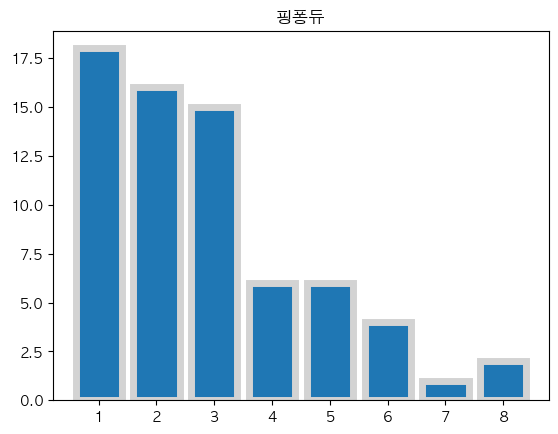

In [9]:
utils.bar_ranks(all_ranks[0], nicknames[0], n_players=8)

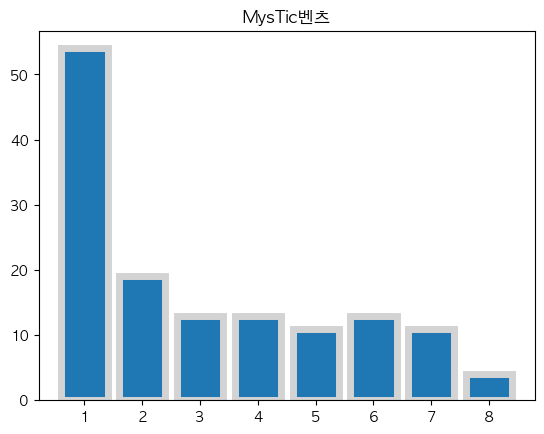

In [10]:
utils.bar_ranks(all_ranks[1], nicknames[1], n_players=8)

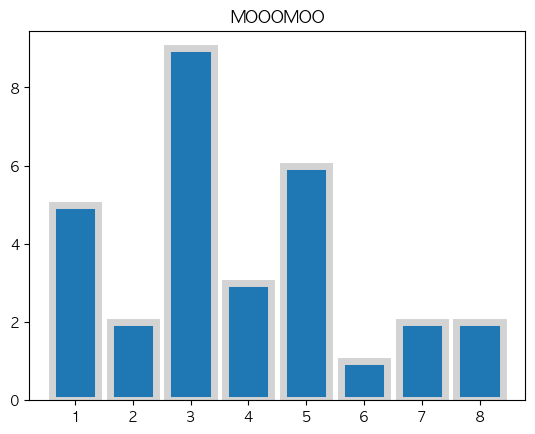

In [11]:
utils.bar_ranks(all_ranks[2], nicknames[2], n_players=8) # 기록이...반성을 해야할 것 같습니다

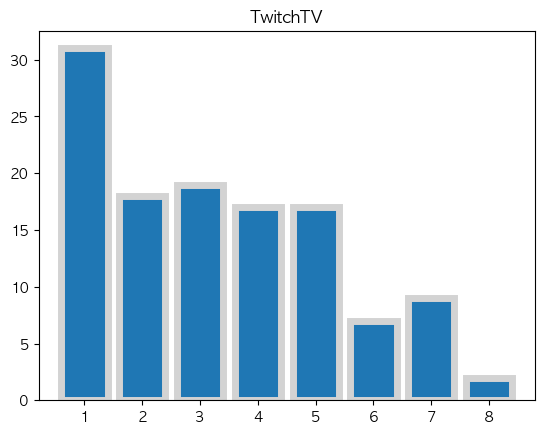

In [12]:
utils.bar_ranks(all_ranks[3], nicknames[3], n_players=8)

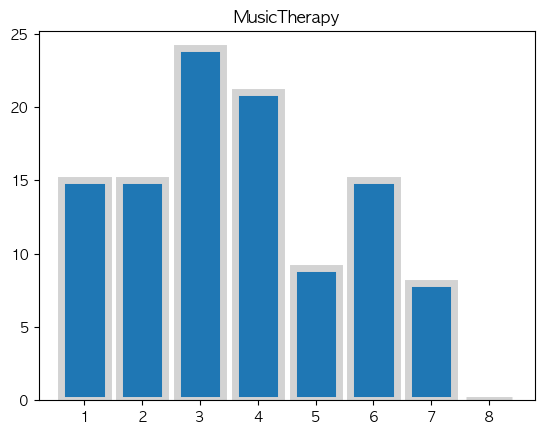

In [13]:
utils.bar_ranks(all_ranks[4], nicknames[4], n_players=8)

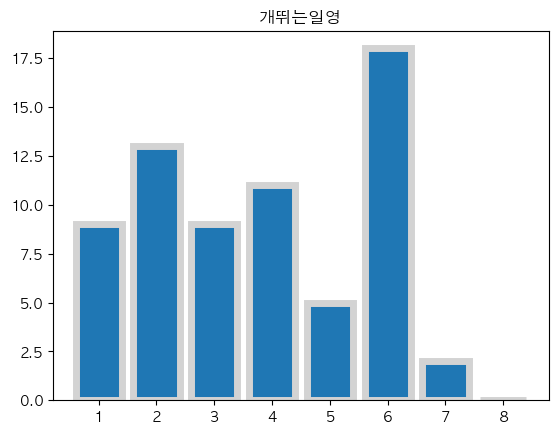

In [14]:
utils.bar_ranks(all_ranks[5], nicknames[5], n_players=8)

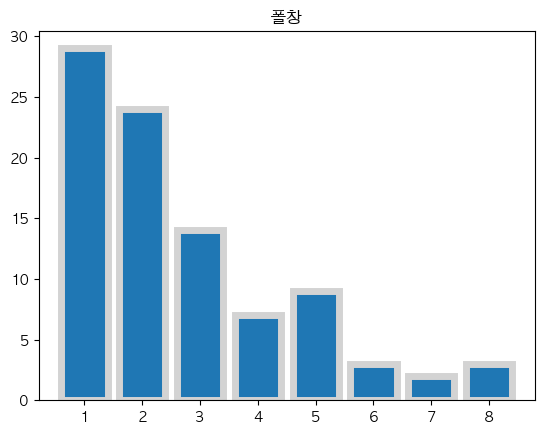

In [15]:
utils.bar_ranks(all_ranks[6], nicknames[6], n_players=8)

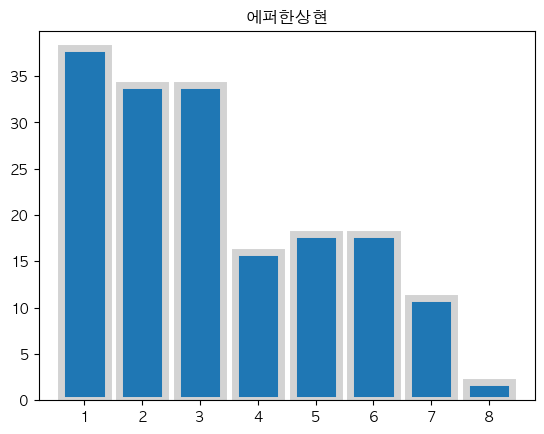

In [16]:
utils.bar_ranks(all_ranks[7], nicknames[7], n_players=8)

# 5. 분석 결과 도출

## 평균 등수 정보 계산
각 플레이어의 평균 등수 정보를 계산합니다.

In [17]:
avg_ranks = []

for ranks in all_ranks:
    avg_rank = round(sum(ranks) / len(ranks), 2)
    avg_ranks.append(avg_rank)

In [18]:
avg_ranks

[2.88, 3.08, 3.8, 3.32, 3.66, 3.78, 2.73, 3.29]

위의 평균 순위를 토대로, 예상 순위를 나열합니다 (리타이어는 고려하지 않습니다).<br>
우선 avg_ranks에서 값이 작은 순서대로 인덱스를 구한 후, 해당 인덱스 위치에 있는 라이더명을 가져옵니다.

In [19]:
sorted_indexes = sorted(range(len(avg_ranks)), key=lambda k: avg_ranks[k], reverse=True)[::-1]
sorted_indexes

[6, 0, 1, 7, 3, 4, 5, 2]

In [20]:
# nicknames = ['핑퐁듀', 'MysTic벤츠', 'MOOOMOO', 'TwitchTV', 'MusicTherapy', '개뛰는일영', '폴창', '에퍼한상현']
sorted_nicknames = ['' for i in range(8)]

for i in range(8):
    sorted_nicknames[i] = nicknames[sorted_indexes[i]]
    
sorted_nicknames # 닉네임을 평균순위 순서대로 정렬

['폴창',
 '핑퐁듀',
 'MysTic벤츠',
 '에퍼한상현',
 'TwitchTV',
 'MusicTherapy',
 '개뛰는일영',
 'MOOOMOO']

위의 결과를 토대로, 팀전에서의 예상 순위와 예상 획득 포인트를 계산합니다. 카트라이더 팀전에서의 등수별 포인트는 아래와 같습니다.  

1위 : 10  
2위 : 8  
3위 : 6  
4위 : 5  
5위 : 4  
6위 : 3  
7위 : 2  
8위 : 1  

아래는 예상 결과를 시각화하는 코드입니다.

## 예상 결과 계산 및 시각화

In [21]:
# team_red = ['핑퐁듀', 'MysTic벤츠' , 'MOOOMOO', 'TwitchTV' ]
# team_blue = ['MusicTherapy', '개뛰는일영', '폴창' ,'에퍼한상현']
# sorted_nicknames = ['폴창','핑퐁듀','MysTic벤츠','에퍼한상현','TwitchTV','MusicTherapy','개뛰는일영','MOOOMOO']
# Data.points = [10, 8, 6, 5, 4, 3, 2, 1] # 순위에 따른 획득 포인트 기준

red_result = {}
blue_result = {}

for i in range(8):
    if sorted_nicknames[i] in team_red:
        red_result[sorted_nicknames[i]] = Data.points[i]
    else:
        blue_result[sorted_nicknames[i]] = Data.points[i]

In [22]:
red_result

{'핑퐁듀': 8, 'MysTic벤츠': 6, 'TwitchTV': 4, 'MOOOMOO': 1}

In [23]:
blue_result

{'폴창': 10, '에퍼한상현': 5, 'MusicTherapy': 3, '개뛰는일영': 2}

예상 결과를 토대로 시각화합니다.

Text(0.5, 1.0, 'Blue')

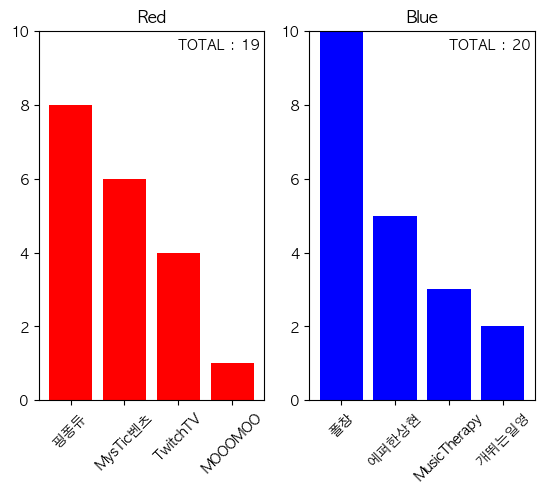

In [24]:
red_X = red_result.keys()
red_y = red_result.values()

blue_X = blue_result.keys()
blue_y = blue_result.values()

red_total = sum(list(red_result.values()))
blue_total = sum(list(blue_result.values()))

plt.figure()

plt.subplot(1, 2, 1) # subplot을 사용하여 한 그림에 함께 나타내도록 합니다.
plt.bar(red_X, red_y, align='center', color = 'r')
plt.ylim(0, 10)
plt.xticks(rotation = 45)
plt.text(2, 9.5, f'TOTAL : {red_total}')
plt.title('Red')

plt.subplot(1, 2, 2)
plt.bar(blue_X, blue_y, align='center', color = 'b')
plt.xticks(rotation = 45)
plt.ylim(0, 10)
plt.text(2, 9.5, f'TOTAL : {blue_total}')
plt.title('Blue')

# 6. 결론
레드팀이 19, 블루팀이 20점으로, 1점 차이로 블루팀이 근소하게 우세할 것으로 예상되었습니다.<br>

# 7. 참고문헌
matplotlib.subplot 사용법 - https://codetorial.net/matplotlib/subplot.html<br>
카트라이더 API Docs - https://developers.nexon.com/kart/apiList<br>
Python requests 모듈 사용 - https://dgkim5360.tistory.com/entry/python-requests

# (8) 별첨: (3)의 획득한 데이터 원본<br>

In [ ]:
characters = \
[{"id":"4c139477f1eef41ec9a1c7c50319c6f391abb074fa44242eb7a143007e7f7720","name":"황금우비 배찌"},{"id":"983bc9c0cd599a7ab5bd0d6b19fa37ed4464c23fc217f81e60a68cff1e210045","name":"첸첸"},{"id":"50a727d26ba24eeb62d0a73f36b5e1992b87826fdaa4b4c5049aa6b124a7db14","name":"패피"},{"id":"74bf84b99c3a3cccb9d1277b8ad1ec79bae6c9951e978e669d568c9529130736","name":"XI 리오넬 배찌"},{"id":"d649eb452533571bd4727c775e1bd1d6bf0836d0d11d9a989444a5ec57cedfe1","name":"?"},{"id":"8aa238f6f714250d2d4557da597598de608b6728be75e8c58e1b2d10255e4367","name":"W 에띠마르"},{"id":"ee9fcf31a04ae98d15d4774efbccd383b5102fd25a3d07f16ad28a74dd9bd537","name":"아이리"},{"id":"5cf67b0c7331973281b825f571aea5c1737952ec9c861967ec691401ad2fcf31","name":"연미복 타키"},{"id":"43f5057017b919397b4eb2a74463c76116acec19e7328fb5491f43b828b51c27","name":"베이비 케피"},{"id":"233fdd05a4f3c394d5b77570a49560055a2ca9cd964473d0ee3f20f31edbeb70","name":"네오"},{"id":"99581348c3943b86c1d27460b92aa243a0c37cc5fd2a7163227ddbb6895c915d","name":"머구리 군단병 B"},{"id":"9c7819ea7bc6a96b4e44fc2368363c99d13ac271b06eadd1389654d3be692001","name":"메디아"},{"id":"1e80a426aeda80b4a24a6d092f37bc7b682c939cced32ce775ff3f56cc918c96","name":"로두마니"},{"id":"5ab08675ff3573b9d2aa6f0297cd60cb25dd240209a8336150821f077eb01d9c","name":"헤라클레스"},{"id":"ac3b0f8f1a6e798d7ead26c1af4eb933798e5b7611bf8b975ea187e461d14e50","name":"파티걸 첸첸"},{"id":"d7d968e4a249d5919f8ec0520208035efb6d8af528acd71dca3ea6c277b78ba5","name":"크리스"},{"id":"cef4ba19db39e41381ae9f64061b6984e315908986ff58eba4937e8abc79ab5d","name":"황금 모비"},{"id":"38860fffca8aa72ff633585b625ee395f59d4b58359dda64b050d3f642a86a15","name":"팬더 황구"},{"id":"9db1d0be9ebee32909451e30d6a0dd83fef43f96872ff6495895b902c5fc79ce","name":"팔라딘 다오"},{"id":"d61f1bc8e2ba44d762cd5ecde7dff3beff92c9bf1702de9301b4c772c7c1ccdb","name":"산타 티이라"},{"id":"7e0c416c75ac49b3d51b7127a18f5f043867e90b97a759ac27fb0bf1fd963a18","name":"프라이데이"},{"id":"f320308a5732217457d706f542a3508fa22c4d2eb9d2664e5d9ca0cef4690349","name":"달선녀"},{"id":"8ff731c8d43dfd1b13dc2290795bec46ad285ab2164abb340bbdb1eb132629fa","name":"우시진"},{"id":"ada336c28a50609dcbed70c7d117f50b05567785331242160340f0a2e5b65223","name":"의녀 마리드"},{"id":"29ae3014d4a5babc400f7fcc4a10c856966ae56ca43a75f129e23631f365f3de","name":"해적 배찌"},{"id":"2dd05287bae3a67d2f1d559895681d9e9fee2e676864fa73b7a39f3656e99f29","name":"삼미호"},{"id":"d0adfa305d7299164087b44fe53ed543a003c8cfa6d6be902d2d283834173686","name":"14주년 네오"},{"id":"852c665ecc5bdd5330beb077621c8f0156e25746548d9705bb4e050f020e869d","name":"홍길동"},{"id":"099b192734184ba9595d2612a75d54dfa446dd030f0ea13e8477860f0d719b07","name":"로봇 배찌 변신킷"},{"id":"c31f343c9afbef9ed6ce8c2dfca2758e9af255d5ee4cef349a182b6d4fa44ad4","name":"럭셔리 우니"},{"id":"963a3998cbb571c940320972bf8de8c85e3aa7c7a2a0c9d3ab010a3b102a8851","name":"로리"},{"id":"04d2d9f34fd3aa1a6599ec7dcfe108a396977574037b42b6b70bcafa114bf8b0","name":"좀비 소피"},{"id":"03a8da7ac1a3a62cc1dfa2e97091c35d81eb60211e6db419a4e42bd5768262ab","name":"렌"},{"id":"3a10f8bc1b4b1626234278fafc8fc08bca5beda551a74c36a2302a935202eb61","name":"사복 소년 투탑"},{"id":"d9b40d4554d7f837a435c7774ee249f2d6f7d5b65410ac7eccfc5d52791d6c79","name":"손오공"},{"id":"d3aad4bafb446d33576c393da5e73f59aca160be04131391ecc3fe7fdb89ebbf","name":"예티"},{"id":"de817181cc520d014faba8901c6baf3927ca78bc86a1991e750afcc0aba7f13d","name":"레이"},{"id":"1696ecb5ae0fbfc589d1c9dee060d261041b96fe9e58ae52c3794b0aea212348","name":"한복 다오"},{"id":"18e4c6d96de80ffbdf4d1e321775f559d632ec84bd1a8ff3cde2bbf7c1aec902","name":"교복 소녀 디지니"},{"id":"11b52e52d74b8b5ea356a0c086a72ddacbf7dc3c380fe6de4a38dea38301fa25","name":"삼장 배찌"},{"id":"d90e9439394d515109a92a8de70f76ea3b920df4309ead03167b0251dbe20664","name":"해적 마리드"},{"id":"27a8d3beec61af9e5d07968687b0981f8a73388b73e167e0fc96118d99a95005","name":"냐옹 복고양이"},{"id":"3816fe9d4994123a941a31a9a9f774d4cef4239d0f3a4346133f1a30f24c934d","name":"나이아드"},{"id":"a1d4265fe3b6a60af160b73981f329aaaac544ff60c5631310863d549b7b6fc6","name":"킹 아서"},{"id":"484d564bcb99b2b26026c7b3c499fe8b8f3b72d99440ddfcff5099e7f9b5f3e7","name":"항돈이 정형돈"},{"id":"17938bbe2a4bc55dc238d4e602936179ae27a43d0065870621ab54a550984d65","name":"레이싱걸 디지니"},{"id":"2ff992963bc1b26c9d9f5f5423fb949fc80c7c8de458f11cd4bdafbe1ed7f169","name":"토비"},{"id":"42c729e64e31aea803e4881432f7b95129ce97535c29e4f9a72919a9f267b418","name":"황금망토 배찌"},{"id":"461e0c9ddec85c5446436f562f11fbc94b967b3e2ac7a7cd9ac08c2c77bf5b36","name":"CSO 게릴라"},{"id":"299f53e7146747a153204a8402576e7485ba38d9f038a4bf32f97213f0c1f0b6","name":"랍토르 L"},{"id":"70caf2e9d978dd3d926ea0d16ad9d52cd3db3fd6f7991938f9b973fc662cb79e","name":"네오 프라임"},{"id":"37cd370b6c7f9cc5bfd6f3417ab0fcdf900a1f0f2dc311cf33c09f91df46b386","name":"산타"},{"id":"08fa4bc801c94fcb04552b87519cb3b88f4eefdd4ba95f24585a50be2a1d7045","name":"캐롤"},{"id":"4e918eb952c6dbb9a47ca93beee507534435387fd4d2d3edd76e7743f6b03c53","name":"월희"},{"id":"e8cf6bfc4ec4a3c216a00c324206cae99493220972be0efda4d0c94107436367","name":"dizni_idol"},{"id":"35d9c15579cd4992556a9c8b5cb8a8d6be3a12f8567a59389f93f14feca9caa0","name":"차키의 신부"},{"id":"b059b43423baf3f52226f87caa2a70ffe179686bfe322d63986213e8e6b96873","name":"저팔계 케피"},{"id":"d60483c82b8dab93fd441db413e2d43ad0ecc429f7ee826931c978e4d7c79b70","name":"다오 2014"},{"id":"39593f7120cf68c9cb766df8021aa71034a877e6a04afd741a8d842231acd2d3","name":"샤인"},{"id":"67ea63d4806560d66003de410682a4cc14a0cb47dbaf483d432656233e1b5014","name":"관우"},{"id":"fb667555335bbfca59b791a0b336b5e1faaae4c6e9ab0c3c5075c5a3ed77fb85","name":"렉스"},{"id":"9232f58bcb530f08aec20adddd21ab695bb2d902ec9db6bde91e06f4d6c51987","name":"치파오 캐롤"},{"id":"201c61527a04d85cd2de0dad75ab0878ee4125129e57aabe47b3d3ac06df8d67","name":"구미호"},{"id":"4f09eb7d2ce11a21de4c86cb4354fe7876c5b1b23d436c52597c8c3c753eaea4","name":"네메시스 로두마니"},{"id":"0700f40d4a34008464849f4615552aa0ce59f336a8956039e0c73137555e538a","name":"강시"},{"id":"a66d2bb56d06c9aa0070e81d27a4e61c0dfe12182cf46ed11d8534069534806c","name":"레이싱걸 티이라"},{"id":"6232f89fa5c8bf5c32b0b9db123f0688a29ab4cf0b2d9f7aae7a795f8ab9ab2d","name":"루시드"},{"id":"ef3773160896e31863f4803b6e62084ee77b0f885af8e15e52c25be670042f70","name":"☆ 산타도나"},{"id":"8f4dce1d00a4d0428346528da54803fb56a6be3ae376d138f71920cf63a2dd81","name":"티명주"},{"id":"620740f17ae625172c49136ed40e1c24a5395874f47cf5672c08ae0b7048b77d","name":"헤카테"},{"id":"5c32ead5a24f24e76b0237f944c220a4c43333c3e6133ae35c63a3b39e6b7e49","name":"황금 꿀꿀이 배찌"},{"id":"9113b48d87f147a4a80fa4105588b811d01fa706956a7db7c5c33e2a657ba2da","name":"데빌킴 산타"},{"id":"fd15aa5fcfebbb391a8192e6da78c6aa537533380f3e0473d07a3695250dbc5d","name":"대준이"},{"id":"6d978dc4959b20c60da1caa33701f628f728a9d8297175c2272a4db91ff7d5ba","name":"아테나"},{"id":"ee6c227264528a380fad4babf3949a81980662628331464752fed4a45c6eed76","name":"사운드웨이브 모비"},{"id":"12ec93b50a9d8aabe7b669e2ff480e60b74f04293d1e7aa98575295a34cb0a0a","name":"얼음 요정 티이라"},{"id":"a85f606dc18f7c8ac4bfc8cca3bb79396c9f4cb87b14778a17dc2b5158bd0134","name":"하데스"},{"id":"9eb8225f592b2d8a93961c0ff36bdcec5a84b3086d3698dad030b80b5e3cc764","name":"나일론"},{"id":"eaed96446435f56794a0835a349da0a97e5308e6b298586b669ca74f542a3437","name":"레나"},{"id":"cadf6b5367da4076be23547a5fbf7d482e05e558908b3071d858339a2aea508d","name":"새비지"},{"id":"c90932ad07d39fbd3de0fb1f46b5e076f7548585af63ce549c7b95b947506a77","name":"쩌리짱 정준하"},{"id":"18326a5a83792f6fa993072a4470d277643955390688595cf8b4401373e88ea8","name":"헬스왕 다오"},{"id":"2a22aac879cfb8629fb3f34ffd238d8714491872235a78dffeef5d5ceefe9030","name":"브라울 모스"},{"id":"0f3e859ef54345c9e0d39bb7de8c93753c6cb0fcdb24936bc6dd8ac1241fabe8","name":"디지니 2014"},{"id":"165255783616fbb46ac8845282271c476cc6016c5f2598e0333a188ce273b273","name":"사자탈 소녀"},{"id":"491cb06fc87afad97065db3515e85222b603d6aeee155a3ca0c154920ce63659","name":"천사 배찌"},{"id":"6d6d2f3c20d5340a656d2ac42ff3cc5ccae6d524e4610b0cb29ade1ced6b0539","name":"데브"},{"id":"fe5c1090d03f1a8141793732f2459c22179fb7046dccb1bfd64ba708176d2133","name":"라쳇 티이라"},{"id":"72961c5a9c40988b6ee48a9e757d09d9a81220b2f6a4da8754e903cfbfe7de10","name":"로봇다오"},{"id":"0d8d081a55ce3e277f4d73425e7ebd32066af381a83df9ab32a061955c3b1970","name":"라키"},{"id":"123930d209a50a57d67ca4d7d294625afe1f115dc07b947c0fb2a0af0da11cca","name":"릭 변신킷"},{"id":"bb0530bb8ab7c3bbaa194b5ccf3f245bddbd652aef0dc11e7ab5c2161e408038","name":"나무 요정 배찌"},{"id":"a6d90f9fc4e59a429af4d128b4ad1715ec6860e25c66e600ce0d910faecec786","name":"우니"},{"id":"c73a05340d4deae7e6acdb07ef863d66f5f9a22e95eb46d42fee683add7dd1a8","name":"홈런왕 다오"},{"id":"e69867b76a1537d6a7418ae087aad4925a7e67c74fb9df2fc98525b8dfc3a7ae","name":"스티브"},{"id":"a6af2fd35635c8e3234c8dd27d9f6c3cad038983545c0709308575c30ce9fbc7","name":"닥터 R"},{"id":"359e2c2a1a3a71ff531d594a771f0887d9279c52815ccb105123792e97c463c5","name":"여포"},{"id":"7b3bc9103e498f05a9ebc785def98e35d0b166f0abe1a16d5083024435fc53dd","name":"리리"},{"id":"4c354ba740477d9a0bc7cd8f1f1be0e4e2d665f36885c50224e6f93c1eb16090","name":"디몬 티이라"},{"id":"34ded5b62a9a9e4be11cfc711e5b66f95d8b2a3e3cf98b0afa2f11149d98c090","name":"바니걸 첸첸"},{"id":"f7589127920ddfb6162dba17744c9e12145c6302b044bfeb6c5314433da1bc86","name":"노찌롱 노홍철"},{"id":"894aaa9aade66a9e453beb1a0a41b724512586eb026bce84762357bc852a7973","name":"너울"},{"id":"6a87ba835d83146e24ad16527487f977232ae3673da18496574b4636af262b4d","name":"한복 에띠"},{"id":"40ff885703df8534f006a6d9ecbabda08448b0c83838c95a64919d1fd4c4aa1d","name":"피에로"},{"id":"f2f5e34718f4b143aa0917132156d68bc5688d7d67b37735c065213081e8afb9","name":"소피아"},{"id":"ea19b99dcacd4bc8afd3cc191f9dd7b32a6956d4cf579e83936ea121bb039dcd","name":"한복 디지니"},{"id":"17dd3854896ea36cdc7126b078764d08278005e2017ed7d87edacd01aeb56dc1","name":"교복 소녀 첸첸"},{"id":"66bc6d1dd1bb6b01fa3fb1ecc41eb2c2568a738b8b1661c1d0a1d611b905a5ca","name":"10 마리드 베일"},{"id":"64913f411644c6ad41359defcd89715660f2dfa1c20f4e3bad4d9d0139ff5d6f","name":"황금 로두마니"},{"id":"c732b34136ee390f34c317a75b8ec1e225faf961c5ec611df0148a3e4e6171e0","name":"빨간 내복 손오공"},{"id":"d817c691f5e9bda87869afcf5c120337efae656602eeb2b56164d9c73a7d1f74","name":"도넛 알바생 나린"},{"id":"2b2caedae5fba8a13742b2f9f086e89863d0503a92b34ca9a47b59785b249acc","name":"럭셔리 마리드"},{"id":"8026b8c506bf8806c2527bb5155616b4cd08dc4527ec2bb3f5dd12eae14a7845","name":"금첸"},{"id":"915935d0620e3b54b30a28c52d7db3f3d34e231f6b2ec963452cf26349d77d88","name":"모드레드"},{"id":"d3432b38bfb884f9a7a2e5e750cc9ae961fdcb65c6ed1a09de9d7d98fc576718","name":"유반장 유재석"},{"id":"2d963f1942101e1f7a1dbe9ecc6f415f80429a7b960d63af2eb3f4a238eb05d9","name":"CSO SAS"},{"id":"8e49f04a09701f5289e58b8840c2d5baeebdbb8230e7a7e6ac6a16f837524ceb","name":"마법사 배찌"},{"id":"d63d45e33c8d74d3dd9a43bfabf492fbbdc5afc1c9e332411c6e79ccf5505a0c","name":"사서 카밀라"},{"id":"0ec82b0f77b2746ef28ad2d80ad214d8134ffc56430b96096d827d04df838943","name":"일지매"},{"id":"ffbf0d3d232eefa611fa10ec1a0476d5cd097a5bb834fde8619ffe202ac6dafb","name":"파라오"},{"id":"bb070d69adc4b66b7c9c3dbffaef0bb48f4b6947c4f966756ee1bee7bce3da74","name":"테일즈"},{"id":"5554bc6b89330cd9868df0d1f4900022c7a50d6e4135edf2f5071b512355c21e","name":"교복 소년 투탑"},{"id":"a772caaa0c4a7457a353845d5e473a9a27dc0703da74443833c9439c811010bf","name":"금비"},{"id":"eaf50a8e18f39a9943254098efdb924aac108eb698a34e9a968bc7bebe383a53","name":"함장 브로디"},{"id":"86bd4174c46088b5604a0d1a7b28dd07a88b3ea17c3a0bdc98a790785a22c2ca","name":"네모 다오"},{"id":"bfdbd7d142d0545cbd0ae3f49d5d8063c0ff8bdad45a3ded3f5c61f12dfba6c2","name":"드라키"},{"id":"5cc261bf0c57444fbe82f4deb9cf51d772d59368ef2d30e80f3f9b4bb68e5f93","name":"타키정"},{"id":"a817ef8ed63393de94764be0556007bb9c2a223099ff0601d8453dc04252ae8d","name":"노네임"},{"id":"a0386ada04958fe9d7c1e88aacccc6ae5fa2119fa03397c5744f9e14e29da93b","name":"머맨"},{"id":"499d5a28a8697d6be3a7d84bf80ac4d6fd2b58f8b403007a6759d206fa0e86d7","name":"02 차두마니"},{"id":"d79039d00350e6c6fe9ba055d7cfec077859576a9f3dd71ca69a7bff65467da4","name":"로키"},{"id":"041195c896c373b7764e7786fab3006d897fa7326a90fce1d5299e8b78d9b672","name":"태권 배찌"},{"id":"a267365c10ed175363fd8d6384bf16163852814aaff3bec07b1be13897f5621f","name":"나린 낭자"},{"id":"9ae086905cd1b687c2afc89f026ea2c1d32228eb9615744f6a9d0424ddab6f9f","name":"네모 디지니"},{"id":"9c823190b186e1f424667aa2e5f36d2e281b824022070523e23d954ae059fdff","name":"경극 관우"},{"id":"54f5652b9f122953fb892aa71140b6b3cead53dd18d39778a30980f7c601360c","name":"네모 우니"},{"id":"12d214e8f1d707f5d23a5916f19a8ef5643e039956a26ad316b806ab3e41a97e","name":"가브리엘"},{"id":"9cb3d0bf4c980c788ffdccf6b74ed8491c09b7629d3385e752f0dc67ec73c006","name":"카파에"},{"id":"fc0a1c8c60a8d8cc28baf4c9202d01f3bfd9939faaff00afcb129118a0686bb9","name":"쾌걸 네오"},{"id":"03f3a62236e1c9be035608202a167c296fb3f9e7c92500db1f6a71aea620400a","name":"교복 다오"},{"id":"40e599f0b7ef9e1cf7598fedae90ae2f0e062e9d559f9ebd0eab4d1594febd46","name":"캡틴 로두마니"},{"id":"b55b2a70ec52f4e89708722e277b69f0f211a5cb822dc8ea2a72407e8c3c8a6e","name":"치파오 다오"},{"id":"96cfd3653496a23c1aaa423376e4e9eda86717314be3ba7ea5b96e81e708482a","name":"머구리 군단병 C"},{"id":"d06b646344b0e8933575dc2d411a8b10a4962d0453ba3d641cbff0ac73da1e67","name":"마카롱"},{"id":"3e4164bde482c2d022191aba28e87826442762c653af000363f1f9f72d40a6ee","name":"NEW 팬더 배찌"},{"id":"f025f67c3647c97dbd5feba8fae65317542374218957601e51c61ca99a6208ae","name":"해우리"},{"id":"6b82c37a4645e71aebde24081cbaa45fb2f2544e25c7b204db4dfb79c8484ae8","name":"유령 배찌"},{"id":"a229e11002fa6d130fa8ea238d9efd0a3b1a7135fb712aae4ffade556011b819","name":"네오 2014"},{"id":"56713048cfd2822caa048788f3a35c79157ad19d0e5b7285b92e929d3416d21e","name":"교복 에띠"},{"id":"4cacca8311f4452bfb850c9950bf07b706acb6e9dbee46fc644bb19f5ddd7281","name":"황금 무술 팬더"},{"id":"e34fca258aee3716b6b7a96c01ed21b17a9769864662509eb44d67e8aaff8a41","name":"항해사 로두마니"},{"id":"71403a535340ecda838f8c3c3369becf0ab5b4e5bfa968ba02723039c626fb7d","name":"투탑"},{"id":"682f22c3d8575c395e7b38b7aca4b0a367d48bc88651c23a43b20983a460df54","name":"XI 웨인 우니"},{"id":"ddf3c18999153bbb9919920b4c5f228fe77712fc0add7778ab2b5c02e2fb4c97","name":"마트왕 배찌"},{"id":"54323f16358aa315ac4a20fec3df9dafad713054847add3a11e5811cc0214b0d","name":"진다루"},{"id":"ebc1215d5c702d47985836ab63710eb7b6bec34af0735f1afa277cb426d663fb","name":"미즈 토르"},{"id":"1fa689882cdbb1d1d8a2b32b1a308cab964ec11172560e822b6b622867dac4d8","name":"썬더 제우스"},{"id":"03e6c20439f6cdee8470f26b0d5aff7406f6f7e0307f1fb491d6ce519504a135","name":"두찌"},{"id":"9fa48a0c3013c642adad6b72afedaf967444197b527f57ee50ac7734f5d9bdf6","name":"팬더 기사"},{"id":"fe934fc2127a6abea19afe739294f6dc74383a3d9f1e10b6edc1aa373c8791be","name":"한복 다오"},{"id":"63fc2e65ea179712d32de408578a626d300aeafc3ad2587c363f8a8a18386bdc","name":"드리프트 렌"},{"id":"38f829b433b690f02fe89e119ea2a62a3a9d7363e1a8b478fc1a173725d3bf1b","name":"황구"},{"id":"7d608a928b409f115e98f4031fd9ed4228e16ad6377a03ed4fe31b5454d5f059","name":"트로트 스타 우니"},{"id":"336b05c224cf8d47c1424fb1a2679fa2153338749b96fe5e12a3c95df2e60e53","name":"W 토모스 뮐러"},{"id":"77277ceb7a8df12343ed9a3237fdf125efa8eb2cd568d6e662990513ea095e94","name":"16주년 마리드"},{"id":"ffbff03058d1ac96b4d59b378234d9f17218e26d76cc1db11d3854e271c12cf9","name":"할로윈 소피"},{"id":"b402f3d1f24228cdb64a67fde608912b9c4cc8dfad336fb1cb743c2ba69184d8","name":"메카닉 다오"},{"id":"c6788a8da9a7543759773c60a7e006fdec69a5a1fa135811b87a941df61dc0ba","name":"달토끼"},{"id":"23bcecb33a306ec843e0eb6c79860e3f7205f2af2160581b31486f62b22ddf71","name":"기사 첸첸"},{"id":"899f1ef202ef17b1a8bdcd04ca1d59bf5bc2327442a8356be271bbfe2ee6d8dd","name":"좀비"},{"id":"49c8e0db32c54a41dbc0500c29d389dcee3065d1fc6bbd8af4429c9c162c56de","name":"에리니"},{"id":"c51a1472a44cccd519ca3d53b7e5f1d1841aeb8f0ca929dbe94b2b7e97b14ac8","name":"송모비"},{"id":"81c9f10de2f39d42f97b206c5804c32495e3f3e751d20529e1ac3c8aeb0a4939","name":"배찌"},{"id":"0cad90f90cb0995fd6a7a3b028e2577c6f6d2acc44c2ebb42ff21bf36a2cf5af","name":"닥터 리바스키"},{"id":"512fbcf4f7af368d5d7bb190fc590f40be9196fcd39442e6334a360cf3f7f925","name":"초선 첸첸"},{"id":"70b62a67fdb6ab9e3b0be3da776f5968eb83925420481e13febd96d9e4e21853","name":"나린"},{"id":"218eec75c91688cd1a10af9b131b7b5a81e45c09ff9ffcb503ea61e4e9c8a4bf","name":"알타이르"},{"id":"da575eb7c0d836cb4fc4c3b6515dba0c7d0729228c395510cd65dce27d101f63","name":"키홀"},{"id":"d7195fb438c7a8c1d2df392bf03c077ed286da8136e84137c37c997f31441b04","name":"간호사 배찌"},{"id":"b902e06eb9214780e50289fdf6d7e9df1e11629de0b2252e7939c6c253ae1d3d","name":"의사 배찌"},{"id":"307bc0600f2e821a933132f671ff9ca011bdbd4adfa785db8ed3d939aac4a677","name":"카이"},{"id":"3bcd5684051f094eefe443207254661620cdf484a69b334808442b47a8df98a5","name":"호랑 사또"},{"id":"821c7282490926c35791abbb45685bca6011cba8524f4ef76f8d8f56e9852f9d","name":"브로디"},{"id":"286ddd245dc522a7c183f6c8123246f8c1f803bf68571d1b5cedf0878bea82ff","name":"메카닉 브로디"},{"id":"d1f895224f6089b0446b480f0254b6a28df296868cf105b647601913a3241bc3","name":"티이라"},{"id":"43dbe2daec2b1995d8b34003f8883463e941d38d2a6201b3ee1dc56d39d5f5ec","name":"너울 도령"},{"id":"b4349651ee49abc252d79b39f921b89394f3efa0099c9bd305974b01710bb502","name":"XI 모비드 비야"},{"id":"829e2ba4ae4aa21a3069caf3a8eac83e0f1e11cbcc3ba95ddbad79015d398d02","name":"고양이 디지니"},{"id":"c16d55a1b14b675974fc8486a9ef3ae227546f4f065fe15227416a3192fcec76","name":"갈바트론 R"},{"id":"8a03b84527b293f078c7e635beba97d98dd224ec75dc4ec8f1ab212993e0452a","name":"브라이언"},{"id":"48322ea7be9cb6ff63d2cedcc92a1dfb4e773bbcd2fa388a9d6e4776f05babcf","name":"베로"},{"id":"87d3c0e036e1011b73ffcbbc36c62d1f507ab8e5c0b573560bb098dd707c2f4e","name":"베이비 디지니"},{"id":"6616d4a88781330b13add9cc59b6fd81cb5d362992f67b192490a84daec8822e","name":"로티"},{"id":"fea2dd1131f781be5940cf0f9fd2d88a209f0ab072b9dc4346d584e715384bb2","name":"베이비 로두마니"},{"id":"8e80ea9e763bb92b3f8991f4c9ef1be1f39ffca61e0d6d54f02128339b8024a5","name":"하운드 우니"},{"id":"8981d8bae78600bc36b29c93866e23e4be92c06e32ebe6c67dd0c76ed369165d","name":"오딘"},{"id":"90e089c7b450e57c6bcbc63735b51694dbfe8f86a63ef021da02e950bd75ddbe","name":"유니콘 잠옷 너울"},{"id":"f76aa657a0a184521c6792528dfbc36faff117929e1b65000d6d69f2bf7d2691","name":"골골이"},{"id":"bab86237585819eba08502b6673b299dd9d04c4ae7715bdc4965cba2f917049e","name":"장비"},{"id":"0ded654f533985e3b0f4967a551c2c2c67b52c563b07f558b96b03336c5f4f14","name":"프리미엄 배찌"},{"id":"ff2d17c4e2ba106be2d503e808ee84d7cbe6fea29da5d452f5f3547b576237f0","name":"랍토르 R"},{"id":"117d52ac8f9dcbe03af0cb4f1fff94821d1d8a5b7ff575a79ed7e0e781e9d27a","name":"국왕 배찌"},{"id":"00b6ba1b9d74bd6e9d8dc8f75288ed2419c68b466953b87ce4c22430f761bbcb","name":"응가맨"},{"id":"f2ee3bd3e224347a79a41cb8dc74f943aa344f66648a5ea9fd2adc0716fe726e","name":"서유기 손오공"},{"id":"af6d6612d579ec755b2027d5210de3aeedcf9576a5b5bcf53b22a0c8656a8444","name":"카멜롯 병사"},{"id":"b6eb565e2940edbf43e4fcc42993dcdf12817f35714627ab4790853b6b2eaded","name":"다오"},{"id":"d9e33a67056949e49d283a43d34380bd3b981d38aa5309b04fe777e4429674a0","name":"호랑이 다오"},{"id":"3fa3c1c390e5163c7e7e1993ccc961ff18dc03c7f89b53bf7273a8791ca023c0","name":"거성 박명수"},{"id":"079d707abbba1e9736cfaf080b495e75e1035cd8342866767c1df21c31cb7814","name":"Liiv SANDBOX W4"},{"id":"78f0041cf9cc1bedab0590c5bd9f8325da541eb8765ef1fd182cab9eecfb85cd","name":"아라비아 왕자 우니"},{"id":"c0383465b2ff8b2c2971ba377e35d170fab4ba27bbdef6a4ef27fa71d573c269","name":"귀족 마리드"},{"id":"6ecfdb672a296286238e0a9d2729fe6899fb96b16be445dc3b3014a97ec5ade5","name":"전우치"},{"id":"4671e909b560c426d32bc83e28c1871a01ca4dd73c7e21289834876926dd67d0","name":"베이비 다오"},{"id":"2960830584fbc95f68bf9b4b772891cff8ce6e37149f6cba51698641b14c5336","name":"헤임달"},{"id":"f971913b2afe8afe1ee70eb708e24485f3c4736520b31ebd8ba7205d7ad79e18","name":"마하"},{"id":"60c44f7972fda29e20410fc9d67084fe54b7d2cdd0a581a17a9b2f35996e1597","name":"그림자 제우스"},{"id":"3b0483ea42e7d8c82d1e4f81326960197f0fb0b35b9a986f7df98630a7fa2e82","name":"럭셔리 다오 페이퍼"},{"id":"c3506db13f94c9b923a4bc0e76c71446144b9123204a5d233418becf89d4f106","name":"카르노"},{"id":"db3146bbe63816c5b7adb34cca1ae2507c46b7f088a59f5e8a32841468653f40","name":"SPAO 우니"},{"id":"9ac2f497a2a1484079b1bd3772b2a5557da654d7479d09a7d19023c3421c65f6","name":"흑화 배찌"},{"id":"ba42be32cc2de60fc591efeb7d686daaacc556a959455a5694839f5a4a6c368f","name":"보안관 첸첸"},{"id":"a941db6f78468ad00327b55b24569fc98e9fa6655d125e9a517ab1d7cf1c5ccc","name":"슈퍼 소닉"},{"id":"d44815a9c3a326e379fe98fc5b2e265d04dad2aaf7940da8ce804f2c75f35144","name":"아루 변신킷"},{"id":"07b0acd6126731392e9286df343cb1e79525e55b029c6c4ae0bf5d248add77e6","name":"대왕 배찌"},{"id":"e7a723c1ca9363b2f513382eb750c593dc914088fe61fc21e7367bda104b8228","name":"XI 호나우지니"},{"id":"80d3ff5907c41f4f4d92ed3b5cd3b974ffab70467b733ab2f2df1564f966a31a","name":"미즈 로키"},{"id":"a88ead0b763922620438747f108cfbc87b24eed81ca31aa4c13dabc466416b7f","name":"밀리터리 티이라"},{"id":"528d232efd3e84605b00ff53d891025d7c0897552c58885c61c7edb046fef66b","name":"월하 문주"},{"id":"493b9a50af633d001af99de21767f9bc19246fe09ce03fa45b779a0f3d51ea95","name":"수"},{"id":"0192ff377857e250d5dac8b435b774de8675a9b8589d850cf024588436ff6d0c","name":"케이"},{"id":"26aa4d0d6c380b1d2b78150c49754cd21044b6a940a339d134efb6a153d9f66d","name":"루시"},{"id":"95de437771bb1e094b4f3ef1c1a81574093a01e8d3be037c5a9fe0834dfbffa0","name":"베이비 배찌"},{"id":"6d0e09c311e93eca93daaf2d92154b17dddd6dccc508914152346b0c68215113","name":"럭셔리 배찌 페이퍼"},{"id":"167613e47f1cdf49ae832e3bbf6e8e18bb9e0493b0c1daa840bbbea05feb0838","name":"라마"},{"id":"d7ebb6d61b346db626ac35ae67f79b91f6de38c8c3773594542c98549b4dfaa1","name":"열사 마리드"},{"id":"b0c82d0a30cc9b108976755ffec70e81fbf62c6402ab223db850d1fed074e891","name":"웨딩드레스 에리니"},{"id":"3702bf0f9944ce141ad95662abd501b3055ee4afb7c195932dd8ef7e19781019","name":"중학생 다오"},{"id":"6201aed2f220d03b7c700ed2f9fc1034f856832fbfdcb121104aab83501bc57e","name":"빨간 내복 첸첸"},{"id":"f34684c71b08db92fd751ec7606cc8818d1d37f5038140188e3b85f20f49d015","name":"네이버 배찌"},{"id":"0dae775fcc29c1efa97e9c946ad28eaefc8d310c80fc14c1874b685f8615b7f8","name":"치파오 배찌"},{"id":"48357251a360710371aa5c9f0952ea10ab454feae1d53fcd147980068b33181b","name":"케로"},{"id":"64600b77cd9bf2e72ccc4ebe2d46f4e57e14da57d2f42ecc88b21b4a02514559","name":"프랑켄"},{"id":"f8b01176284666b4492a8d0a842fbffaf0b36ae5d965b80c8782ae5c23c064d5","name":"XI 호날다오"},{"id":"60d727862afb63c66b3ec1c5853afc0501b476b72c7b7520f55de2c79caf0bfa","name":"XI 타키야스"},{"id":"d886592e63fa2fddaa7e576af83146909e1d390bfacf1195b5f675aaec110012","name":"은반 요정 티이라"},{"id":"182ea877f0f1a2838258910f4ea318796f3e5cfbafcf02a4b64a2da6377f01fd","name":"한복 에띠"},{"id":"7da60bc1f5bebeebd74c6e217935f6012dd9b8a16167d8e1b5ff7bcdec3458be","name":"흰 쥐 찰리"},{"id":"8920345c82ab0dfc4ff2afb71821ef3e2f358a0d60d2af748789cfa8df1a2d1d","name":"히어로 다오"},{"id":"f6cfb25c76181c9ec7e6e0c308fb91cf08370039eb1c122c6fac2f4401433b01","name":"메카닉 모스"},{"id":"7c50713f9aa558f3795d53e5b5a6b0c530b7d695239a12abc9cad163822f3d96","name":"레이싱걸 첸첸"},{"id":"3d210b6c5e553cd2840e106b326f26edd40e3e39967e5b273ee61c45bc8f4ddf","name":"티이라 낭자"},{"id":"2087c4ceb84b1a2e7d9bbdcef3c40830fd3cd5caf4e65d04153545950262a48a","name":"네모 마리드"},{"id":"1b56f6dc628e6679ad8664d7e4ad59d90963e168087c774793342c8f66d36980","name":"SPAO 배찌"},{"id":"2ecb10f5e23493727a80a91421d6242a18b131f743676e72317bde4bd5d27131","name":"디지니"},{"id":"68739fffd5995d2cefb55e8b65ccc91c4b5edf5ffd775677d795d24d0531f002","name":"한복 디지니"},{"id":"47e0ad57b5c5146e9ab34e86035d4582f7e5546b4673db088077ac17f55a22f8","name":"슈아이"},{"id":"029704940d22ae90b08ab5ff92beca5a6a2e7c3bd481acee1979767ebd023396","name":"마리드"},{"id":"b8fb2152e32a3c9c41eb7b8e35bdbe2566a0ffd4b207613b5a33dc7a36a9de91","name":"오르카"},{"id":"9618e1a9732dd22b8f00dabe5f0add1631baf7b1f59aca6730aff9137f23577c","name":"BLADES W4 우니"},{"id":"a0b4b780c91fbdd602a468d67f19a03872caba23190ad68e0c18cff1e7ce8c8b","name":"소닉"},{"id":"b8897b7f40241866393d11f494c00e1a471ce78bcc4d75f65bdaf84834208f3a","name":"형돈이"},{"id":"f4affc0def68aaa2c417fc38b3128d49e436011e1ed0872e91ce101db7cee20e","name":"뉴 티이라"},{"id":"d7360ff9705be0e4c5d80d19821a1219f48dab00ee046f239d102f224661bc75","name":"여름산타"},{"id":"177e6cf04783f2d311ecd2bd995aca9ea844ca45d436fbe8a55c8b09daa99a9c","name":"데빌킴"},{"id":"e55976d624ed3a3a77cb84888827287d5f20e27928b272a14c6703a4bb2e3da9","name":"성자 로두마니"},{"id":"89b30770d9e5503e95a9c42a82a85f55cc3743d0a071c65c32993ea7b84cdca2","name":"투탑 배찌"},{"id":"c35473c5a74312c70e49e82ecf45bdee71507bd9a9116758c3bb880158460268","name":"머구리"},{"id":"64f83eee583193e4386ce610304fb2659f8e09ee5cb47938701139123a3f8275","name":"머구리 군단병 A"},{"id":"490cc4953d05ceb756807ac9d3c5499ae6f6c48ceac7499baa9dd6d1d03b1c6e","name":"로봇배찌"},{"id":"0e60290f32fe2ba05b5d6c56e7f87b814c3f75714d1fbad3cbb7b9564a2f9bbc","name":"무리수 길"},{"id":"a8c47ebddb69fa032497f9e4c5edc434fedad8fbd63bda52c4399f69a00c4f50","name":"멀린"},{"id":"39e1dada9ada67f5a018d07da3a0f90b67759182481594be7b60d76cef865cb8","name":"오리온"},{"id":"cc2f5d30773f68e8d12a88bf649580875f3bfc24fe0a391def0c0d9939ab64b1","name":"제우스"},{"id":"caca3551b1851b635ec055a11c701ed7f9ee5dbc833fe2d7b766d60fb1631266","name":"구배찌"},{"id":"5f7da1b818aefc94cdbc898f3a3d92d02e5786a255a59e140f5de3b4da892dbe","name":"아서"},{"id":"90319a6b7be01edcdc2e44de7d6b8b1929581f2089e2548fab46c25a48bc96c5","name":"10주년 배찌"},{"id":"e787e2d97ca2bd29eefb6bfc253ed072491504c8d9fca6ff25784faedb9d6ba1","name":"투탑 락다운"},{"id":"867a101355a0d6242af5736cc643f5dc6b64f74234dd2040df9ea87ded7af878","name":"라이더 관우"},{"id":"3e07f240dc0c2806888c744183d0b1de7c3d68b7c2207ba26dcbf655c7b87663","name":"투투"},{"id":"099c0842035d4f9380fecd6df971d78cf07c05dbd459c6e4304c1177d8a23b79","name":"소년 헤라클레스"},{"id":"a39de5f265d2520df6f5643a8c60ea590be6b2b5d8079ab6134c2e261e1e5693","name":"소령 케피"},{"id":"65f565a5f575b7507f9bede84490c6caa6aceb10bb7502fa1f109d6104948fe6","name":"눈사람 요정 케로"},{"id":"f5605422eee531a85cc49bbf393a3ba6c0b415288d76c2a6e9f4f0f5e6756e35","name":"에니악"},{"id":"bfb1dc77d26dace7e43b901c985e0e4d01e180e356b0eb792c3578c0fda76849","name":"헬멧 배찌"},{"id":"78b895989feeec917748d080b2a3bcf13499fee3ef0d5515dec024cb2d580f87","name":"루돌프 변신킷"},{"id":"58f9d10f193a633ebc78056cf1f3fa5abd21d4b99f58f1557b0ef710b7942532","name":"모비"},{"id":"4a981fdd90acaa73d41c1cb7d95b7d763b35dcf97d360b545e2ca5627b6999a4","name":"샤밍"},{"id":"6e5f6fcfcf09c462980436a6bf89b9d87aae4e2491c200922f1e76bb84d35f86","name":"핑크빈 배찌"},{"id":"bf113c09e6689aea1181d2a82ba81e73241e4dba88c086bf76b88682d3c2df43","name":"토르"},{"id":"5989b89884fc3e5356178dae21118ff3bdfa532ae226c3dd746dc88af32062b6","name":"로즈 알베르"},{"id":"05e82099c06bcbfaa43089a6d2796ef44e81d3ed4d18a920a93c577a030d613c","name":"너클즈"},{"id":"972397aa523e2a0785f17f0413485360a62e563679c4f7d3e5a30107d5020b98","name":"코코"},{"id":"f691e5a7fcbb296666849ca7348d1d2bec48af9a873089c7b32e6800d5b0eea3","name":"카밀라"},{"id":"69b369febaad1b522fd3d9af71fd223b14282057c58cffcf8a5e004bf878691e","name":"모스"},{"id":"3bbaa0bf343cf263f255baf98e987ab8e738ca105aa96d39ac015cd6ce996a35","name":"SPAO 다오"},{"id":"009ae170023f0259dc7712e6475fd8b321485f4d77e32bcf8dc9b9a89c120358","name":"에띠"},{"id":"a78d1d8186347a374d29b6d97786015b415255841313b4d38ca83a9dfb329cf6","name":"마틴"},{"id":"3989dd61be3dd479197de0d58383e0749fed577a7b12c39a2032c4300a13a789","name":"황구 배찌"},{"id":"43bcf60878db4c69303deee4c6b1fe8e0582417eab3987aa1c6d5924273c2300","name":"타키"},{"id":"bebaa9e2924dbbd7e4ff5d0b9f3aa918851dc0d69dd740b241d5746be8d85af6","name":"네모 배찌"},{"id":"603525cfc1b16337100a381de6a3ab9814835b6a20fcf9e1499e9374796cea45","name":"모리안"},{"id":"27eeb6160f01bde8a8deddac8ee0607b54b89b18b6c6ab3917d3b677f7b0a066","name":"토벤머리 용사"},{"id":"571e7b57255a01614c748f65608f233c76eed6cd0010c4751f42f5564022c729","name":"리온"},{"id":"9c1b53bd9bcafac1d3c468b5b0d22da9b12cd22b2209edb00503c6f738e5d974","name":"교복 소녀 티이라"},{"id":"95ba69747e53b99e33e1abd17971a791331328ebf807566efe92e767167e5640","name":"슬라임 다오"},{"id":"ff9500e97de303feb631169db317e67614d528dccad7a2103665a840ad4ea23e","name":"나오"},{"id":"7023c0581cae778aed06a2c61d487eb3dcb4cf9d05a9cd938f985c5e394f0867","name":"럭모연"},{"id":"ad59c84909664c6955c9b84185f7174c27e56ff25dca75e6c8dc949286ce49bc","name":"케피"},{"id":"26fc6858b7f0fe8c9934ce88732478c501f5358bd1eac58e3bce0b4f65de7f46","name":"레아"},{"id":"956d93379abbae5238a67445eb832e50dd4d6dc63115af83752c5738b69f9323","name":"핑크빈"},{"id":"a9a9d5571e670cf69ed1e0a80677ac5df32f5663b7796dbb1695cd0f8bf4b3ed","name":"우주인 다오"},{"id":"b71166007f6faf862e0b097dee0dbb3bb2c8bacbca985e2acf9e939a141e5640","name":"자유의 배찌"},{"id":"34472db84eac4b2fa6ed0f460106c10f1c03cab5a4cf7efe30f9c6f678b7d8c4","name":"산타 배찌"},{"id":"973b7615c41723f51e32d5a20ada809aef74b52c92c172ad991bf30cf19aed6a","name":"머구리 군단병"},{"id":"637c3647f94274ad65c1c4c69729eade84ca7404cff8251188efa8721650ea5c","name":"범블찌"},{"id":"ca5448e0c85913850c601217b7fa7e71f207922dc2e6b665f262a963ad078b80","name":"비라"},{"id":"b445906663c89d02edf30fa106d56a410fa4ad477235f5021341b9bf53ebc10a","name":"프레이"},{"id":"1b2fc975e96e0f919ce3b0081da04d39a6fb11e920572f491425bb9586eb98e6","name":"일영"},{"id":"2ce4fd9f8a95f35afb484d247a74ff2edd16b1d60875bd86a05a86ae6cd664fd","name":"강아지 우니"},{"id":"06ee7bd0c075f357c1dcac718227e57863673222c36e8db93cf02c51478109ef","name":"손대영"},{"id":"e2535498883ced3219a6109d164bd8ef6e4a2c738d0a2ccf878b898a00555174","name":"마술사 배찌"},{"id":"5b09208aa51efd9913007e87d5ae982f5f4374befb0d1201d61744edd1c4e88e","name":"펑키 크리스"},{"id":"a9a528250e90e63583e447019c600c3c5ced7c6618565020034ae94181843568","name":"윤다오"}]

flyingpets = \
[{"id":"52960349bbbaed8cfe9999fc285824180ef1a423ed0c6b481cd1367c913e1ba9","name":"플라잉 캔디"},{"id":"7853d1ce3f5bc484c068790535a170f7199c4ba3ee6be22f85b765b2b9e0869e","name":"코너링 플라잉 캔디"},{"id":"06bb458da7b6e7ab11246d621953627bbaba5945468597013a43189fb919db0e","name":"플라잉 미사일 블랙"},{"id":"274f9e1262613aec7de45ed9d9acf36dfddd18d3b563f58faa4b0dbdfaa21c37","name":"플라잉 비룡도"},{"id":"f9aa8d1ded02052022ade81dec3cb215ab31388d72b15dcce209f065f6b268e9","name":"플라잉 캐리어 가방"},{"id":"1c9c5c3abd07019b062db8d13108da825254bb5a610e3b8a0153c8baa3dfe29a","name":"아이템 플라잉 너굴"},{"id":"8093cc9c4200f45854f78a3fee8592e71cf2c06d0be172eee1a918586c95d509","name":"아이템 플라잉 팬더"},{"id":"801864c96d74ae8551e08e36aaf81e74531cd2649552b6058986b63e373b789c","name":"최강 플라잉 팬더"},{"id":"b9bdbcb82c4927364925bf5e2596f434be4358a0fd450450e48450cb05ccd8f2","name":"플라잉 갈매기 윌슨"},{"id":"92eefc3fa0683acd84d8cdd3999217e24e944b093867e2d7a180019a58bfca0e","name":"플라잉 새싹"},{"id":"7f9ba8cab61b5bfeaeb76e90a6f59b459289143c430cab9c4ddd39613dbc3703","name":"플라잉 너굴"},{"id":"ddb627621c916656b98241a3b7c1bc757a4a51e3459b2ba737635373acdba005","name":"가속 플라잉 너굴"},{"id":"d064fb1098287bc1ddf83798b94585ee317dcd90275b10e5411bdc2906e569fd","name":"루돌프 플라잉 펫"},{"id":"51e8a8ccab8c76f38f12897975acfcebb0dcd2a705eb42429ea0c771b73152ec","name":"플라잉 앵무새 조던"},{"id":"c8f4efe77a8d14a5183050926ae0a7aaf6cabe6a1918716cbaf96763095197df","name":"플라잉 미사일 블루"},{"id":"19c2dad5fe3fb2419686b53fa48d5719da9e18830d888c91b4565ba0aeaabd55","name":"플라잉 미사일 레드"},{"id":"8cc64a4759f245b29ecb30043ae6eb9f9cd63ece7fd9f474cbdeecd330618032","name":"플라잉 수리검"},{"id":"33175c3c1eb1c1055a2ee4765cd6951e0ac26d4e138c6f7ad540a11f2298a6d3","name":"플라잉 블록 부엉"},{"id":"2d4800b3effb8fe1c9b756342d22fd8b8b049c475ee192f5a0889c2b04ba305b","name":"플라잉 프리미엄"},{"id":"39871e051175b69a9aa1c685b88163d33cbf6800d068a55f783e5b5e1f33e2b5","name":"코너링 플라잉 팬더"},{"id":"8819a1329cd3cee9a3d802c4d0402ae83a0cbee92a027bf65eaed5b925e02002","name":"플라잉 집나간 개구리"},{"id":"7a7c82225a7e19701d446f6bd2a3028235c158a8b3c0d9bd0b61b7ec53bb8a1c","name":"플라잉 베히모스"},{"id":"b5bbbbcf4198d47690f65c14bc9922428c49a94b7dbe9667f304ede84bca5312","name":"플라잉 미사일 화이트"},{"id":"c32c3ec6c3fb08541d0ea4a4003e2caa87d11a4751543126330a70024b82059d","name":"플라잉 만두 기사"},{"id":"a14c05642bc3325a116e457d01587134c98e0da9f4b3aa83d0912f4ef642ea83","name":"플라잉 똥파리"},{"id":"3928373ef192c4307ee06dcad142735caa60202fb019ae46bae73426b29e2ea8","name":"가속 플라잉 팬더"},{"id":"64cffdee69a93a48185b574069a0cea5783b0b8583ceefdee21229c5af1e0ea1","name":"플라잉 달토끼"},{"id":"cdc411b3c3b45e5af41682535385d98acac9621bef3f9468aa18033a6664a1ac","name":"플라잉 은월검"},{"id":"db00206a829ee2952d0547c57091627c38727dc96a2bb0bd9782d075624b299d","name":"플라잉 백박쥐"},{"id":"c91cda2707863a176fb678f52e5e2e49b8bd6cc2e08ca22555f989d7be76c716","name":"가속 플라잉 캔디"},{"id":"5c6ce41e5dc411be5126bf4e32a677cbaf08a1697989a0e6542137c76bcb7519","name":"팀부 플라잉 팬더"},{"id":"6206ff09ecfa4f4a9df98a0827415cb05d25a3c95f833b21a42f58c6343742da","name":"플라잉 흑박쥐"},{"id":"b25577dee01580bd65d9c364d3044c0f68e4426154aadcb4234ac8adbd0f8965","name":"최강 플라잉 캔디"},{"id":"e8f91ad7b83c9b59a9744f798f14ce3d1a131ef598a6041a402fda763e77782d","name":"팀부 플라잉 캔디"},{"id":"0c675f07066d2970977087f0e4798d35a8a523ba83f113830440d037fd0899df","name":"플라잉 복어"},{"id":"eb775d51bc66967c6c9ae3cb4cfa1a5be39980b1fa7ec0eff7b9d02dbfcd21df","name":"플라잉 큐브 물파리 펫"},{"id":"fefd8d691ee41d818f26afadb9759c2308b88b5ab8ae0fb35ec9759fb2546e38","name":"코너링 플라잉 너굴"},{"id":"e64659595d819b56b8682f4edd7c22e4c6d4301995d87c9bafcbeed6092c0683","name":"플라잉 청룡"},{"id":"d2fa89a4641428a68b8ffefecf89469969cbdcf9cdb6057f8b1d112c826de0b7","name":"플라잉 14"},{"id":"a86786a4492d950e3739a918089fba61e5ba99ec46083e9589e467dc2c499343","name":"아이템 플라잉 캔디"},{"id":"380e8d077660b5ae24c54dc55c4953f49935a8571742a8883637aff3aac62273","name":"플라잉 블록 우주선"},{"id":"13e247466d75204e1b3d587abcc11def087f6ffcdfcf798cb2c4b8edcddd8f5b","name":"플라잉 미사일 골드"},{"id":"4d3908185a1b6db544dea8ce90dba1e32e823a9c61e8646f4e3142b61c5155a6","name":"팀부 플라잉 너굴"},{"id":"16c0894cf7de4a419b2a4fb40568922546ac1436db1bda0e0879bdc35be8f796","name":"최강 플라잉 너굴"},{"id":"9253edc8bcbfa28a5427852ff2b746ca8ed214374118f5b815fafc098928fa66","name":"플라잉 악마"},{"id":"a87cb96d91a4e0c357c4eaeb7dbc05ef515d183e79a8aa0e674c36f917400a4b","name":"플라잉 라이트론"},{"id":"e1fb0463c8aea8aa78fe4f3e06f9a68d62bb19aa7c3c64da215ceb33b0dd24fb","name":"거대 미사일 플라잉 펫"},{"id":"ba347d8a38b4bf78fd61322e215441b385ca84d0a5975f15e9b33a2479838928","name":"플라잉 팬더"}]

gametypes = \
[{"id":"7ca6fd44026a2c8f5d939b60aa56b4b1714b9cc2355ec5e317154d4cf0675da0","name":"아이템 개인전"},{"id":"01fd412de5437005a62300b6a135a546053d22ec2b48cd018605338c3f1bffff","name":"아이템 막자 모드"},{"id":"ee2426e23fa56f7a695084e1fc07fe6bb03a0b3b0c71c4e1f1b7e7e78e6c6878","name":"아이템 팀 배틀모드"},{"id":"6f2d79ba8579760af6239ada4fd09c158430625d537676dd0fe07e9934e1d55b","name":"아이템 미니 개인전"},{"id":"221dec22f320badabd66dc43c3b67c1f88f38e90f4ac2906ed86fd605d78d10a","name":"스피드 막자 모드"},{"id":"c84b965f5125749735f4c70404f0792248b782b54b2e9356135b7ba35e51e5a6","name":"데스매치 개인전"},{"id":"d1a35bd884308b370085b22809f1cb7fa8ab3373c20aaa12c40a14491e9e4f21","name":"이벤트 대박트랙"},{"id":"7b9f0fd5377c38514dbb78ebe63ac6c3b81009d5a31dd569d1cff8f005aa881a","name":"스피드 개인전"},{"id":"56c651b08836f7c513545e61837ee1ff917d10a8bdbd95a09e5ee5ca2024f157","name":"쉐도우 스피드 개인전"},{"id":"b0da8c192a6e908b\871f65527b074a59652e0ad8525936b5cf1755d9d86d50fd","name":"복불복 아이템 개인전"},{"id":"224ab54ee8a63940f4df542524ee4059b94efbd3e8ce94f03707ed39294a0e2e","name":"플래그 개인전"},{"id":"b73122a1e6559949df183992491d440f00272ebecf9c415ceec8197abb936432","name":"복불복 스피드 개인전"},{"id":"9edf78dd2f844ff6b25e747be9bd29d31b5ad4e06389cfc64b8bc9815bb02610","name":"데스매치 팀전"},{"id":"196fbff597e92e7454fc1acd1f36936dd94c97e5a57abf513469526399900e78","name":"복불복 아이템 팀전"},{"id":"826ecdb309f3a2b80a790902d1b133499866d6b933c7deb0916979d1232f968c","name":"클럽 스피드 팀전"},{"id":"b4dfec547dfd89d2b8f33ad833e1d433a8c85a48d3c4c52ae4855a56eb8d7991","name":"쉐도우 스피드 팀전"},{"id":"effd66758144a29868663aa50e85d3d95c5bc0147d7fdb9802691c2087f3416e","name":"스피드 팀전"},{"id":"e7be8820e2836e5779dfb5339956768c04ea6cc5788babb1e993b764b86ccec8","name":"클럽 아이템 팀전"},{"id":"32f9446c97af9d2d928a16161413b5a500c58304df1bce3ddd94a140335b3348","name":"아이템 미니 팀전"},{"id":"14e772d195642279cf6c8307125044274db371c1b08fc3dd6553e50d76d2b3aa","name":"아이템 팀전"},{"id":"247b7b12c1d0bf5fbd17ca4cf2c21d7442459f38937486cad097e3a1fc689d20","name":"플래그 팀전"},{"id":"8e432e8122a23f4d06a3d43b1cec2fb9d939bb1a5c30b571574ee5f74fda9d66","name":"복불복 스피드 팀전"},{"id":"e60946660f964b7aadf47691a6c663cc57b2cf8021761c9183aa1fabea1f8537","name":"1 vs 1 모드"}]

karts = \
[{"id":"4a3d34d9958d54ab218513e2dc406a6a7bc30e529292895475a11a986550b437","name":"골드 드래곤 HT"},{"id":"5ecd067906e6e1b455fdb6bc3ba62a07a75ec0829d73e71cd1a5d334159158a6","name":"네메시스 프라임"},{"id":"d0e82ca91bd5fbe78548f726faedc895367af8bf0ce8a848a8df6d8d33f114e9","name":"KL 오즈 X"},{"id":"da8124a5163786c984e1501d0d0964dea6bcc2b38c431f930e662ba2a040add1","name":"블랙 샤크"},{"id":"c0f4c8e05bb499b0114e1dea30a26e84f42cd6c466136a924d310247e2b75709","name":"버스트 Z7"},{"id":"eeace84fee7a6e17aaf1ba6504e6f95e5367c2eead86107362cd765ea69237e4","name":"라피스 Z7-R"},{"id":"6dae2e7fdb5b308e78fe064ab22d2035bec5dc2174d1087b3c27cfa18fb721d3","name":"핑크 도넛 트럭 X"},{"id":"223cdfde32fa36f28d75593940a438307ab0159d17d0977c6e7c1c761b09d078","name":"250 GT B"},{"id":"e087caf5b0def2305a8151ce975bdfdc7c18587908f74c5ed1a9229a2a77fb06","name":"뉴 코튼 N-S"},{"id":"9bb15bbfcd0bb7c90b792c0b2261f8d658aa5d4871ba8f143ddaeb57ee570a82","name":"페인트 붓 X"},{"id":"f1597753106be7a7ba7a55cf9c9ab5dd30893e6a59e9c843b5af0a518bb54dd6","name":"레트로 R"},{"id":"982964e544ee8a07afaf7c1ef040397de0aef4dcbbf38f0b64a8ebdff4874b2e","name":"브럼비"},{"id":"2a123ff5bade46b68fad331470d34cdbb1cc5f3524308aef54ccf7d09c452529","name":"블록 빗자루 9"},{"id":"43e8af4432d853bec0598c1aa14c009e02a58b9028a221438f4d3838d5abc989","name":"황금 복돼지 카트"},{"id":"067ff7436ec50aba753c3b268b771669ae81421f459aa4a541c7ff04ca9e93ea","name":"슈퍼 호버크래프트"},{"id":"fb07df4aa71829d0e8394fef195e756c78fe7b56d39c7fcc5dcede87c330de05","name":"뉴 몬스터"},{"id":"857fb3ac3ac71fa358111ecfccf3588545f705b41bdb389b834b937b589e7ae0","name":"포크레인"},{"id":"1206fca66c8dc4f6215cdd23da6013cef5d65a8c890101a49ebfaf7b0e933f6c","name":"플라즈마 HTP"},{"id":"73a5e7a144fede2a7662e841816207d292554853afd22ec896bb0a30ce613369","name":"렉키 HT SE"},{"id":"a77c3ce5362ba97fc393c53da36f9ee0213a93f2478699dd28716abc31b6560e","name":"벌쳐"},{"id":"7e9abaeae122dfff2d0b29af8b7e5a673003ab480f6d2623b1a1d82ff25e5ef1","name":"빅토리아 중형택시 V1"},{"id":"9dd501c432a7a26a463cb5e0a276dd7c0689be7eaef3e295279a0b702e4f98b6","name":"마라톤 Z7 LE"},{"id":"9292abdfa88487ad51d6c5118b7e4e914f9d337d2b68a9a3ffb7d4063e3ea5f1","name":"제노-R"},{"id":"42a0e433282bc705a1c52c736ae056a6253e0f793341f68a6d283a03f1ed28d7","name":"사신 9"},{"id":"f2bdeff85fc5eb5c2db495e4b45c70c5ebaa6d1be1d37af95be9f5a22543460c","name":"팬더 레인저 눈꽃"},{"id":"856ec1b2c84fa9ae3cdf0bc37fe852320803da51b030ca7938b970de9240e537","name":"호박 카트"},{"id":"b688955deb9f620a97fb784df84907035dea5b3d0bdb92e3d00bb0a90d63873d","name":"플라즈마 X EXT"},{"id":"21011d2e8ab86d54c493e3f29066205451d468560414012755fdaf9fe53afa42","name":"Na 카트"},{"id":"9261d17724134bf3f0746c74873f629f628f27fb2b5cabf93dd3a7c419b4063b","name":"흑련 9"},{"id":"45b58973038964b67393de11e731666434ec3281900af6e0e7c6f38ad9174ebe","name":"캐논 D"},{"id":"cdef1e764f5404a9008aab3731372a6da3b33791e6e72f44a5edc0ca3bef4778","name":"눈사람 9"},{"id":"bcc347ce7c1775250132b706270bffb51a05af59dba3c7a804a6bdd972a9f9c7","name":"X 칼리버"},{"id":"0128b0c911d19e4c5cd28c9a7ebba34ced6024ec6317234f7d67e5dd5746fca0","name":"블록 코튼 9"},{"id":"e4f6981965e87e01c77437a47763211dbbeda91e7a27f07ad99964f09a94947f","name":"ㄷㄹ"},{"id":"ddd47718223174565b0209ee6e6f656607cad9bfb502821185860d4e60f3575d","name":"블랙 페이라 HT"},{"id":"c9a9419a3ed8390042309af3a4ef169ed54da18606d088cea152ea2aa95b629c","name":"뉴 코튼 Orange-S"},{"id":"61dc3c9b63d520be52b644a4d452d3528ad726e9a7fe6fc158a0f100013c9288","name":"엘레강스 루루 V1"},{"id":"0cd83cdbdd59f807a0653693b0871c2939118c8098bfe64c8723260f9f3dd4dc","name":"VS 9"},{"id":"0244098d9cda71d7e7055dd94fa853a8ba683f16dd30d3730e52247560b6dc19","name":"바츠마루 카트"},{"id":"568ca1797cd6acf40b5836a6cd7bb6be6f143118d842dfb37bf2883f910ec180","name":"사자탈"},{"id":"c0c67fe97b6d8c1d898d626078ba03bc50da11389d9aa156e5907fe0492dc575","name":"뉴 솔리드 Black-B"},{"id":"142ea65244d550b565f669ff226e15bb55a7141f07eea97cac7c6c78917a796f","name":"골든 드래고니아"},{"id":"ec65e18120a9f261956bd270c6d81f9e668948dea7a8dc2ca30478665a34f01c","name":"솔라오토 9"},{"id":"7835f5806ca19a956aaf7988768d731d143fbc050f47bd9303cb5fbff679d323","name":"폭스 9"},{"id":"66aed2a7c5c09a7f9fad95870830599fcceeecb75802e67d212fcb3f8e2ddcc9","name":"쉐퍼 LE"},{"id":"829a898e74d76d8b7df317bd1bac869d66ef19e04e6ff55b8c042541f3e8b216","name":"프로토 Z7"},{"id":"0326236758f9261114ad53cc524400bf779876edb410f8a12a2c379ec2b109c6","name":"솔리드 V1"},{"id":"f84b6fdf1a1e377b0be61a809fbdce8f6dac12ba087e78125f72334634b10a7e","name":"플라즈마 V1"},{"id":"a06fc43a0e9d630ae1993e5d2b5efc3d8f263f52cd06eeaf2fadf8a3d9b32cae","name":"전기톱 X"},{"id":"b087ff1d7373a2a538fdcae0787fbe6bb020e8c7a203f9fa4e8062521a34bd43","name":"브루터스 Z7-R"},{"id":"feb499ba73b9d5d8300833e136234dd526d8dfe373ce65620d819d335e641e14","name":"금계 9"},{"id":"331d7942b840e7372facde9b2d3eea77cf8b48c9bce7bed7ce24b66eda0966fc","name":"플라즈마 SR"},{"id":"08f4c780ad746e410f9c28d5a0fc2b5820134116120646fb4a92d0d0b6c2cadd","name":"뉴 렉키"},{"id":"353e7c21c36eb36e32d59b18493521af04717422e0fd0e72692baafd97b104e0","name":"블랙비틀 9"},{"id":"46f07fb564739b04966e742e5fbe3f220e7a9ae974e4c52ac5a18676f4a4fb18","name":"몬스터 X"},{"id":"7db614cb93c8341a7d36cf495437b0815db3bafd1962c9623091d0754bb45c1c","name":"메가-박스터"},{"id":"df313d5ddfd9b5a7c4a6a9c73e699b6d993b90bbdbdbb70ce220db7d9e6360e9","name":"사자 카트"},{"id":"6871188b5977c57aee7af9de05b8032c4b1a33fa77a79c174d24d133890acdc2","name":"캐로레빗 R"},{"id":"d6357444179c108ec680bfe858d14e002e22d53aac44f14f65b5584304b54539","name":"칼레이도 HT"},{"id":"918e19442417627228095e596f26667c25c818f868b55c5425b4a6d2abecec1b","name":"20-2 KL 아프리카 X"},{"id":"d01b6743a15703e96b01da6f2b79cd8e07db2dc9f9d54f4396bfbdb995d8b9d2","name":"뉴 코튼 Orange-B"},{"id":"6f4568cf8a906ad5dfc479babcd99588a69f67e61ddd31dcae45737d10b04138","name":"스프린트 9"},{"id":"0080d73de1149ae810d95e9b2b6f028f4a7d832bb73ef87dd8c1b6c3e035c381","name":"플라즈마 HTF-H"},{"id":"c84dc8afe34f4fdd9d798ee928db3b291d406a2af4d3f8e24bbd5918d30b24f2","name":"블랙샤크 X"},{"id":"0cbfaabef3110eb016a75fba3e00fbe4ae3cafc0a68f5b7aa83bda3665305b6f","name":"데몰리션 X"},{"id":"1ae7b0b5f82ff39abf1ca7eab68f77975de08978fdbb1a06a9b3107adee1bd31","name":"브라울"},{"id":"c1f6cf9d97e22be4a1b22290bef6270b07328a0ffea8e8a84a73714669d91b4d","name":"베토벤"},{"id":"b05559f26f2e77bae860d53353c680f2b04eb4032112f42248c11908b356d106","name":"뉴 마라톤 Orange"},{"id":"25ecb81acbd802189dd28add78b4f02e495a895ed89aa8c3a09c2a6c15f8bd40","name":"몬스터 V1"},{"id":"21b52df5f0aff97525af09b58e38355c05d08e6a38ccfc3c8a23d694cc19812a","name":"황금 눈사람 9"},{"id":"6e42639493b490d651b3a8117a0cfae83a8c2d72a138790d2d3dc071c432fb17","name":"푸조 207CC"},{"id":"2701265cbe87a39865e2a30523f838670ffce1c3555b68267ad573eec43b2e5b","name":"타이탄 9"},{"id":"11275b5515e0b49c36a3f6b781fbd273dc5e12af5468ac0c39d7c4aa0ad19e54","name":"죠스봐 9"},{"id":"cac6d03e21c779f8387d7354b6714abf1225534c8cb21111a2eb68dca237b891","name":"윈드 엣지 9"},{"id":"fc127eb9f9934c4117303a390846be883fa631d7825562129b8d2a9af8b462d9","name":"폭스 9 XE"},{"id":"a4c6d8d571c2330ceb2f7ebbf8b53859ed630cdecf5d65ae6c57a72e16811109","name":"귀족 오리-R"},{"id":"eadb490a80c3e400a072033901c94d9780fc21c355b309c00bcebeaadbd7f4f2","name":"바람의나라 해치 9"},{"id":"93497f65da1ef954721882ca7c3ae13d227ef665895545ba323e2a8f51947e56","name":"쉐퍼 Z7"},{"id":"1e4f76835de8a17b8487331c5e90b1bb82733d05c9ff9e147b7e5e64eca4652b","name":"기다림의 해바라기"},{"id":"106e3181ec947a0488e02952f7af0e97280b1da19715ba378dee3dddb43ac992","name":"위험지역 총알택시 V1"},{"id":"7cc6ec2047fca41afa337c04521777f51583b8c320d57e398427658f47201421","name":"역전의 사자탈"},{"id":"96a066466c320e77f78de473788fb6fac8c1da8be803866eb09edcfec79a7ec8","name":"타이탄 탱크-R"},{"id":"27da9a72c6d38331bbd7a6e8de2973df27e234ca399b69b088013c52b66ca0c7","name":"벌쳐 Black-S"},{"id":"644856769b6064129002126db81fa0bc255aa3131c1dd365ea386f312670bac4","name":"멘티스 9"},{"id":"bd268953b86d12826caab03b1c4aed06bae330b8cc97def80b86e5cb8f8e573a","name":"강케피"},{"id":"7f0d73c2b6299c06cc06707b38c4a6894e457ba2f5e5c7ba3dab73db795271ee","name":"박스터 PRO"},{"id":"42aa8bd5d3dfe328c1ec74b05fd24481bf400622c07c64cf46a844bde72dfdd1","name":"인플루엔"},{"id":"eb1e2488badf016e97f5913de8487bb5532406c1cf17c331165583f426c0436d","name":"현무"},{"id":"d39ce0b830ddaa509838409034cc25cf540ef89f68dc1862bf95a7126539786f","name":"블랙샤크 V1"},{"id":"d337e5b6f286719e84cc6c5368d0da4adabf59947f4a3f0dea1cfe81af0c3411","name":"땡큐베리 9"},{"id":"9d20fe9502958d53fba8fd567036e853318407e575fa82b0b926a997307179b7","name":"프로토 V1"},{"id":"281a628bec18846ae214d68c071ab4ad41ee27dcfad1d371ccb23dae58fba938","name":"금색 굴렁쇠 9"},{"id":"c2772fea92788e52c440c5772e88929ddf418e69ebc2a4f7aa0c610c1a080e8a","name":"쏘나타 N 라인"},{"id":"6dfed7d5f8a40d060726b9457e69ca1be750218f9fe3d903d4725065422ea266","name":"렉키 X"},{"id":"3c6765cc18a90e7538b2e8fb68e684f488549dbb0c8857b19321a23e88a80f8f","name":"코-크카트 Type-R"},{"id":"b7c8e2ffc9fae3c94595a8847c71cca51b2c307bc293b25945c079b57f2d6b95","name":"타이탄 탱크"},{"id":"6b1e1202999b9f0ed078ccc8f4c995aab4b13316bd4b6172ff379ca8fa818c87","name":"플라즈마 9 EXT"},{"id":"8739ea5f897da869a295bc5a7979a9ae90815abb6b64c7abf59a1ab8598d97e4","name":"골든 블랙샤크"},{"id":"5b5a81c1827ea561b6df674d8c6779ac94e332737e86c72cc6d614711cab8ab8","name":"21-1 KL 샌드박스 X"},{"id":"2491ff68e71ae984c1dfc55c483fbef1fda3899fb626c7fa5e7b83677a0ac957","name":"벌쳐 Black-H"},{"id":"9ed2a6811642db8834c3dd08d9b5d4dc88c93289eaf3a02d30ecd09fa73e3dc8","name":"프리저 9"},{"id":"ffba8f083f816b6d41404e808f687ba58b5c1c78e4087fc101d01b4c04df5912","name":"님프윙"},{"id":"c19279bc23c0c04e05fa2bcdc0e9e03f42b91c397203446d40c5b7a63943c9d2","name":"플라즈마 X PT"},{"id":"e42b60f0e631369113f717323766265cc685f68c4d7424bba352c14bcc61c98b","name":"다오 배틀 카트"},{"id":"22f6e7faf98caf43b1bad667f77daabb4d77656226448f8366fc81e5dfd125e6","name":"웨이브 X"},{"id":"3e23b0bfc7338fee42b64de5d3f4f0fc1da69e266025271b1caf9dc75d876d6a","name":"루루"},{"id":"a7304ce3126295d983b5a1c51dfda28278c85969bc502d17cc9bdae273b33494","name":"가마 X"},{"id":"db1beac3699c7d175b0c4532ac3e499f095753b927f15ecef1eabab4b1da628e","name":"뉴 세이버 LE"},{"id":"18326ee1daf1218c73bff2459d45d2deaa0124065259b624066b8b6f4ad81c72","name":"솔리드 PRO"},{"id":"67b384b26209e13533e83a5382f6a159bd9b507234704ac058ac4c3a40be9870","name":"블랙배트"},{"id":"a1f151fb13f8a1b35bc7c2b6ae353bf63c7543a1e5075ccd64b00212a2efa293","name":"뉴 마라톤 Black-H"},{"id":"6e0bdbfbaf920a569357ef8eee704b678ced1b6015f428417e79b26ae51f658e","name":"리벤저 V1"},{"id":"fb184a24d2b2c9ffbed4f9820a481acdba2b9d9dceebdcce531bd7954fea6fb9","name":"코튼 HT-S"},{"id":"e0f1da880a37b1a36046c6ff22ff45c4e012d8fc80aef8374f8d45a613c4ec14","name":"레드 스톰 블레이드 HT"},{"id":"aafa4abb6e78af6e3b25f72727b4cff6e7a0979721930caa21e27f81ced782d5","name":"스팅레이 X"},{"id":"c2337d84660e3a3af678ae2e7833e80954844e307f3962e192b379ee53e3cb24","name":"멘티스 Z7 BE"},{"id":"8831c7dfc9b03e3a29798f43716c5f7436c813c0931271ae326cbec93a714a95","name":"우퍼 X"},{"id":"f338d3ea1e6522b567a247868cdf31ea77245b88927a3265cf15d6839d0041e4","name":"뉴 버스트 Black-S"},{"id":"780559320bd6ecfdca7cdf7c91795de307d49116370a88b346c04bacc2614b7a","name":"에스토크 V1"},{"id":"4aa08d745084e292cfc62138ecae959fd4f580526f69cbbe5d2c7b92e2a2690c","name":"스톰 블레이드 X"},{"id":"caec4ae6b92bf2508750380ab9ed56a2904e60da29a5ac23ac372d9b830e8642","name":"뉴 연카"},{"id":"64a903823d4c1b53fe9a63bf629d2f91919882b6ba40da5064855a5cc267e86a","name":"남복치 9"},{"id":"74448431fe2ab202ff61f99d530c217e048fda12370aef60c3f30be36639eea3","name":"미술 붓 X"},{"id":"9aa87d55fe5b7ec3798ca71aafe1ef60e563055fdb6fa0f9446af054cb78593c","name":"광속배찌"},{"id":"9c165027164f61e401f8baf4335d7ab8b2fbcdbb463bbadd31af4d61b89c2754","name":"마라톤 Z7"},{"id":"ef481313c02628df8b93de80aaad3d474b8e2567165cc43202d7caf8d835708f","name":"페이라 X"},{"id":"d8301dd265db49811b76d3a048d8acbf40cce1f95d654a50fe31009e23da9887","name":"뉴 베이스"},{"id":"9c07649e2950c0b47427267b6887c294a87e66fb2f9798f6ec95b57cbbb4939d","name":"그래피티 V1"},{"id":"93b37963efa93c56bfcae4860eb0974184dd1cee5385a955ae8c6de6b0d1f98e","name":"프라이드"},{"id":"d955080c2f95d29004322ca058fabe376067eec72733ca7c5348e60b904e6b2c","name":"초롱아귀"},{"id":"bc49899f94c899f7cbf43174ec974cd307fcc504195b2dfc752226ad19c56d39","name":"문블레이드 X"},{"id":"365823580dc38ad15d1eaef7895cefbdcfa742f856bc904803e950b9b6f9f234","name":"연습카트 블레이드"},{"id":"228d70411816203f5cd982bb8f3823b00d03eefd99cff01f64ece59b8f57e05e","name":"백기사 9"},{"id":"7de0b8e11b244cf02d35590d2d2eed419aa54c516987d7ea63806d798adea4b9","name":"쎄라토"},{"id":"5c1b144a58ee9cf360bbfe655c89cd7e797f42b2bc93ed8dc45e233aa32965a1","name":"뉴 몬스터 골드"},{"id":"1486359e5347dab52c7acdcd952c4dab00c5253e82576f7c13f7f0467dd2234d","name":"경찰차 V1"},{"id":"e42e2d887b19567aea3f7abad968426405a75150d12a1949bec663e1c728118a","name":"슈퍼 거북이"},{"id":"319048994cf441129d79b963a1bab239b19beb136e1a5e1ca83455dcddfa356e","name":"용마제십검 X"},{"id":"ccf491c9388b5ff98d1b5bdf3978e9d42b0a61fa6e09b326579b58bf71ccb789","name":"황금기사 9"},{"id":"699cd850c0a2343fb9fb4408761abafab650f9b8869ee4167fef89a64529846d","name":"태풍 HT"},{"id":"bcdb75cb8a0f66f620e10da40d9eaddb58c110be70681bdf8c80066a73c00592","name":"플레릭"},{"id":"44d09e1725e8c14a4f3c18e76a882ce4fcf792a1ee7dfa74f349d1f8d432da9a","name":"남토끼 9"},{"id":"6f628bbf66d05fd09c63ffa74ee9f67cd50f1cae64c4c3158a059ed54434944d","name":"축구 골대 X"},{"id":"e3eed2a78a15bd71867c3cc3ea0095d270dd3ffecf30ac232e1e971529bee942","name":"뉴 버스트 S"},{"id":"781a512641d0b660c597a5f64f6ad6b53f8c0f4d9f2bd6390f70f19fc2f23bdb","name":"베이스 HT 미라지"},{"id":"9002ba333110adec61a9defea77318127595851df0c7ef3824bb62e398c9dabc","name":"비트 V1"},{"id":"b122060d62e353fcfa8e34ac166593abda59a4a601a4496b00b3dfc31fa4133a","name":"레트로"},{"id":"7e1ca61cc190565dba9150b8c30dca9080ebaf16d913628a89786bd1833e0536","name":"골든 페가수스-R"},{"id":"71286ddb96a75d303fffb2bd9b3a970aebfa970db51b06c3d1e2dad79467f4be","name":"뉴 하운드 골드"},{"id":"439f45217efa89dcb18ab6d313becece4793bfef4b3ef859990f18ce68493f14","name":"연습카트 PRO"},{"id":"adef8531cede417de0a145f7a75b31c615ca5cb54a889962c1eba66beaca4d40","name":"뉴 코튼 B"},{"id":"08c3196d0e1d5a2e133a489b1810212ab0bea3fa313ad8f025914824330d2f41","name":"코튼 PRO"},{"id":"cdb0f2394c2a841fab17a3ce5662f7582b98075fee1b8d3ff29ac41106b340a1","name":"저스티스 V1"},{"id":"551bd72ee14bf3e3560565c74346103d531bddee46acbbf3150a4e03ab6da38d","name":"ㅂㅋ"},{"id":"acaf3a27f405643ffb0a417a04896d0942dc12694c4390c2f8530fe70f68ccb5","name":"저스티스 X"},{"id":"2ad1f96c98799a9855dac157c1b133bbe39222af2f18e3c32bc761fda3cb2f77","name":"스파이크 Z7"},{"id":"e2f620b6b900ae971df19a2e27fea66791cbe6e9a9e8beb799cd86996d2a973b","name":"퀀텀 파이어"},{"id":"3c7e6ce997412ec72401784493c3f19647a598848f67ad062c5be0aeef002b40","name":"켈베로스 X"},{"id":"178091cb5feff92f92cb4935416e60a0dfe66db5f317f074557b3f47c2a93b8a","name":"뉴 솔리드"},{"id":"95b47fd5da0d9c8f18ec9b6e19fa7aa855b320559441fe92742f0d9a71594a3f","name":"질풍 9"},{"id":"6db4d8d247ddcdf43aa01f1941f605f5b8aa3a397a7427234110ad5e9d82634e","name":"버스트 SR-Z"},{"id":"5827e401eec95eb199ab3f76610d0d6710a6807529d00e09712a51c692d273d9","name":"스타슈 R"},{"id":"d340e22d45cf099e7e103f3621b98df6a183a851cec4ee80260aacd6d4468016","name":"뉴 스프린트 코튼 라임"},{"id":"9f0b05ab10b8a3408abec938b6642743bb485a2393aa9a51f51c0a2896898817","name":"세이버 Z7"},{"id":"8bd081514e5c13f424516a8a6a8579b3994a6977e83ffeeaa4b0f4a18644b9d4","name":"레서 팬더 HT"},{"id":"16de040d3c1fd661c6dfcc799750b48d848632b9cfc7f3f5b80e913ad0ee35a4","name":"크롬 버스트 V1"},{"id":"10e19c9d6487ccd5d7ec1706d7a846b557b8c4881cd7c9a5814cc4bd95e2e043","name":"블리츠 HT-R"},{"id":"ba2dbb3980ef68d50c9ba41b95aed60376f54515226492ca5063776550947762","name":"퓨리파이어 R"},{"id":"0121c4f5e9299be965d8c2d7518b680cf8e8282fa737e8d7f200490e9f0fa92c","name":"프로토 X-A"},{"id":"8f7394d71180e099919cdf3ae3024dfe110a5c373b3fe35d5499c23984e93e0d","name":"세이버 HT LE"},{"id":"1ab581ed45be8cfa723a89f5e182f00f6dd5ac7dd4eac967f96a1b1682a22e3b","name":"마그마 9"},{"id":"5764f2b21976f9f336d41096cb0dd68379be0c85849a9097288e8d26d67b7c5a","name":"팬더 레인저 나비"},{"id":"c7454be2827847572fbb98e8b18ffe2c1c5c1424ada7892816a03e9f05a21c6a","name":"블루 캔디"},{"id":"51a970a2349bea663370d3affd3c012785101f994f3952af473f58914910fe38","name":"노르딕 9 LE"},{"id":"39ebcedf4373b3238945c3680858aea4c25734c483b3149d85b7ccaf35209faf","name":"투명 카트"},{"id":"2a686dfff2359759c80bbb7069c881752c44140981cad49c4d71b06af78e50df","name":"백룡 HT"},{"id":"e29ce1801b3a072fc49f80cccc39af4a5e64b929839f9cee78f3c0c7777e23cb","name":"버스트 PRO"},{"id":"65f66ba2dfe0ff6dca9103b3432b412052d201e10d74923329b3401f3668dcf2","name":"뉴 코튼-R"},{"id":"751a4dd7b0e66ba60c3feb72191980bfed2eac7068930521c59171a514fff837","name":"어벤저 V1"},{"id":"f81175878841a0528f20332363b7dc7698843651448bfcf2262408949fb5173a","name":"카트에 바나나 9"},{"id":"5bd8b8bef656d886e3cfa7cc8b95f31961c314bca7b23472eb6c98d9fca49d00","name":"플라즈마 X FT"},{"id":"074c6c9c8e57fe48e9420e83f2d68d01e85d18e0efc45f36975cfe76a8373211","name":"킹크랩 9"},{"id":"240a948525112a3991632fa20e6017bcbf65470e16e4937c7f5163d5f90b6832","name":"스켈레톤 Z7 BE"},{"id":"c8d71b7aed449dc5052cb63f55e5e2c82d210086734cb63a51e8c3809ba9d8ae","name":"하운드 HT-R"},{"id":"806f8905a167b35c516f20529d5cb4b4a2ad4915e2fffd4b31acc28373115914","name":"플라즈마 Z7"},{"id":"31c4cd97251b0fd1eb8f51df01779bbbf331a3ebcc344e0e3bc97a7bc201bc55","name":"로디 알베르"},{"id":"74108168cbed9bb78841206b8b6c9f544e5c203b29c0c6c59e7c3d34b3bbca76","name":"전설의 카이저 HT"},{"id":"9b157f5f7902497a450688d41b00b876b4e36ff5743a695f79c8dc83359c40d6","name":"로디 인페르날"},{"id":"30c68dcf9e29c0aad050c7818fde044f78265cbec1bf39c0bdd60814edd5073f","name":"돼지바 I X"},{"id":"7ee11803f803bcbc051cb15b82deea3b9f70e51b98bff8859233942fd0e27dee","name":"골든 몬스터 9"},{"id":"4fdfd411a2329f2e1c5633765858c7d8f1a9a2bd0f1034483ce9e14c5470e265","name":"하우니브 Z7 LE"},{"id":"c78994ceb899e149db16e7f9bf0a5c917222c9999cf9488b36c88176f6ad331a","name":"제니스 SR"},{"id":"0e02d8409b8c31da50ab4a53dcc11cc0cb75799f443935d1acefec73839295ff","name":"M1 케피 탱크 HT"},{"id":"2dcb12492bbd206e7d409aec2938792d29167486c365f222e164d5ced70c3bc0","name":"ㄷㄹ X"},{"id":"98a4fb27c544862df7a93fe43311a768e0539ed89de520c0defb732bf44754cd","name":"골머리"},{"id":"f4bd28946bcaf3d1be87381408073d3fb8e55b0a71f974fe15cabd61cf57da29","name":"그래피티 X"},{"id":"8bb111945534ffca1be5b67035526127cac3d71d2eaa3fdf75bad68e43c460d1","name":"뉴 버스트 B"},{"id":"3e2f7313d94570ff16ecc0a16be70363d37b63af06f3d38672fb24fa12edbcc1","name":"F724 HT"},{"id":"1ad7827eb3a3fffc8372d3a335fb081fb8e7529ac3fb4f8f7e4a2eb89596ac5c","name":"딸기맛 사탕 9"},{"id":"35d060d824ecaa17d98308643b89f7574346a0a7c7695e5a31a92bfd6a8437e1","name":"스플릿 윈드 9"},{"id":"8e548bb12091600fea29e2162450395fee52bdfd318d25e939c393fee77470a1","name":"드래고니아 9"},{"id":"69b9c04b6c7f0fdf09c643533b091bbbaedc67d02e266764da858afbc462a67b","name":"세베크 V1"},{"id":"f37e49445c206569b79dcc45cf4949e724be805b7f8f925d82ebc7d453710528","name":"황금 골머리 9"},{"id":"52bd8830d2c42f39b0b48cf912eb29301333b2bbc352d2485d47023867283e5c","name":"솔리드 HT"},{"id":"c8f72cb322dd78a102ac2a7a629e35ca10d3ff36c2783fef34ba10d2c7ec79a6","name":"볼트 9"},{"id":"1fc38a58359576c5a8944f103f3cf84d302b619f28dda771fd937633e15951ed","name":"마라톤 HT"},{"id":"edb9f76abe12b7a7023285db9939c18a52e5b176055d2b6a0298c658d9ffc648","name":"폭죽카트"},{"id":"8dc1971a33532c4ec92d6b153266d971fee049fb07ae2579c9c831717d9acebf","name":"세이버 C1"},{"id":"eb7d9a1807c3d63409c43800c05056e6af46f1e5885022a2b8d1f91e072513c5","name":"디멘터 R"},{"id":"5ec39ff0399c9175c5f906a9ea9cde62ab4dcf273e7d5fedf12ad1a771570cf8","name":"트라이혼 9"},{"id":"024e681d3c3c5e106b3896ee97d41378193479173b84f81c5c8055f2fd27c5a0","name":"곰신 9"},{"id":"b9501cd2a05db87d8172870f74875d6763a4022f1c9b2cc6828cf2d92a53c542","name":"스틸러 HT"},{"id":"94dd2877f319d5f5a1e4646ee3f5bed700660a811273cdbbf93d25a9df8a8512","name":"자이언트 V1"},{"id":"8fa2e16ea50203b6a3efdd48218e57a64b0549c05dee74e36796292bad0dd9fc","name":"소화기 Z7"},{"id":"33019a5c7afcb1e670930863dde175919ddc3c3625a8b136fddb49c9e2723b31","name":"아르테미스 X"},{"id":"8a523e95a9ad3fbf0aeba227df145c8c3673b301423b91aa19e2f5539a951c98","name":"바이킹 HT"},{"id":"204a8253ec93a78c03e1f8e40a6c87bda560b805e7ea1730a81d0c828e07e29e","name":"제트 스키 R"},{"id":"ae08b40a89a4707edf6b6be6b07b2c2b3cfabb25c5d89c3c120726dd09dd22e7","name":"뉴 스팅레이"},{"id":"3b654da2a10a4dbb7d70a60d3c52e81cf66a98e2c0f4509d20cdb158dbc266c0","name":"크리스마스 트리 9"},{"id":"36bad700ef8a68953ae176309798a3a5262f761ac454b3b6d056d1a9025095a3","name":"플라즈마 EXT"},{"id":"1738165a63320cca5d687fd3b7dd50d9b92864932609b5c334284864c1bab8bf","name":"코튼 9 XE"},{"id":"9c706216a3ad4edbc661135f72983db71d4ce3a371d2b1f74ecea9059c86f5cd","name":"협객 일영"},{"id":"ff5dfd2f1e6e86f2cf3a7104be89be2df656f4172206e6046734e66839c003ab","name":"에이스 X"},{"id":"bbcfcdfaf3b36789e84188f15ed9c68408b1f511cfe39afce5b220b750cc3ad5","name":"렉키 X SE"},{"id":"53615eb683c6e7109cf1b84ae8e7adf1398c5aba3513b4326356a67e3a4e3a11","name":"심판 배찌 X"},{"id":"3311b5d65821b9e0488bcf0d5978af224dbbfa9f2bc81030992596784d33d321","name":"F724"},{"id":"43c4d460586de74f5e7a04f1933cd38ad0431f5758da4670bd2098e189976872","name":"스켈레톤 Z7 N"},{"id":"80858ae91fb0d48d3809083390685e80dddcf5628bac6ca415e1b79a0c1ee944","name":"솔리드 SR"},{"id":"8e0cedf1c8a4d4b43ce84642cadbfc6d4456e98382f1beced7963f453a777562","name":"열혈 고릴라 HT"},{"id":"faa33b24416a80877de22b61af178cf3786b48e75681c99b9774b4fd8100ef54","name":"흑호 V1"},{"id":"508fa5078578ae85af6c5adb245d1ebf90ccd98388adebf673f90864256cf6ad","name":"20-2 KL 샌드박스 X"},{"id":"18465b6b63f65635050d6e30f4648682e00d8d4aa1317b7aaeceadef8830a664","name":"우슈 팬더 Z7"},{"id":"84876ef0c216d7136de0887c9383889fe0ecb8ec87d33c21255e94d307516e62","name":"몽키 카트"},{"id":"f45ef4bc7e1a28201b79f6d8946bc914f683e81fe64a76c37251ff0f80e8c6a5","name":"스켈레톤 Z7"},{"id":"e7d74562b859b191bec65ea69e5c1045d598faee0f239d280ca2da13662bc117","name":"로디 스파이"},{"id":"95508315c8328854499b18f0a4fd44d721101e12e763703cd12bda88543324c5","name":"흑기사 9 GT"},{"id":"2fb669c5262ac100b51d671bc6a273115e32712eb676ccd522bbad8f6ea59a71","name":"뉴 버스트 White-C"},{"id":"e89f0772ffcb0e1a957a2f974044eb0163eee85727dca68c485abdf082835a07","name":"코튼 C1"},{"id":"ebda0732f1e197ec7ae809a38a8092a4d4dca4cc1cf4413c8e553d25473bee8f","name":"박스터 V1"},{"id":"cbe31fc5906bee86b86f2e91e0bf76754e39b21359b431b85d6e0c574ff78f96","name":"뉴 코튼 9"},{"id":"909e86f2fb3f1790ef643dcaba081e2fb8f9123f0bf247dcd33023683897f087","name":"뉴 세이버"},{"id":"141d08379e24fb4bdee5f265fb469aa1778d53ed7d34526b0194de5fc5d5a486","name":"마그마"},{"id":"e19c2ffb00a0f2cfdc26c6508e6dcbcab07dd4808429c7b1b0a67f7b2fc8c4cc","name":"귀족 오리"},{"id":"3dccb95dabfdf8cd65112eb9f98d3419236f5a6e8bcbc7492f8066d55200dbf4","name":"프루루"},{"id":"f6f18f3f3f8305e096ab5f86ec2bc0b61080bfda6233be04a3b9bfd8555d8169","name":"슈가레빗"},{"id":"faddd3686b7a93a1a9dc27de7def7dbee1c2da5f6b97bf6e9dcf8fe187360c43","name":"러브미 Z7"},{"id":"9de25d1a16c3bea5baf82a89775c4e7bcc237edd474477e5199ae09398ae14ab","name":"250 GT S"},{"id":"477ec057cd01533e438c91a770d48913ce8a51aadac86fd2db3c25e2a890dba8","name":"커비"},{"id":"9777a4ea2c0d0353b9e22ccaac6249943fdd49eace9df8b40bae1d9abfacd6a4","name":"화이트 엔젤 스쿠터"},{"id":"3e370987ed38daad3c64e0c9009f0b3f6e62480997bdec31415d9ec8d346d094","name":"봅슬레이"},{"id":"6d6ac28545e5566b90d89b90ed4b42220b603fd208860d968eca07f1330fa309","name":"벌쳐 White-C"},{"id":"7950e07a2402de79092d3dc8c77e97123293510eeac7c2a029a835877d277692","name":"마라톤 V1"},{"id":"738022478e78b19aadd2f04a83ffb4a30297d14496ba1ae80aa553bd73ce89a6","name":"팬더 레인저 달"},{"id":"4607f4656ece13bf317a97df62ab7eb48ee889757cbc9bf3c9153b0d03d62d54","name":"멘티스 Z7"},{"id":"8f6cfef08d9f87d6351e103db6fd74995a7d5d50ee574abd7aabca4f85783d4d","name":"뉴 마라톤"},{"id":"1d4423326e3d0e8b12d5d01ede67c076b5cc753e43d4b374b27c1313da685b6d","name":"홍련 9"},{"id":"8f64308ff56534f446a9c3e67f2aedaa7bfc4a3e251e6f032dd6c23d182b34af","name":"레어 파츠 V1"},{"id":"3b905d141b0d7fc3b3b8cf40ef9e6a490399e139ca6450e7d7ee0c40f515b654","name":"마스터"},{"id":"413ff5f91e46a1ef836a88df40ce6d7c0cde978661accb38c843f542c7262707","name":"스톰 블레이드 HT"},{"id":"01ee84e362c357fc67de77a3fb6008b47fd48281d15843c228cde5f9773aef34","name":"박스카 핑크 HT"},{"id":"15649dbed298ad91e5e195e6dea3e5cefe87709f5836471e354d94766da4d82c","name":"왕문어"},{"id":"a8d8f94400360a8798536a0dd213c217529704944f4c098da0617a101f1bec77","name":"무섭다곰-R"},{"id":"8f6f46b6615b1c260049dc074bc6eeae92f60b65c30d71f180ae92e87aa4e817","name":"근두운"},{"id":"0f9398213b39dce12f05b7c167d87815a08f70e47755548cca1caf3e486f415f","name":"루루 9"},{"id":"e6649ab579ce1bd4bbdd5159fad00cf2759f2a8245f1a9e7f02f56a615c282b0","name":"초롱아귀-R"},{"id":"861e7b40b7085a7997a6f1bba964ccd8da5f5132a8971734f59c40922774f219","name":"모비딕 X"},{"id":"87c1b72c7a1aa5d2f0f24afdc486dea171ba118531741ebeb15d65151441c475","name":"세이버 PLZ7"},{"id":"7e78c7e4a6b54821485fb8b6fcd9ad59ee16c8feb12cc4d5d0e4131806734c23","name":"메가 붐붐 바이크 HT"},{"id":"121b935d13a4d8145906140ac6a75093c2dd583098e17dddbe664bfb38c6cb09","name":"마귀상어 9"},{"id":"394d4c4d6bae422a4c9d66185798cc39806b87e70bb5709ae24efd79bb973a32","name":"플라즈마 PT"},{"id":"066311b3c69df34bd23b5b42b8634259de0ad5bc7552359e382b0294c2a3e0be","name":"저스티스"},{"id":"16153af43ee14b1fd033afe8d072023134d9a31b14e47a65d3f242727c57a055","name":"버스트 X"},{"id":"2699f91e85fd3807b5e014000c4b6458c54f2443ca2ad75c8fa6e9cd31ce6d41","name":"VI 9"},{"id":"2dc6ec5df7591e9dd4f155becd80cdfcfcd902cd737e3f8a4e974a30053f720a","name":"뉴 마라톤 White-C"},{"id":"0a69d0e19f6a3cb24e385b4a68688915451f5e5fd146c0259eea54c79edb1602","name":"브루터스 9"},{"id":"de03a011ae4ca8a4cc4751b9845014e2688b3b84eaf014f206e0f3824de34e7f","name":"뉴 박스터"},{"id":"9cc348a207331d223efc0d428cacf5dd1d52135ef018a45458ea0a9e1848226f","name":"러브 그린"},{"id":"6bbf9e91d04b8e766029ff3842d6b22d7284fddb6f486c4ead7c2defcc5894ef","name":"아이템 마트카트 9"},{"id":"9ad9135ca63a96e2de1b8e4ce5d21fa7b0f582db3f0eb0b9bfbbc6e7809926b4","name":"달토끼 R"},{"id":"b663c77e497174de386b68760e60c611a87792867afbc0a1bd25992ce4c87a0a","name":"멍지니 X"},{"id":"7bbec3a303e5c56c832d5314ce9a4c68b56bd35578ea28373f119a1a9db3fecf","name":"너클즈 V1"},{"id":"15e1aae35212ff842fe7b3290c315500fa49457eb6310e02e0b4ff3754e561d4","name":"코리아 9"},{"id":"6ba17a95d4894aa9cf6589e5b3984c3d26ac505fdca4b5c57d143f2e69cad52a","name":"엔젤 스쿠터"},{"id":"7215f5f62127e337c174678e5aa939e2cc5ed66e5142b029f4e403a5f1502bc6","name":"축구공 X"},{"id":"99939ec4a30b2e4e4715435ec69d08be1a969c55e5b935d8f6f11b8dd5109595","name":"얼룩말 카트"},{"id":"977ef33df9296c151fb85bde5a6d283fe4878cbcbe78cf597b9b316e4f9d86e6","name":"스타슈"},{"id":"6127c4bc450ec0547ecb0646090c948f4e1d1abfadd16784076498b557cb2bfd","name":"뉴 블리츠"},{"id":"326d274464ae50bf0ec74117ef252a2b00fb968194949605b8acd68e21a1215f","name":"까마귀 카트"},{"id":"7ca243ddfb124d1af0feb938ee6a765e29bfce3e1ec3658d4542aac2bcf9b011","name":"차저 9"},{"id":"d47aa62de79d88ecee263e07456555d99ff8957f1760d0f248667913acbc2b67","name":"파라곤 X"},{"id":"7735dbf1cc5c750e362690edd25a0702e2a4a588f5aa7d6bfb78400cbcc7f4cc","name":"여복치 9"},{"id":"18e1d06fda1edcda4c5d887534d28cc96de82219538fb82874146d930d731be5","name":"팬더 레인저 블랙"},{"id":"b1c3d658d5eecf3076071c0354acc6119a5052d71f9b7f5ca77af56d0697e062","name":"뉴 플라즈마 F"},{"id":"912f0f7cb0040d06b3f6d0875fdc7eb266bf8601e1e72e7ec25be029442bcc8b","name":"썬더 버스트 V1"},{"id":"793010290c8fa6fe61f15cb5794de82d6f838e0733a4ef6e9d022b50a8ef7589","name":"250 GT"},{"id":"7961be57f5787d78ecd80cb65d6bd67aec6d0994f866cf6a0dd36bdabb009adc","name":"카트라넥 X"},{"id":"8e52fd42395cc4d0f248d5234d79eb5d55a0fe9ffeae749e5b4d91c90b348350","name":"켈베로스 V1"},{"id":"509c283c9f665481f1453f7f7d2c72f71233dcaf61e9e826b74327fc264db940","name":"스위피 R"},{"id":"3ee4734fe3ee52e57c09f97e3617f7d3a3aee8dad698d0106b865a5d4a611eba","name":"STORM SE"},{"id":"4f580f974e8fd1d01a80cc54f4101942b4051a1de11e6afae3c0a82f38c8d1c7","name":"코리아 HT LE"},{"id":"b233c7276f94666d1df93c1564c24032b44789cd89e9060b3cc1e23db08fd43e","name":"플라즈마 9 PT"},{"id":"3dbd5d53230e68e4aa11f9f338d6e7ba70a01181e801fa4d125a77a668cf6baf","name":"스노우 모빌-R"},{"id":"c6ccbc99dfe27e80d080b53208e0c51ee2c1070a281a23ced8c83a887e2ffe0f","name":"STORM Z7 N"},{"id":"b30a8d0e8c148daba81c1cd20192fa355226a3b17fac1e632ec976e40b12817c","name":"타이거 9"},{"id":"b79f4e1c98818a0bba1ab7795678a24d7b6bf0bec130f7dbc4d82436c3853c42","name":"구구 9"},{"id":"b4325ee9cf93918997a6be7451ba938c7ad84248e7af9e641cd6a5f10192d606","name":"CSO SWAT"},{"id":"c56f102c1bd89c0a7faaf82caee02979c42f1fb0f8835f046e8149dc23a05185","name":"21-1 KL 락스 X"},{"id":"1302dfd8aa507c6c6e99cc470336c3ec63f732cefb8ae3d5f495d73ccd04cb71","name":"뉴 스펙터 드래곤"},{"id":"1d3379aec0b92d73676eae442658697c5a95409818a11affb2d503e75373b76f","name":"마피아 HT"},{"id":"706372409d8ec84995e75f328ad4258a314fa00b29be3afdfce3acebddeb8d69","name":"루돌프 썰매 SE"},{"id":"fa16961b35d81954183805ec15f8a388abac6621b00db429d4f73cd13096364d","name":"악마의 지팡이 9"},{"id":"b88d276427acc1a105593da187efb80fe93fba4fe4bd3a06c78c198caadb23d2","name":"사운드웨이브"},{"id":"cdecea6b5a95f0b0ee2e21c65dc9b95c7d13bc4791ef0898c95391b01f4797af","name":"KL 아프리카 X"},{"id":"b7a406070f65d0e296a1268e989611c09472d456b8fdd691c23280f52e8c42d5","name":"마라톤 G3"},{"id":"db5b2360b04bb25e9db25c9826cf7cf68fa3b014dad7551d4185c12cbee25bba","name":"산군 V1"},{"id":"1a57a001b6e685f19ef1f01609f63ecbce700732c81fcb4ee54e70e247c7a1f7","name":"레비아탄 V1"},{"id":"d6bb4d972d0cbd4a5b25e774f83294b6d11e8b54a8638dcfb9b8b968a9fdfb24","name":"드래곤 보트"},{"id":"8bdb2a6b73e9698c0fbfe65460b2cb602d22c9c85472be3dbee5e2f25c0564ef","name":"몬스터 9"},{"id":"439aa8fdfff30bed798419565ebe817901f59e2c1413cc30172deb8e9f30063e","name":"솔리드 Z7 LE"},{"id":"5158544552752ee8920bab01bcfeb2a53d51392b9121959e84e796c682060c2a","name":"초코맛 사탕 9"},{"id":"dd3954ec845fd06edb47da07e82a50327c78641f9bf469bcaeeb5c517c2e85f3","name":"14주년 바이크 9"},{"id":"1a24aef957e6667362c4e8cc451364918e9e119d3176d54e7ab9e09ce9370164","name":"우주선"},{"id":"fd9256418e4fac09d3a78ead5991c15d3f64bbd5578b193982455bc7eb2fbcf3","name":"왕문어 9"},{"id":"4fbd6b9bf48c9e7ad4f0f922c8a6ed20cfb4468bc3292e291dbfdf7df580efd4","name":"저스티스 바이크 HT"},{"id":"e836d595838bacbc78023211ce4f63062bc4d63bbd431d458e87fd4a747bcd02","name":"Liiv SANDBOX V1 W4"},{"id":"3c5386a02e14c3623f3763afee5ab0d369d7b42c0ada05e875d6e3f18947ba03","name":"암흑 골머리 9"},{"id":"ffff69efedf410ef12d4fdef4d93733f4e8c90e8467032470b59cb2c760f1ec9","name":"코튼 HT"},{"id":"801afcbb0fab8de858a77bfb4089b43d11b9d7b8dc16fb3510c15109518c16c9","name":"이온 V1"},{"id":"3acfc0ed1dcc14eefe9bdd9deef662019708112b1190f088f710e815760941a7","name":"골든 로디 크로스"},{"id":"4f19c33715843e23158cc444d61200959fa70909acc15276d0bea039a0e46b69","name":"코튼 E2"},{"id":"90f95cd3ff673360bbdf63ce2bc004fb152847448007a110df60079d31bb8e1d","name":"코튼 Z7 XE"},{"id":"5dac0f8b8b45291fdf011b4ca6a4e3202a6e4ca2a0b0d1e261db0816cf4e1432","name":"슈퍼바이크"},{"id":"905ead61f0d896dbd980fcbde2f7398e75ab8755ae3655ab274d443327f06f73","name":"꽃마차 X"},{"id":"c66d884a8c39ff7baceb523016fa42b127eb249e369078b65b38533e2aaa23db","name":"범퍼카 HT-S"},{"id":"5ad1957ab2f510849151f69608c72bfcf64097d8cd6918fd3661fbcc09005eda","name":"박스터 Z7"},{"id":"bee3b078b4c808f08f972ce9f83d3158e54ad7e8aeb6902e48521abea9af1c38","name":"스톰 9"},{"id":"5e4fe23a9b06e4dc73f4529d475699a584cfcf35920a293ecff28b451a98b404","name":"코튼 SRX-9"},{"id":"c2738c4c56e44e7d93540fe9f4938a218b998a399a9ae40f0d86cd793b4e7370","name":"레드 스톰 V1"},{"id":"126cc0b37ea3fe9218c0612095c7f7c1824bf9ac8c4b2cb9a86c1ea7a6eb1173","name":"세티 9"},{"id":"9d3b2d49abd8d9c3eb8c1d98a354c8acd5f781eb8eb39705c6c90341a5815e07","name":"플라즈마 SR-T"},{"id":"ff7228c6355c4bc6843336db025859141a7ed91077f41470e1b77103b1e586da","name":"올림포스 X"},{"id":"0e234085c1e0226f7070288564f389ebd7fda6211a0010876bd0a5f7c1556337","name":"L4HC V1"},{"id":"dfa2ee482a2f91e470ee65c9667e061ca8ba40513f275c6a4087384e773294e5","name":"에이스 V1"},{"id":"d95e52a5aacdaa7d30afc5584009b3a0d84d2a95de76e48bbb849810bdb924a5","name":"뉴 솔리드 B"},{"id":"edccf66634f3797ed621a403b3129394d0c70048499d6bb7ac206ca021483d19","name":"팬돌이"},{"id":"f0797a9b5ff25de8c5d643c07f3de7a972de8eb394f2f3f0b9f8fa1cf197781e","name":"슈퍼바이저"},{"id":"9f3130902d6a443874449194f0d87c7115f5e472ee4dd36a33032b979e90537e","name":"골머리 V1"},{"id":"63c014e5a3069a30a3cab7ab216807b271b373d015b187faf1617ba43f1ea207","name":"아이언 솔리드 V1"},{"id":"40712e9788c90a4bfbc18c08d89eb0c8f04debc3168ae442cf0073fe001401b4","name":"CSO 브럼비"},{"id":"4a7e6655de31124ecc24bc01fc94d3891a06fdfbf3d769be73b33d1effadabb1","name":"거북이"},{"id":"a7156a1e386144824c0478b2fdb87f3fe55d67fd72e43b8860a5cd37133590e0","name":"호버크래프트"},{"id":"849a4c9c01c7351936bf73ef7735b3b5888b6b4dccfc779a2f76d6542ab70057","name":"로디 플레어"},{"id":"239157aefb092e64509dd02adafedf702977c662159738906f14fea434004bcb","name":"가디언"},{"id":"2bc7cb0d7e81efbc1155b30c09ce6aafca6e04fc65f19391de8042ccf14e6ce4","name":"프로토 X-M"},{"id":"8752640b7151324e03ce9de80102185560e79c48e78a64a7edc0e3117983fac0","name":"구돌프"},{"id":"de8e3745e230852cf570afb27f830f5b04f50f18e4a327f1584f433cb3310dbc","name":"미니쿠퍼 S Type-A"},{"id":"8a2248347a955faf7931643fdbbed5566f26ff4d2e8d44c48e4f76dd3e58f7cc","name":"볼트 X"},{"id":"151b0a18580c3a2aca569c09457245650b8a6480948445d491196af82a3da2c0","name":"저스티스 Z7 GT"},{"id":"e767689396243a3f870a85c059d66ffe9fb2a27c59c6dea4786a1362d854e8a0","name":"21-1 KL 아프리카 X"},{"id":"ab349473cc4de54fece2090f60d4cfb6adff7c6e58b4df6024d5ea66eedcfda1","name":"퓨리파이어-R"},{"id":"b1882d7e9099f6f8f1d0e6ff666f5b7da40e480b58bf77b0e316eff52e8249b9","name":"유니콘 2014"},{"id":"d5b742cc28eddcc3107c56abf7069910e2b5d993f43a89496df2c9aaef016470","name":"골든 치킨런 HT-R"},{"id":"b27b390860de228a4d56969377bb1c3f5ae31001c5c74ef866f3861bac3ee50a","name":"세이버 V1"},{"id":"f83d00a205f6cb7692a484593b0e068b1a7548187b3ff38ec9a8b59a2d243282","name":"히페리온 X"},{"id":"e4c50f11d62a7ff9e5da522c1239c4eb70419091102637e5e435993d749ef0a8","name":"커비 LE"},{"id":"2bdf5632a892b396e479f46a4a038df5b13a071917e3995009feb9457381104b","name":"꿀벌카트"},{"id":"05c4f9752773a79d4d0f718f4e65a8024afb5d1110aedf54806e8708dfdf2fa6","name":"마라톤 PRO"},{"id":"8bf3ead6d464ac1c4c9644b3a349163e77a71f5b581b9a4f4916506a5398fa63","name":"배달의 라이더 9"},{"id":"82ef440c285247789c576cd0f7dfc9b047bff7606baf3ab7dbf14a0d0865a62a","name":"쉐퍼 X"},{"id":"5c72fd5cbb553bf10766180e0bf619e0ec5d85fb8024ab40514e22bbd5ef5687","name":"냐옹이 카트"},{"id":"0bdef364d96afc98f1dd4928b02a5fa8e2571f7542cd09f5d56c274c75f1b6be","name":"제노"},{"id":"b8b4d683dc3656f5e829db4bc0084ebc350e6b568d09616095d43c3550badb81","name":"제노 PLZ7"},{"id":"aecfb0ffb3ce6f6694551d67fb6fb2904d251009c9b70e90250b9b8c8c371c08","name":"황금기사 영웅 9"},{"id":"f06e43a9c3829b9fe4c1b34da9d3300560830492b5ff9397e68e35b584ddb9c0","name":"저스티스 바이크 9"},{"id":"913c6f8fc7ba3777b6cca8034a0806c2f014cab6e12625c7f1e7a3da11f5aa03","name":"플라즈마 FT"},{"id":"a7ba44fa457aef82f2b06b3921c85ea5f6abd3840fed4c1e3dc37d72f56eeb64","name":"디스트럭션 X"},{"id":"a13a0c756c4f91afce859ea5b74398d69b75401ed03382b0d0d60e1e7f67c006","name":"솔리드 9"},{"id":"2c12aa4251a0496059801ac25faeb60e347cd48af9eda7a98107da4d63dc354e","name":"왕문어 R"},{"id":"3a83a5df5e583790942aa5becef7ce024af149773baf3ff0f595c27c3ce5d3e2","name":"곰신 HT"},{"id":"7def68755471e37d2904306aba24adf778385996b2311db2a8d3b90ea85ff25d","name":"코튼 HT-H"},{"id":"8ff29fc1fe9c5e01313c5341de976aacc048005daa3e00251423dacc6ba2b285","name":"우니님 X"},{"id":"f23ba9e418f2eaaea4c47b3faf4f514fd1a1c9fa5343066c81bad4ae20976c32","name":"스파이크 Z7 GT"},{"id":"856f24a722bfe21f14a91550567a53c4a77c63680f7099184bc2f5c7256e10c8","name":"세이버 9 LE"},{"id":"2603a6bfd7f25625eeb2f436a17f45f03a49d2ab620b871f2cced7c5c6c9b1a1","name":"은색 굴렁쇠 9"},{"id":"7fb6ff5718d16dca059a31a6c421fe72dbd0dd57d7a992e9d98903b9067cf4e8","name":"골든 스톰 블레이드 HT"},{"id":"faf963e754c62f90d61f127d4c7f17d04947cce93acd961ededf03a21427cb9b","name":"베히모스 X"},{"id":"dc5572ebe14d3e6a2e085e657e0c5d0e275f96bd5f3d78b064b80645d4ac04ce","name":"라피스 Z7"},{"id":"b3aed104601d982cd35a27b3395b707ba10f8b6bf43c64f949c595f5154bb3b6","name":"로디 페르디 Blaze"},{"id":"950b9058fc93220e5a996c29d8b75074b959c528f4484cb79e0feba24f25d8a5","name":"프로토 SRX"},{"id":"8cf1a84982266f63238925405931655090bd0915ecba659d38f97c8426224ace","name":"Taycan 4S"},{"id":"51ffe2a59fd1dca979618d9958b06401cf5f9c14fc59c98ae8067f690b469b51","name":"파라곤 RED-C"},{"id":"d1af95d2dc9ce579eebf58a2402853f86e8aa0111aab244a3165d7ade275e5a6","name":"루나 9"},{"id":"a79fa7d8686f8eac9a4dce4a7d84c308156f68cbe218b4e719a243a008fbecad","name":"레트로이드-R"},{"id":"7e75c6912f939c058d49cd369aaca619864592dbf6e57d7dcb1d78d7430115f2","name":"코튼 SR-R"},{"id":"2a9d27459746207b3f3b5b139087a9341b82b59ee02cee40e5df34f346eac53c","name":"항공모함 Blue"},{"id":"dfa4808293b6a12c731d80f89478918b58720cd30eae0fc7c15cc860ec381116","name":"태극 X"},{"id":"c2173755cf5b72c0c227588b9d39a7b514b901d5a2d5d671c146fdbd0756d0d8","name":"F724 LE"},{"id":"1acafc23209ddbd3f62c4d26de0b11f098895107d823e2787c89ec5fce664b36","name":"뉴 세이버 Red"},{"id":"1f13e1ac1de0f1e6e44e08865c1da2ca34eb8c0dc458de518fa0b186640ed337","name":"부티 9"},{"id":"94a29b3fb8766471ff5a165b4d45f7f141c773831e1584631613d83e400a5d8a","name":"벼루 X"},{"id":"af89eeec13b46ce01a6d27b175250baac473cef8f573b7932bfd2458ac7bf70d","name":"플라즈마 HTEV-H"},{"id":"5b022275c7c464466fca21c311b52c91e9e22b9dced598e20890938e93344fef","name":"울버린 9"},{"id":"e7d13a86b20063f065c802ffb19b3bf8fba3c93e65cdea9670a0cb5f7f2c0c35","name":"스파이더 R"},{"id":"fd966bcf3d1d8d5735db80040f4bfd6475d76868fae2d4b0a363bfebec7368a9","name":"커비 Z7"},{"id":"d897706f66f60febd9fdf65295c08beb53906d310f98eb79e8a017ff43dabf9c","name":"뉴 플라즈마 EXT"},{"id":"328ece0dbad1bdaa00a758ced7c779d6dd38b8efff470d54ea9ea667982b9bd2","name":"흑마카트"},{"id":"8e386129e7be64c06246931a94cd8fb4a54618dbbb400055d994a7f4030566c7","name":"능력자다오"},{"id":"c5c8761bf3b14f38f03faee4b846184b1190ebe6297fccc8c3c1594b03dfd633","name":"투스카니"},{"id":"977429cf5fb9745b8d4effa0f0059d794d95f8a3906dd1b05122712cbe50152f","name":"골든 스톰 블레이드 9"},{"id":"51b7014d9a50c094465101b03b56a73c718f5eda09cf44b3ce3705d42941f672","name":"세이버 HT-R"},{"id":"f65330ac2113b01c16eda4e7c0333b9b4a1a578639ef688bd7cfa623d17ebfb5","name":"블랙 코튼 V1"},{"id":"3a76d2ae9af6d68bf47cb5af01b83a240ac2dbbb1578669090f1a38ba22fad1c","name":"마법의 뚜러뻥 9"},{"id":"beb04501e2d5d114c218d2eaf899b059cdd5cf43d60c30befd0f68ab94ba623d","name":"핑크 캔디-R"},{"id":"a742e19660f9ccc7c6cbec2dc90aff64f48d066a8d82cbab24ccfdd360816c80","name":"아이템 연카 9"},{"id":"ad964f7f301cf24559a51b8b727edf89cedf869ccb1ac5efd79237c90414411c","name":"하마 R"},{"id":"e9b491ed7c399f8f0fd67c194458fa31de3755ece0aa136ccae0280b2516e3b1","name":"맷돌 V1"},{"id":"ecb816853102afb546a6047f195a9a12bef35b4e7342fd207c36fcd95116ce6b","name":"엘리제"},{"id":"a6b5f801c66a61170eafb6c4b4b35833adb2ada01ede9b26f25436b93d52583b","name":"브루터스 HT"},{"id":"dd0685efa8397ab65468ea28f229fa61a1ca2e8fe7e311bcb3650d14509771b4","name":"붓 X"},{"id":"b2fa844144e4dd9952680738a6b861355a78e796969a2b7d2a0655e7c8a36ee2","name":"블랙샤크 9"},{"id":"e1889a594d79b81dad227ecd422f28a42580e4061aabae33a4896615e3c56269","name":"엔젤 스쿠터-R"},{"id":"fe02677d1fce410270d67cf9a8408fce9605660078454011a772a97072034525","name":"레드 범퍼카 HT"},{"id":"848804a27c40cc39b50deeee33dbe279e8670ab1ff9eef67565bfe2892ba19f5","name":"아기상어 V1"},{"id":"cc6c8c3d314413858ed4eb316d95642245eb1abe6faafe9ade12d863fba7fec7","name":"세이버 PRO"},{"id":"64338a4e1b303d4f04362f6c5a702351f5216804762f06041fbb742e93e4f4fc","name":"파라곤 SR"},{"id":"8294bb1d36b71f0ba12736ab1c0c99dd439f5d0f4f08918a74bcbba487dc8ac7","name":"무섭다곰"},{"id":"91979d650e1ed43d06bf90257285310c674d8680a02c5393f929e53ac5e3f202","name":"오리카트 Z7"},{"id":"e47a9ce01b0c94cc29add56caa9da31fc006d46b101d92315741ac60527829c2","name":"멘티스 Z7-R"},{"id":"217bcd83c89b77db982fc6cecae4d7e58bcb2628b6b1b0cbc7de709fbdad7a43","name":"드래고니아 R"},{"id":"5dae1a3dd645b7e8ee1e61b51c7f4111d9861b08ed0cdc68c2b0cdcbd8ac7d94","name":"스틸 솔리드 V1"},{"id":"9550fad3ad5c7ee07a8f3c15ff094497875404d2c03f155c1a8cb61db33a6170","name":"소닉 9"},{"id":"5641323db92e2c2522a86ca68d9fc292036ec86700266ab88e59a0279d786ea3","name":"까치 카트"},{"id":"ef68c867e9ab5b9f2f59aaf018fe60727be2c8042ba37586dcd6071082ae16d5","name":"올림포스 EX"},{"id":"1e572bcea3ed6e834a1d8d5e59eb4a38cca8e007de5a114c6df0bfa8d9425008","name":"스토커 9"},{"id":"7a1601aad966d9f0b506336fedc10e35e96e391522265fb2c5d67924dc448f80","name":"프로토 9"},{"id":"b0367f3cab7b31d9506d87376dc95d55f104cba547fc375848ea22324df26d29","name":"플라즈마 HTF-S"},{"id":"54dbcfe194a0e672ec62370bee109c6276d603109efa8778cca7df875f6aa163","name":"미니쿠퍼 S Type-B"},{"id":"4910285b6f3d165f13a41d7f7b4f1c38dc68f7da253c0388f1433346c54d60f8","name":"아프다곰-R"},{"id":"8448378cc43fd4598709a6ad9b25c77f04fce8bdd88f94e75d04aa49e8b2761b","name":"타이탄 V1"},{"id":"7d65b4f9cf8f944f1a797bbf0bc7a4afa69e165e0b73764a87cdf3b8693062ac","name":"플라즈마 HTF-B"},{"id":"c3236402cf076a7a07c0f00c821dac13f0e0810fc51edc5fa60fa0cf0b99f042","name":"스팅거"},{"id":"0c93daf650c052e864a7ff1eff965d05408ce160c923afb62386b67f266456e1","name":"타다오 택시 9"},{"id":"6a64a589baa693342fa185d0efaa4efab3f333f4885af7696f9d27494d41dad2","name":"케라피"},{"id":"36c33e95684baba17bf9fd8396b3b861768d40f74105aec95820fe2979c48b80","name":"대왕문어"},{"id":"3e05df1994cc75df4d5049bf69f405b7056e74e22eeb913ac1835a54d6789f61","name":"플라즈마 HTF"},{"id":"89a1197a308184a11b81ffb5675f94214574dcbe703d35a294f281c9cf1dc583","name":"벌쳐 Black-B"},{"id":"caf0b2b28158bddc14b2c3b26c59a41b1a8cb9058bca7a0893f32b6ea38d4b06","name":"얼마나 오렌지 9"},{"id":"8573694f3c5aa5eb181139a67ac6bce8043cb7530584a0590dae08223e979701","name":"이온 X"},{"id":"7e62d65b8088c54c5233c9c90755464711fc15d0ff93d76e9b832ad069786ad4","name":"블랙 솔리드 9"},{"id":"0f7a746152759888ea89115a2ca5d08bee889e64ff2fd70b23ad3f2c25c05770","name":"캐로레빗"},{"id":"0677a0822721cfd027cc8abf0920d05c03b5a57d2b837bea10bcc840ddc5e1d7","name":"블루 캔디-R"},{"id":"ea2138203af8af30102d1bec02d8624e2bf097c04eead438a2e25affcc587214","name":"소닉 V1"},{"id":"328ddf2306d135febc05493b8438bded88d26b4de59775e450f4f5cf1567874f","name":"동화의 지팡이 X"},{"id":"78d196cbcb8f48fe109959fedf9b50ff0582e1a194ae7a18889410bc6cdefea9","name":"F724-R"},{"id":"cebdddb8627c60f82d728907b7e8c1d7d532fade1d6b007667714b383e94331a","name":"버스트 X LE"},{"id":"c0b6100a68d139116bb2bef12c14e01dfc1e0157cb10af9936cb34644d8a5d0f","name":"딸기 막대과자 9"},{"id":"0fe527affd393d3edc1e0a5308a4bafc3d652bba36744462bc3f780fd1dd208a","name":"베이스"},{"id":"3a290531b630d023442c0937752d8a8887de48b4a083fbc3228f4f2045ae073e","name":"케이엘 - W01"},{"id":"b13f52d6d01a484072ad69c14d53cb19cc0aa42e8e7a3983556b342283050476","name":"디알지니"},{"id":"6a46d49abe8f3f09f547b312894d1411fd2621f96dc564de19ef45a1ae9ebbb2","name":"하우니브 Z7"},{"id":"0b41bf8620b5851d7dcc7eb33765d506e530b8d2e612e6c60823f2b890da3401","name":"몬스터 X LE"},{"id":"f433078940bab0c897d57b0dc21aff0409cda7f1cf258c1819030384215e47cb","name":"쉐퍼"},{"id":"b7c0dbcc4bbb8ef74a520818ff54b58ac242c9c4caab5316745652900c6116aa","name":"뉴 드래고니아"},{"id":"f1226c85d12a19268d6991cb2a6fe14cd357a3a1d186356ba4e0f9291af62422","name":"스티어 HT"},{"id":"ba98cdef960ff95e7e1f4992f407564e622ad78f5efc2d9e3d23624bfa98403d","name":"뉴 스펙터"},{"id":"9b7d4666be0b92a153d47d4db7d985e023cfa3f63739e49581369c3f13b4d7ac","name":"브루터스 Z7"},{"id":"66f446c5ea9ed4a920fb01b49f6ee875e3595d5608f57345bf3b5dbccc205899","name":"스노우 모빌"},{"id":"f30bfac61cd0b9b5bf41c52f48f8b0fabc925af16d6848affd0e4ee4de148677","name":"나타샤 HT"},{"id":"c84df1557f0a63cee17e0a731feb8c707af215f7219eecc97fc335f37fc563cc","name":"브루터스 Z7-XE"},{"id":"da1178d1313fa88e55b44643abb0dae68779f9ede11765e6f1cfc850c834d7dc","name":"호랑이"},{"id":"19aa63d1210ec73c426ad39afdb4f202990aa3bdea5aae53e020e84a1fd575b7","name":"추억의 국화카트"},{"id":"db2b393daa719bb5764e251fa54e780b6026159cb5abd6d3b13188ad0715b981","name":"아모스"},{"id":"c4f7a91b68d49974fe644334e2b4a6ea6b7f350596db79d7b0d41e181d375cff","name":"L.A. 명품 스쿠터"},{"id":"80e09f68e4f435e7254ba432fa6a9d0e308ad7a7808231cf0e89fbc8f150aae0","name":"곰신 X"},{"id":"eb95cf503a5d740948711442b21533a2f7dec6a2e95d57410431826623012593","name":"브럼비 R"},{"id":"c8cf5a8283ba6f57dbe0954ea913524eb781a0e9a4b4731ea74c04bb5b2fb69e","name":"ㅂㅋ X"},{"id":"fcf158b37caf65cf4163c3faa5deaba4d199284ea6e75d459c0293a8e16ff029","name":"벤져"},{"id":"692fa746a0b127182e92cd3f71d17c9b78b9421223101ec681d32b6b9738c85f","name":"카트라넥"},{"id":"e8e81fdf4256ef702e2942886d88f34682ed4f997ef3ed2e71636f923102760e","name":"거북이 R"},{"id":"c6480b38c74d3de6fc5ed91488c31f56369cbcdc4f31fc56d78dd697a447a912","name":"망고땡 9"},{"id":"d1c8f2d25be3dd3aece27ef9b014aad97f74f31d58076f0bb00768c9b91de175","name":"파라곤 Z7 XE"},{"id":"16339aa62855dd5670cd331492ca94c9b0a1db1f5878efb67405f173bf5d8037","name":"플라즈마 EXV"},{"id":"b170ea8a7fd37927fb2bf25676e66ba046019b29de49d92793a5c7b7ed0926e0","name":"슈퍼주니어-T 카트"},{"id":"929afe8ed4f3d9111d10293091c7316da60cc11c62236aa5457e7fc76a5f21b3","name":"슈퍼 왕문어"},{"id":"910039905f4dc9ed29395bd31d6ca05892cb4a4ff1849c272dffe5d859ba5eeb","name":"흑룡 9"},{"id":"b8e12770c304c0454a3936e353f993516d18a80ce7ea934ecf336aabdc121cda","name":"장비 익덕"},{"id":"dcd071212297cf6be9163ca8e8812ec401ac6315e1d759f6b6b6aaad80a9dde1","name":"골든 치킨런 HT"},{"id":"9f6e24b5cb3fed6c6f0609454a9ccd12ea99afa6ed3a1aa3bdb60e874bc93168","name":"윈드 엣지 한정판"},{"id":"10aab6815d3ee5c9472e16d212b0206a2bda75de7bb0f673d0bc8c5ff5fe5292","name":"순정의 코스모스"},{"id":"309b53d8462e1df97c07a9517bfaca1c0d2a2da7c4b0277d2769a0ccc42046fb","name":"프로토 SR"},{"id":"f2913122ea17f2fc57d132b2c0c0dd8dfbc5d0250de6e991b6eaf7866bac8a51","name":"ㅃㄹ X"},{"id":"78aab966be794be453871d400a2870ab908c08b0b5da6b037a260d09963fa745","name":"뉴 마라톤 S"},{"id":"c164967df29a46a0e2520fbda4e54186d644a4f8c0f614958e81f18af71c13a6","name":"흑기사 PRO-R"},{"id":"650138ab952e356c7ca5c776189fb5f44d740690615626bf5e1420a3d2f9229c","name":"항공모함 Black"},{"id":"68af20adf7b55a9ed911ebceb6c5fc7866d5d1eb607a19d466af26311c7e0c01","name":"마그마 HT"},{"id":"6b53ec818d3749431fc71de3fd24a689f77667abc8dc678b8374cc304aeda5d7","name":"스톰블레이드 N"},{"id":"ba3571f23ae5b1fbe846c470468f3553487817dd2a432534835e8ee5a1c698b9","name":"기간테스 V1"},{"id":"74c18e54e2bd939150991e3a9d12b088282e93d7c39bc76711d3b708c28ae932","name":"차키 9"},{"id":"791ee1c895ed6d3310532d44907a20db35ed37a05fe79caf8e4c54dbec29dc5d","name":"로디 벤투스"},{"id":"e3eeabf25e617c625af8013132f61c423d7f02d16439168d4371383dbcf82f6d","name":"솔리드 PRO-R"},{"id":"eb333073a3486846660dc9e82e6b0c55c508c31853e4f4151d36f4b7fe17fe33","name":"파이어 마라톤 V1"},{"id":"114a2746dfa744bb92c34f8d963737263be9d68e399cc9c3e10ebedcbb99be21","name":"앗차거 9"},{"id":"d12eb44f33396036964868429936435de3e6caf7afc59a151e957f491b04cab2","name":"코-크카트 Type-W"},{"id":"8a06996ee2a4b46f8e6fb84422e8c7e199dd9e4f66411db35ec06066eea6644f","name":"박스카 민트 HT"},{"id":"3b7342a6fc897f66e28aaec729adf70673143764921111244d2773e631daf126","name":"버스트 C1"},{"id":"8487cb76a91f7b33cd5b446577854d13358eb6e8d48ecafcef74b9f8221cfeb6","name":"트위저 HT"},{"id":"61f75abc5ed1264071146f22972e9409ea5c0f07e010190862ccb8d334de03e0","name":"달토끼"},{"id":"a8b9333804b505efe99f75df11d8994ed2f2ef2b86a69dd4c342ca39a91de680","name":"파라곤 HT 블랙"},{"id":"b3f5074daa4c05317664814ed3428e86d6402c0df2ad0725a973145d8bbe096e","name":"밸지"},{"id":"66a2c4c0a48466ee17be04dccbc74383b04baff517024570775d77208e8e0ee4","name":"뉴 흑기사"},{"id":"820c9e16dfbddd06a5d6118cd4bef7b3f3feb161fcc2bfbe44d35adf7509c17e","name":"황금기사 X"},{"id":"e98a24a2c84c3502c294bf744c5beb475be4c61f0083c00f12daaf6a5ecb15f0","name":"스켈레톤 Z7-R"},{"id":"ff43ae788a5985aa1d551e17031cdab5885318d2712c737c2c0919081cb163b7","name":"버스트 SR"},{"id":"032437494137ed169c69db64339eb8f5064359c3199ebdc604d9ac04a82baff1","name":"스테고 9"},{"id":"c1078ffa232f011b198888ed604a77a448d2f958117a8d2ef03ccbe078c63b74","name":"신화의 사자탈"},{"id":"1f17ea594f55314c9764df7d8a65eb159e78e72a16cb631ea463b09b297f94a6","name":"서핑 보드 V1"},{"id":"96fd7461fa300982b843ac14895b96b9bb3649a8e81e8aaf5954df4ac56ecf41","name":"세이버 SR"},{"id":"b140d7232faecfdc8f478a86693316a9fe10f1c9e4b3a89d99c307436cb3456e","name":"250 GT Black-S"},{"id":"77554506de24de7d58e5502a324a70c010a41047d367a40036806c47bb5e8a46","name":"캐논 9"},{"id":"77ba6fc55a6d59540add0c50070753af1355ec280c10a123d623303fb7f052a1","name":"핑크 커플 카트"},{"id":"aa99b96a8b844fc2862ea51aaac658b49a85df2922b0d9e7139f50097a3d02d1","name":"드래곤 세이버 X"},{"id":"5419ddefd8e3f4119dbc70e34142aeb3777a9810f618ce1796515f3f2003ca49","name":"새침 냐옹이"},{"id":"a6c13a32002875e587845d55210fbe50c8c3b3dfed3e5f7ef154a75722efb252","name":"하마"},{"id":"a22e76ee6f04a3e69759078c68495f830e2f7acace0bb898f37118ed44782e44","name":"플라즈마 PXT-R"},{"id":"2aa013ed8d2267db37b4bc9825eca7e211544070df819a189e4c181313a6e873","name":"강아지 카트"},{"id":"7643b58929730088445444b72e2378ae822eb8d5835bd1685bb1975fa462efc2","name":"양카 9"},{"id":"bbd0db723e5f2f0f006b1b91920c6eb307dcb7bb9b60cb0fe3f5f0f69fbfc11f","name":"마라톤 E2"},{"id":"73ca89c76b2047ba7b9e05f37481b902ac684924ec3049ae6b79f26eb0f870d0","name":"황금 꿀꿀이 X"},{"id":"02030e1ad11946dc46561c6ac509d5462c0074b90811cc4253605f21ef55baf1","name":"흑련 X"},{"id":"227c55eaa613b7932ff0ed5918bca667aa609dd18d5be41910adeef930d2f1b4","name":"백호-R"},{"id":"ef205fa82bf8de6a578a54386cfe751692fc101a819640f4dc63b39e83339640","name":"루돌프 9"},{"id":"04b10542f38e210a1a5d08a1c31f0eadab0cfcf2ee1e748475de9c8e6f78d032","name":"벌쳐 9"},{"id":"029980ba74ee69fb5a94de9bcab522d4f730ad2a69156f031a7ebaf4663aee46","name":"프로토 SIX"},{"id":"f64fe95873b91e6a5f57d84241a082df3d4433d3745952285463ec5aeebb4043","name":"뉴 버스트 Black-B"},{"id":"1087b69f26e7d9a87336ffcfca7284f7bc55942c2743bfbaa2154ba73171bd48","name":"비룡도 9"},{"id":"59e692ff52fcdcce6080eed20d4e2867b2d6444fd3d47d3b1405cbc9fe7547fa","name":"뉴 마라톤 제트"},{"id":"b3968ac0786fe9bac19cbbe3c55eaeca2b845519a4c9004bcd8780df44aea957","name":"뉴 어릿광대"},{"id":"39006205d32bd917527eb8431f4bbd35a516fbd4c5aedf8582dc43329ff6cf6a","name":"오도방 9"},{"id":"5e39fe64beea22f712fdc1cde5b0b689093a06938c66775ef44e9ad462416ec3","name":"백호"},{"id":"1c14a9ae98336b598b6b844904a755619df4dcd55fd8ebf6691b199c4a99615f","name":"부엉이카트"},{"id":"de4bd8483b02056989e016b22a42085a8339832b92fbf0fbd54d4404d0fa0678","name":"골든 파라곤 X"},{"id":"fceebe74381404a442bb07d0f6d0a0668cd3ee00b011c0481c0707b2dd210b73","name":"스톰 V1"},{"id":"66e6e85ff4ae329f96067f6da4827a4e679ccb0b9a8fafebb9549f08fe182355","name":"백기사 X"},{"id":"0000cd7b578ef4817ccf9655e16291eacb7ca9b6a1f6ede97adddd58e3d10c9c","name":"골든 스톰 블레이드 X"},{"id":"8cd920c72be6c62abf953f3616fffe589a50129a23eb0bf62f752378bc885260","name":"버스트 E2"},{"id":"813c9706a1c0d5e77306af06e5c157b8f271f2101937ed622609bbb8fb0a87ac","name":"스노우 모빌 SE"},{"id":"0f342616b41d3dba1dd3375db649d19e859808af90494cbbea8d6a3da4bed688","name":"갈바트론"},{"id":"a99e16c234b5cbea70372edc14667f289bf6cce38ce97c3e9d883dce76b51785","name":"미니쿠퍼 S Type-X"},{"id":"5b928b8b7c9ae1ca9b3ac09c99bbda0cf7c3d7388d4e081a1960b7cbde83dbf8","name":"흑룡 HT"},{"id":"b85ce26e66bbf86a991a9d8a6293fec6e5d39082e23f6c3bd14222def4dabf26","name":"세이버 G3"},{"id":"a7eeca2db286d92366a2d4d0a54ac6430f030594a790f62845bd24d3d81e22ee","name":"스피드 연카 9"},{"id":"b62afa02ccaccc1e8cb21f728b0d313154fb3d92f217dfe12d26b222f442f193","name":"불꽃 근두운 9"},{"id":"ac8884ba0ee57debdb08a80523cb477a4d89a5981f75fd3398d13793a8dd4ead","name":"골든 파라곤 9"},{"id":"c8d29082c25ca4e06c568d592ec77eb5b4b9403cef96eddf21a7cdb8500ccf84","name":"스펙터 V1"},{"id":"c44f9ac2e7b970c295c6771f22657dbbfe5165190af8aa4f91e1177ebcef6af4","name":"버스트 HT"},{"id":"914f515e45f933e02be58ad75ff2dd6cdc284346cd0f7aaaa9a0d9287c26f1ad","name":"ㅈㅅ X"},{"id":"1dbf3b3c15a714491a7fd6e492164f16ef8a5436ad92fec3dda62bd75d3e7477","name":"라쳇"},{"id":"98d6b08fdcc3fe2a490f29ccbad21b744ec3469d224022924fc6bc6d03be9b74","name":"쉐퍼 HT"},{"id":"9533b3ae7ba5e41d5a364ef108801103f2fc4a36bc88b8423af4d90226579d38","name":"플러버"},{"id":"c6ce4cd39f08de3f3bdaae4843c8bd5f44e49f63ea18e7bfd98ee44fbd20e130","name":"강케피 X"},{"id":"83cefdf6f627dec965567b32d3955715fb9f247d562a6597ef217cdd789f91e0","name":"플라즈마 PXT"},{"id":"adebba93aaed00c4ad414c280ce9291668202901fe8ef4f32788af69cd85a0de","name":"슈퍼 호박 카트"},{"id":"1be75cde5c313c1a99aba4093fcfbe23eb9c2def0efe765a7f09fcd952e01046","name":"블라드"},{"id":"cf1a8359edad6ea3770ff880f0869b4c8a1ba0092024ccf9c6ee7a84444e3f35","name":"250 GT Black-B"},{"id":"c5df8c6e0e159cd9af469bf93c6ed9969a85c47cf62c68f9791ff8b2296d9a98","name":"20-2 KL GC부산 X"},{"id":"571f267b8b11fc38c83d83fd66511acc683478a80fd38f6d34e716f2bc8eb877","name":"벌쳐-R"},{"id":"b3f6a9e9244d717239bfd06c192a3db593e950a61f0d45162a5f95257693c366","name":"플라즈마 HTEV-B"},{"id":"8357b499b594d0762dc7bad2df7680ea6bc6040f16740437ae51757b2fb181ba","name":"거북이-R"},{"id":"a4768a5cc41fe8ee447b2c1008967b3cacd27b0fa702b9f4118d86a5fb2fef08","name":"뉴 솔리드 Black-H"},{"id":"ae8ddfdb17fa2d0bb88f5f03ad4deb15475890a6def993d172c38a48c3f4e5ed","name":"멍지니"},{"id":"9e10022e853f4fcdd09f38d1877f8c6e70d2c0efe69c981d573c88a692ec0b73","name":"헬로키티 카트"},{"id":"f7757bf0deac0ab328dc86743c66a15b3a2644e175920239a728c66a594788ba","name":"아레띠"},{"id":"a8a813e5e09c8e962e33e1dd68f0ac8c85dd3a94b4a58aacf4a3999a6540d3fe","name":"꼬마리드"},{"id":"2dd9486c86b01d3775a089efc86971447f28ac0dae369a56effcfd82208f8c82","name":"윈드 엣지 X"},{"id":"7976193b00245da85249fd7bec676f87d1db113d976a998af9a15b4b46ccbb2d","name":"벌쳐 B"},{"id":"b7d6450e6ec97f8c764dd363b4abd38da73831e5ea03beec6f8f43e3f163a0cb","name":"능력자다오 X"},{"id":"57ad82e7938979fa8cd24ca3226681bb8778a5ffaca7d68a6d32df76e26d143e","name":"박스터 9"},{"id":"0ddcae43dcd1c11c843e181c75c0f1c855baaa1c19de76986b8cc3d3b1f7dfec","name":"돌고래 Z7"},{"id":"78469f02ac66d0dd6b1a1b7fa374d0d2ce23326b7994b234d8d23bf633eb2b1c","name":"광속배찌 X"},{"id":"9eac74f0d380f8f6759e16a508fa57cc4f137a60d3662e55e441e0a238961c55","name":"렉키 Z7"},{"id":"7042861072f748dbb2ecfe834147503f9745a6b8a29715b4d577d5065e9f6bce","name":"거붕이"},{"id":"8dc529fed0870f232f4c5a2963325a5af4ce297a9bc06abf2cdb5e670858d2ab","name":"마라톤 9"},{"id":"d1bb276d82e79398a211df10113f27b24678178b9176cf825d39429d45d4c36b","name":"트레인 V1"},{"id":"997dea1e5b7bd48c31ede8413fefe926fff8c15ec738c2b66a273d99b6c857e7","name":"박스터 X"},{"id":"9c66b9424a8b86e7621ae793689609bf90ee00c63c2b522469d99b54d29756ad","name":"스톰 블레이드 9"},{"id":"10064a6ca9a0eb6fb5632ef3bedf546ab43c5c5a82432408c11512ea9308e192","name":"블록 거북이 9"},{"id":"52cddc062982d0c26a187320e5b6e8a3bfa1b1037f74946b1165a70db0d314fa","name":"뉴 코튼 Black-S"},{"id":"e58b61b9fcc403a7a1c6837a41bad767217804adc69d3e96be66fa70cf0c1b5a","name":"아이언 HT"},{"id":"b1d381ab1d4c3d152d5da418eb2f2a5ef8ea8ccd99416fd5ba83439a30b28ce9","name":"백마카트"},{"id":"67f7b3331ed6d0273fcf74606f837b71f0a006b0c5597d9ddc116be9f8e34191","name":"레트로이드"},{"id":"fdedf7ee991a11b9472a468169400ec0f2111391ab35a255d060a07079bb3cd3","name":"플라즈마 HTEV"},{"id":"6695a0295023bdc650f65e6bd05c06dff661a717d240984d80bd6ebe9f3381d6","name":"이지스 HT"},{"id":"35a4018ca55e6211b8e2bd78871cedad8681a31ce05000176bb3560afce3d093","name":"골든 나이트 HT"},{"id":"6d9da7858674f0749d112dc281d64a8574ff73ac439e337eed5614f2bcf5454f","name":"20-2 KL 락스 X"},{"id":"e5047d143332a61ff14bbbc7f0a0b173d1031eb03124c13365ee83c038795b7a","name":"초코 막대과자 9"},{"id":"8646a4dd95144f58ca61959154e37a8b3c00e921bad8c42f053ab58f5a88cb96","name":"코튼 스타 Z7"},{"id":"1720dca06f17a86bebf7a9811f28651449fc8077fc85a328da30adea29877959","name":"왕문어-R"},{"id":"42ddb70d27057fc49d8503d2e328a5d6567e66026304fa3e44e6c494d0b1ee0a","name":"코튼 V1"},{"id":"2ddc359d69bd9aa5671e7fa62691a9cc5267d7ecc4b275b942119fde46ccce06","name":"백기사 HT"},{"id":"bfe4ff3674ea282f7eb50e3e6c573a0d344ff8cc4633f95c5045f8149b69d0a8","name":"골든 코튼 X"},{"id":"156545e0877319c7a41d2e14e23d5a348317b3e8d3e8a20a3a4f16ab3fc670d9","name":"울트라 붐붐 HT"},{"id":"225e479dd453b0836483f1ca33179557b4cfb48e6a33ffa370ace4093c72ed05","name":"노르딕 R"},{"id":"d5368114109e033bc396dec15a3c6524c78e41ebddb75fa8c82925f035c2c4ed","name":"파라곤 9"},{"id":"0e5b0ab62e7de068f1003fcc03dadfd224db9d55237970e477c73b207cd76cd3","name":"루루 R"},{"id":"0da97982ea12c7c04a5cb6a76438e35843d001c83ba1e3dd696158319750f588","name":"도돌 250 GT S"},{"id":"0317a3809d446792b81fd8edb876899eb2a1e44dcd42a5560e356db5c02ba119","name":"매그넘 9"},{"id":"223bac07a837d44b749f1495e9666d2c49c79cd0efe3ce781a8f7aee51d2ff62","name":"데져트 브럼비"},{"id":"c58f18c9ef56d66aaf7c18f6000d1d40278f351b333f8e5486c577ebb3002d39","name":"저스티스 HT XE"},{"id":"15a11631764300483c85d7999a11498ad1bfdb4965b2ca9c8b9b0325b6a6321f","name":"케이엘 - W01 S"},{"id":"d330a211c3b0e13e440465cd847a8825901160dcd86def1cf81863bb6d85d15d","name":"폭스 V1"},{"id":"0175b62df1556a7bb40fbaaa9e789b07a2adb4584dd3551c9ded171d1b0ddfa5","name":"코튼 X XE"},{"id":"f55a0aaf315a03115b23206b15256733b4c9f175dc08040c5bcd8b3aaa8058c1","name":"카본 비트 V1"},{"id":"e0a16a53b4edc6f82b53e77418b216c5bd23e5d1d92ef111e7a259558e82e368","name":"디멘터 HT-R"},{"id":"a91b172d5ee0af65076ac0f81af7c109716b54fec4b32922ede541a7695c8814","name":"드리프트"},{"id":"2aeff87dba14c8445406fac69263eb788a40e1bb792b36139e1ba35e2f616943","name":"블랙 티라노 9"},{"id":"e207a966e8191fd02e40364f3f266585d6e25544f1504aeff1018b1af40bb90d","name":"골든 플라즈마 EXV"},{"id":"4a8be36693f5b9ada78910adb2e6417ab6913286008483cb5d472cff301a2104","name":"UAG-S 9"},{"id":"46e2354c3a7cd7a409a58bd33f724c93ec368339409f8746d3b48aeac407686d","name":"로디 카프카"},{"id":"63dba1f22c20f3e70fd8c7facfb27e993e6c30aa34085bdeb4c11ab5ce24f147","name":"미니 스쿠터 HT"},{"id":"13a90e896621640ed0d68e55b7c15676b85a0e71daf83672d875ea84b4c0a006","name":"박스터 PLZ7"},{"id":"bebfc8f05876c3e6307446acbbb0721b13ddb2933cb2e240a82026b7376aa65d","name":"볼트"},{"id":"24c9029444bfae084b2269d93491999f54436b03e23ecf6082efbd3acb37ce17","name":"케라우노스 V1"},{"id":"947efecc02a2ea3b24dc7ab8ebc762b01f8fc624d5c1f8aec0a77ea96ea1e201","name":"블랙샤크 HT"},{"id":"0dff04794128d0384581280be36fbf0746687efb719eb5105bde0d2f998e2a7b","name":"제니스 9"},{"id":"899aa5245c497f0da6de664900fba142662f4cfc82b3c5ddefbab14e48c8c56c","name":"달토끼 X"},{"id":"dfbe8446f89a3827aa750b2533f72c3f9dd55c2966b6723f40e5ed7888e0b963","name":"그래피티 9"},{"id":"a5d2b5af6db42efd764d577aec723eb3524ae1da0dce22c61b880a2a5922320c","name":"쇼 X"},{"id":"ecc313f7651eb1aabae4f0ab2c0e2ffe9b1fc2c6e9c686d5fa07d700fd6b6b5d","name":"뉴 킹크랩"},{"id":"2db920c36e08f08cb1654d337740343cf94a85e13c5cfd356eca38cde4762df8","name":"할로윈 호박 카트 HT"},{"id":"d86479b536a1d8d2036990f594a0df235ac1c5d5a67c1223dd0766efae21e206","name":"복돼지 카트 R"},{"id":"9e2525bf3808d24e0f50f5321401beaf0d54f11c1dd36d1f0eec6e2a3b1d12c3","name":"마라톤 R4"},{"id":"af2552c4038a66fc6903b6414700576826bdc7c2bcd246b8bcc38644ed7f2df8","name":"로디 크로스"},{"id":"fd13779503b134d44ae14b28e5a7b54c2b49740675b5e2b8d306d0f82a173ff0","name":"로디 파이론"},{"id":"3133ba6a1641ea17796b49afd437dbded5961c257fe029847fbbeee900206ece","name":"골든 솔라 9"},{"id":"02a7e4a0a4d5f2a581c4a5994eb66afef94578120dad52c82d215cfd911b03ae","name":"코-크카트 Type-T"},{"id":"563205d7bd55bec831e9758b6c6f3bf7170c979f4a2deb94bb0dfda1a0b74e76","name":"용상 9"},{"id":"e3472e432e6c0c65e40956a4de76a6971f544a4393f12685d49c9b627d77ebd5","name":"코-크카트 Type-S"},{"id":"7a2a0dcd7c22e75574beb89556d736d974cf39325f57d10359be90b45620ebcd","name":"아프다곰"},{"id":"092bcc2b56dd347765f367accb7ef741caa3e20d02ed909ff690170a0840d535","name":"뉴 솔리드 S"},{"id":"8f5b36ce73d385304eab5321800fe95de976e44a229acd58c585f3063fbda7e9","name":"버스트 9"},{"id":"486ce4bb6efcaf0c26c2187fd517676d1817cd32479bb01f26c7f2a40337c669","name":"진격의 사자탈"},{"id":"c255238d08e2b39e6532db19f86843e73c075086ffba8baa835622db02bc1d60","name":"렉키-R"},{"id":"cf8dae5fda40917623803738d2cccb55e52568fbdac0ead71acb7f9301b817e3","name":"비트 X"},{"id":"4d8549be11d94313cdd9ae4cb8e25a6eee6a587d9b97e6b1e7d3b9dd456dac31","name":"케이엘 - W01 CE"},{"id":"1185499e95848ccf8383d8a89024e4b274785d848f06650abeb76181a622a35b","name":"플라즈마 HTEV-C"},{"id":"20589a6ede95e10ad0ad9bcee2b4a442efaea851e3d44912bcd94d2ce76cfc13","name":"황금 롤러 붓 X"},{"id":"7d2fa5cc5effa4dc7c415d68b0a66d60c3969ba2da6870a50a00d280d2a48c27","name":"Ventus evo"},{"id":"f3be110e5f9a56abd1e0bfeb76c7dd7e54ad05dd9f505b675123bae09e46ce50","name":"블리츠 SR"},{"id":"188eb8b4a20e880de719b62c6c25d3f44368b2b59b485228090a3a720b50eaf7","name":"코튼 X"},{"id":"211652ea750d1043950ff5e22bf76886685212f89df0c3d66775daac13666471","name":"코리아 V1"},{"id":"f32736ccf17bd5cdc5db9c5bd1b8b67c0ff3c04d88127ae75b905a05818ba283","name":"코튼 HT-E"},{"id":"ed1ec4ba8ad73cd20cb6cb369d943fbcac7aeaeeb362f6071ef46553daadafbf","name":"러브 레드"},{"id":"9e98d903f04db8128b7e7ad7a96614f028809244d005efe20b9cbb3497704df8","name":"마라톤 C1"},{"id":"3eee980590fb325ff9590817ed35e7ee050445133359ea03a9d622ca58b3abe7","name":"250 클래식"},{"id":"8de39688763bf747fb125098892e58d3428f52e9a44df34b63a0af822de939a9","name":"TRG 21 X"},{"id":"2c7081a74310695adceaa92ad6e9fb2a18137506c7e5ccf37b7f82cc5a87a099","name":"포니"},{"id":"e453b03297f11833cd62ee7fa0a34f77e34aed6529c8aadeffaa5891143ab198","name":"로디 노벰버"},{"id":"31f1cb11d420ae599b8aa12bb51d224d7c1ead7e730b69026bffac61b1bfa7bb","name":"벤져 SE"},{"id":"efb5df588d7a11d4463e2c76813d591345166ff9a6042fcea8bb4ffc944eb24d","name":"스파이더"},{"id":"148b3ee784ddc65c5bce72668b310e636dd5185e01edd19ead101a1b15334b8c","name":"꼬마리드 X"},{"id":"38477d9b81a7cd49c9756fec3fd0ecfae6ff92f7972673c8d02e75be0d2e6fcc","name":"범블비"},{"id":"c13ea2b44018011a1e94efa617bbd6cf1afd72dabb9eb068007467d4958a9025","name":"뉴 스프린트"},{"id":"5fcd4bfaed463a0980d6b13e9156f647e806b829e170e43bcb5e633cc300bbfa","name":"치킨런 HT"},{"id":"8765b819cf60b51a414fb9f3318ecb621f6fa81172c25a1dcc16d7d8514535a0","name":"판저 9"},{"id":"ac085d96f956118283f3e1d9ef09e247f69984f14395d26b0719cde2ea17f08b","name":"고백의 튤립카트"},{"id":"4e52f804595ae6776066aff6e8a1d2a687ee718496e0f7a12d0ab5313fe6ee4c","name":"붐붐 바이크"},{"id":"4dcab3860f8964ae1e46adfcd0212f88eaf8d39de4343599a304e86e3a3d6038","name":"레인보우 스쿠터 HT"},{"id":"097068c8a29aedfac4594ef1f30af92fa7baebe1ddd10e90892407efb2d4d8b6","name":"디멘터 HT"},{"id":"7a596abb29398dd07f3083e9faccd7158b4eb191b0d1b56e168c22c9a74a570f","name":"스피드 마트카트 9"},{"id":"dfbfac53b483692f3dfae8762d19aeb390604db31cc66dff44636d54adc8b5e5","name":"뉴 스프린트 S"},{"id":"385b29f1d66c47286bc60be6ae468af7b80b11160c10d81e48d8d96a57bb53d5","name":"뉴 코튼 Black-H"},{"id":"2818cea568b6b849f447bac411248308d07db3a4ab98a17e129eaecfdd790a08","name":"코튼 R4"},{"id":"3bc11a93c57972b9b2a1b71c49d3b069b548b22a6270191da9a73492e5e915a3","name":"몬스터 9 W"},{"id":"d189e32d169ac0a1a4fcab14b847874722dfd944bfd66121b01bc1c829756ce6","name":"코튼 SR"},{"id":"355c563dfbdaffa0a6e8926873ca434f4fd8964db11577491f5939f35582a653","name":"팬더 9"},{"id":"f77d4bd81e305b862600fdf0827a0c936b05f0d04819a81f05fb161a9b64884a","name":"21-1 KL E-STATS X"},{"id":"ea5dc37d638d18f54ae90e7fe384bfbda47fad979e5160046def8f053b693812","name":"솔라 9"},{"id":"323fb9a3b2d03a7f7aabe8afa3e408d1a242320d7ad03d0c0b920f3f5f8b0215","name":"코튼 Z7"},{"id":"edacd4e3f17c12327cdf8e4a6330a49c2a53900051d44eedb2607443efdceb2c","name":"채리엇 X"},{"id":"26007372b4562b6c79702faebd800db389fac8cb6d9106a0c77fcb2cebbc06de","name":"세이버 Z7 GT"},{"id":"e73bed75de9255fa3647a05259f6ac4d68e6232620bb94a34cee10b4fa43031d","name":"프로토 바이크 X"},{"id":"63c2905dc65f474ada81fcee88afd0dd09c17e6af869fda2b2dfe10f1ffafdb9","name":"순결의 백합카트"},{"id":"ac5f4658c4d86021d7989ccc08617edef9a94f1119addb11761ffd11fe55bfd1","name":"뉴 몬스터 W"},{"id":"99cdaef167e9b5362a0f404ad67f7b89c082ebe1feba0201ffc080133a462e67","name":"스프린트 SR"},{"id":"0a7e18a68411c467d9cf2b3847a926b0b517651a1241416871a06a1b62a60234","name":"궁니르 X"},{"id":"3b9e5a07a4e69b792a4f2009e18000ac99f3bb8dcf412e75cd720f7edd865998","name":"플라즈마 EXN"},{"id":"6feff8bc45b598de39ae3bcd1a1acfc76a509ea81b93ff76214b32dabfa96c0f","name":"근두운 9"},{"id":"38562d9b5762985a849d30e7d5f3f5697b19ad93dc846a3ff196ead4c1110d4c","name":"파라오 HT"},{"id":"19159e51ca97fe44ff80628d9073fff9425577656e991ae8c1b529c00273e19d","name":"설까치 9"},{"id":"d1910f776f41dfc0257bcb0b4de5b5cb553d4e8d20a197aaf80231d457856fdd","name":"플라즈마 9 FT"},{"id":"5cbd5a2f361c75b199321c0902c5abd8e9b4537a04855efeeaa0edc694696adb","name":"골든 스톰 블레이드"},{"id":"eb8ba91d8b09ebaa9c71eb8a0a06c5388bb446f92a7e53f0071790b76cf63a23","name":"이클립스 X"},{"id":"2407b001d3208ebb85fd8ba73bc8ecdc5dc34ba0c66f5e2574550526b3fed48f","name":"태풍 9"},{"id":"16878d05d64808531286a85ee94ba0c9336cdeaa42ea439ca6d7393ff61918e4","name":"골든 팬더 9"},{"id":"6fe401a4224e1029bd0eb2b4f2a93e95aea3bfa4904799816e71532ec7e10665","name":"스톰 블레이드"},{"id":"136805d93fac1afb7b0229523d8fd07226d3edd46b51daa08e9a958bb34fec9e","name":"250 GT Black-H"},{"id":"826f4a85b74f291472189c317c70155e754875675f30821e74f5124c8dc2bd62","name":"크로노스 X"},{"id":"1ad95292863d03c4a69db75cb4584560627f8303cf8c4fe9fdfd2a9444e4401a","name":"밀리언 HT"},{"id":"83201b1b00f4b374c12a5e8d2f4ee6a904f4cb8e9d36edefdde541d75c267925","name":"뉴 골든 세이버 LE"},{"id":"c46612fffe213c56c0b85b8696ad6b32784b0b4cc1859afb4b2720f661e5dbde","name":"노르딕"},{"id":"746f3a9ee27d8abacd1591deafecc352fc8ae84f980ab231fb69658bcc3b88ef","name":"스펙터 HT"},{"id":"ab4ab63706465ac7e4d9f1c37056a8b7eab109ec5f031e23e2d707b438c5b610","name":"닭치GO"},{"id":"1b55adacb3e3bb666014fdacb6bf625870b7b84c6dbac1e808a538af6ee29fd5","name":"로티 범퍼카 V1"},{"id":"19fd8437b5f8bfc230c44aa14c716ea822d9713abf4dd328a769c129b72b314d","name":"달구지 V1"},{"id":"13fba05b7aad6ef797ef6f4492cec5716bc2a66de95d14e9201963c089cab571","name":"쉐퍼 9"},{"id":"0e4f8652c7198b7fa5892ed13d71b26e78f13bf7378704a928a3956ed2bafade","name":"전설의 사자탈"},{"id":"9c66b1bbbd91f9b57d8d55110d156843392b09d76688ede2c1df270731c17407","name":"뉴 세이버 White"},{"id":"2c91e579e1f6f211f1545c855e15841bd17c5471e683d2980e0a04959a7ed9ed","name":"플라즈마 FXT"},{"id":"bb6d5a14d06b78dfffa54dd4fc9361ee29e5dce40d7c0147ab4862a07cdee7aa","name":"플라즈마 HTF-C"},{"id":"8d7fc4001475b69876d0bd6ebe3409b07cd76bfff5d2abce0c307b2d2c8e161d","name":"세이버 X"},{"id":"4d47814fce6c1ef5547d0d942d9c52f09f2c357f5b6dfb63b07e41dfcf4db095","name":"플라즈마 FT-R"},{"id":"c6843278bb4f39fed71b33f9e10ed809947c53acb1d686c100c5c165353242e0","name":"러브미"},{"id":"06b65c36f363658a03efb32cefcc21479b1c9358fdb1378ac27819b019614e25","name":"스펙터 9"},{"id":"275af27e1b6e2b524c25fa924e5d6077640e1d14625d4ff2707b468dea81dd20","name":"크리스마스 캔디 9"},{"id":"e7014b7f7b63a18b7b0c05da770b1ab91c947317c1061222395cd7fd256dba6f","name":"닭치GO 9"},{"id":"df674df6137d10e2eaac3971cdcfe120c9a68c1c29d2369eb1def0c6f28fdbe1","name":"250 GT Blue-B"},{"id":"fa278ecdf3b85e0653a7e50c042c79a6085de80ca0f27a503bfd71c1c8a8f46a","name":"뉴 골든 코튼"},{"id":"a3729aaa4289551e432860bd37e99851f60f7a5cf64c72357431d4a0b75c28c9","name":"로디 퍼스트"},{"id":"fe28b8f2636954f497869d015960ef0972700fd5f7ce45ed8ff0385ebf268253","name":"스피드 블록 9"},{"id":"1dce21931147471608aa7cb45f252aeea69608fab139d01d67dfdaa6263e7799","name":"마그마 X"},{"id":"30711352d5c6279e96a5f449e613c5f9f04889f1c3ca6049e600d2b867821af7","name":"그믐 산군 V1"},{"id":"cdf824e4feb1b794119e3dc21e844927eafa3784712f37883c31f98a79d49f62","name":"제트 스키 Z7"},{"id":"b65b34a48f150c539730e7fcdd2fe88305497283966289284c61c6960b79f608","name":"골든볼 9"},{"id":"f6d1b358daeca3868efb988f0033d2ea68697d9623e6195b960fa9dbb0100f71","name":"뉴 브루터스"},{"id":"5d15754ae3c20aaa91cc5d2ea1af154d66faa14fc17a85c99526dfebe2a4e894","name":"스트라이크 X"},{"id":"22cfec5f00a6407cbccc209927847e502978b0fd9837f0b23e74b8367cba88e6","name":"옵티머스 프라임"},{"id":"7e4e874c0bce3742bf88b69e3cff66a566b5fee8a3171d793f17e8e364367973","name":"스프린트 Z7-R"},{"id":"48672c3e0d830ae70c8585765b7254a63740a1aa62038ec681cd799e76b667ba","name":"스쿠너 R"},{"id":"aa93b3924921eb8918cc4cd03cc74ebde5256ce53eb1559c467d141d2d4ad0c3","name":"페이라 HT"},{"id":"f7d3aa7aaf856761d141d59cee5230e064bcc0a8bed60cc904ade472bf6b4e61","name":"F-스터너 Z7"},{"id":"bedb460cedd790af236cead30b44a634934b67826eb21a55905c83281e57c00a","name":"슈퍼 소닉 V1"},{"id":"336d21f946f4faf14f882c9ee6fe3af513aa853103be558bad14d9088914549d","name":"뉴 버스트"},{"id":"4d7264fc6aff3402815ddf51af987978af6dc7e93983fdee23c84972c6186c58","name":"윈드 엣지 Z7"},{"id":"737ad5868490c544293b57c476261c9e7d522530c7d9f5d89cc4b43084140289","name":"여토끼 9"},{"id":"49f018ed38f9275ba368ddc503372ddce386024a04e00a56b82a5c6796d8c552","name":"뻐끔뻐끔 9"},{"id":"b60655326fe02092eb7fc61e2c37549e97132d7967826542a6d3fd683223cb20","name":"흑기사 X"},{"id":"6307f395502ac0dbec30ab02900cde6419a81dcbce23b8d0f79300a004f7e46f","name":"팬더 레인저 레드"},{"id":"7fa58bf076690560be8c45f80dcfbb46c70a55ee8017a6696212f38e8a198453","name":"저스티스 9"},{"id":"d5cd3dd315dc471e04467e486af6552427fac743efcf3b037c4ccebfe850310c","name":"베가 9"},{"id":"aa67f7633d1242c35d76c97e363fc8f85cfd7f08bcba474767822be78a1f727f","name":"황금 축구공 X"},{"id":"55486e7eb213aa364aa4672d2e9b6c45774f2b298af9813da747952e49f31465","name":"해양 경비정 Z7"},{"id":"4fce6a3dddd60e1661c3fa779677a0f3b2d72c172db3535f51f9d0146a0f832c","name":"뉴 코튼 N-B"},{"id":"4de41f81d47486efeb5a2a9399f0e352bad9d035cf4a61418c3029dd882528c7","name":"21-1 KL 한화생명 X"},{"id":"3776b6ff729f960370f9f3b1f9f6b4e36d8fc7867374e38d3f3888c3ee6e8e47","name":"솔리드 G3"},{"id":"e3620845f811669c2db86695cff0035294d85415cf8d918f0a7567d7834ef6b1","name":"알마드"},{"id":"8d50da18f7f1d003a00067223cc31358e708f0685389753052b371adce91353a","name":"다오 철창 카트"},{"id":"e8f9dd871e68c71bb63afc7b1496f26c8a65d698a90a309dd29f4ffef9ea9963","name":"흑기사 PRO"},{"id":"2ccb6e1905fbbb77e021189f0c1e250cca223afda42fdf8ede6058f827cb7e97","name":"블랙 코튼 X"},{"id":"06dba1e650b2eccf7dadadcda1853eea1678a0bd0054dcd50817b1247745520b","name":"황 9"},{"id":"c2bde1923e000a190ee885ba6cc4b4effaf72900c5afbf33f532bb61ed252602","name":"스쿨버스"},{"id":"6ca07e1dadedaf2cd1c81c83564c0d85a2ab58dee6e3bccfb6d5d21b95c0ace5","name":"스켈레톤 Z7 GT"},{"id":"e96bb0747e3be27d759376a33c9eecd013dd3f4993e8c5521b3dbdd3755c6586","name":"복돼지 HT"},{"id":"e5fb8b3371c73c8b878926f2a29d3d83917adac2e2a56991d5e9e83703bac0c8","name":"가피시 X"},{"id":"1dc880cc51ca95abc54e6013657222ac1f3aaab252e5d3398ffc3bec8cc5895a","name":"BLADES V1 W4"},{"id":"336b410f3b7b57229892dc9c22212876ed15fe27611b3b29d7c33e2cd4fed4db","name":"블리츠 HT"},{"id":"d10a30e13688541c6543f641c527efdebcaf71ca65fe1b7bf0442241e81b4fbb","name":"스프린트 Z7"},{"id":"36f63425f2dd757f1c596fa2debd1b27256d541478d7456818efc14be0dc9fe2","name":"블루 범퍼카 HT"},{"id":"017e2e4c37cf64688f41bc16c512a57c32f51a5b347fc5970129e3b1976bf1f2","name":"스네이크 HT"},{"id":"6a25ca126323d4b5e3291a910390ec88c600ffd352799e74582ca9536a4b9ff9","name":"청소 빗자루 9"},{"id":"b8b533ad728c95509d30311d994d8cd410c01a9279549b8c18ce245368c93b38","name":"케이론 HT"},{"id":"bd3267fcee4c0e4b418abd80c9aff923a7eea6241ae65df625fe34788958621b","name":"버스트 V1"},{"id":"c17a6a51006f24f5ffee86f5ab191d91e8da5692d29e23e4cbf304efea71a570","name":"핑크 캔디"},{"id":"95eab6b66b539895e9c35c855712a47c564e38ed6400efc6b4a13e796e8d0124","name":"은월검 9"},{"id":"c1032553fe5365999ada4f66c7b01fe829ba480278217007f8c0197ef397e5f6","name":"프리저"},{"id":"1b0f61469c7e660580487139a0e0b668f7b9f5a4ddf65c22f6e0753da009029f","name":"STORM Z7 GT"},{"id":"0c5c1c5aa706e8c5b7d6208254ea45de51c22084f90debbb4ffc70cb25681dad","name":"푸조 Coupe 407"},{"id":"b6c628b84e94445ee66dc96e14aa76ce5bc9444834b46e047e7c9ae87d4a49b0","name":"질풍 HT"},{"id":"806e12a1b0b4f3a3706ac7b80e775cfdc67b36b9f984bcea48a9e87859512b76","name":"마라톤 9 LE"},{"id":"80a5c057d8beb64411faefa3f017ed7833f31dd1f9e2bb5c9752260f423873c1","name":"돌+카"},{"id":"a142d9bb5a04f227108639b0f99132c4681e90d32c1933ea297a02c3d0da9101","name":"아르테미스 9"},{"id":"0a17a44e9380a70c8feed379f463d4bcc2ea68f148701db4f778b45316d7d816","name":"흰 소 X"},{"id":"0fa395855aa3ce68b907f899f4b54e7ec7ef7e3c778747204a87b0e2917ee5ab","name":"코튼 9"},{"id":"dc879e9d083d4dfd5243d8ef45acf54cd2214ac2e8d78581fc177bae0f3d0ed6","name":"레전드 파츠 X"},{"id":"199114d190e456acde0c46e436c2770cc2ead1e86410272277f4cc0c97465ff0","name":"히드라 X"},{"id":"cb4811317c61f41c88d8bf624f08502bc9f5682678f7bc2fdc594281227ac47d","name":"코리아 HT"},{"id":"d299d9585eea55d71a2fa3216ea96a7c5f599922a35b0c6f3892c2c4c18ae60b","name":"F724-Z"},{"id":"2c575ee57912c2a82e7ef5312d26bfb65ef88dbf44fa9236884a55104617f828","name":"세이버 Z7-R"},{"id":"35f2588dce088370aee670e5622f16e1de8352e0a73fa6f182ec5ea484922625","name":"로디 페르디"},{"id":"2033aa67f330665a0f95796f33d70921dc2ceb206e2eb2efb150ca1aae6f189e","name":"제노 9"},{"id":"900ab73f97bfecf2bb7f78c04460494937040217c8d9049f012c6f3e01c969ce","name":"애벌레"},{"id":"726f3955d24851a39875150a723e3b5e0dd05bd78f9a36135267778ca452b699","name":"항공 모함 9"},{"id":"f57e9600b5209841ba95a8c5525bd8eac3e405eaad97108b61dc3bfeb837aa3a","name":"황금 미술 붓 X"},{"id":"32d3a44bab6f449db256bf2a9a09811fa2d7e09b9188f9a89029f13c6a6a75b3","name":"크루저"},{"id":"39d3c361c5004f278d7328e7a0dac6f736fb931d1b01d50e3823670634f489b9","name":"퓨리파이어"},{"id":"7e71d069147fd4af871c6f7f7aa07d732a1e899e1b65f4b9e8f01083ea997684","name":"마라톤 SR"},{"id":"59ea9dd6de015ffcd8814a14b1001fe406b3d0a3ae1f3a223d92a8baa59a7902","name":"흑기사 Z7"},{"id":"f4638b0668f7e81f27582e9ba399ca85fd6ca527ca4bf250f0f045025e1e6e9b","name":"스쿠너"},{"id":"3092b5f65dd2c4d1cdf47cdc54ceb25fda6c3bcacb1205e53839c603e3d71953","name":"골든 가디언"},{"id":"e185ecbf9ee2fe4c9fc8420cf85d14f4607063b3056bf7a67787d4dd027c14e8","name":"검은 케라우노스 V1"},{"id":"b0dfee3f839bea11e1fef743d4ab026b50655db85c2305e81ac58947dbfe3326","name":"레전드 파츠 V1"},{"id":"46d79258e31c6d2402a63fe21a08e4fbd3f5799a77f3bc2f6182bbb3ed42d3bb","name":"스플릿윈드SE"},{"id":"e1801eb3d35ff56e94a193b1392ff8724f7f2a1904691cc1e9ff2ca92dc0cbac","name":"벌쳐 S"},{"id":"c5acc34fb5d551d49e2091e348bd3c6a4e15a0f931879d5b88a9bfdd297f366f","name":"아드보"},{"id":"81f2f7b936dec004bc92dbdd5cf700acf581acf3d1d13580507e60058a2a3e8a","name":"뉴 코튼 Black-B"},{"id":"4a8783732a3d6c5cd51e207f9507c3b1a2af1b4a3bed4a93d3e8c9e52f9b7d71","name":"복돼지 카트"},{"id":"70fa60585a85cc71041a06f4bdacc1a1ec84e40153bb9bdfc1139418962eccbc","name":"곰신 Z7"},{"id":"241d74c1d3350538e2a3492f61e29372f856a2567b2d4dde4e0c58095c650794","name":"다로"},{"id":"1d640a764bbe8b8774f50d6d9a49a081684e6b94bff92936633132de09949a31","name":"윈드 엣지 X SE"},{"id":"501ddcf7cf8021cb95726bcbd281b2a5d7c278109c836f6fc528c92d4e02dc1c","name":"윈드 엣지"},{"id":"d94a33a64cc9c5c00583fcee8cace06684403940044a7cddfae354f2ca4e1164","name":"스플릿윈드"},{"id":"17bcd0430d92f3a191f1c7482167246f3ff0cad5e437d846694eec911e0ec427","name":"블리츠 9"},{"id":"9c0f91d853203c28fde7ec463d5f32fe6a9b1c19f82f093446e59bd316eb446c","name":"아메리칸 스쿠터 HT"},{"id":"f66b3bf15b305c89da8a839f5c050bfbab3b06b1b5809e93bda4ac34b649a2fb","name":"항공모함 Red"},{"id":"a97ee054dcf08c72210407f65bd0dea5085c754ef791f8b0229466f9d4428c5b","name":"뉴 솔리드 White-C"},{"id":"6249d96518f72ff57c3e9d2fd9fa334a7fdec81c9708286a5b8313458e8cde7f","name":"플라즈마EXW"},{"id":"c1da439e735eba3edb3cce2ce77327767ea3090afcfcf19bf04c00a36dfdeba5","name":"스파이크 9"},{"id":"1782f3f4ea658ae2fb367a444c023cba1e078d7e54c794c48be8f6e2137c0e99","name":"불도저 HT"},{"id":"afd149609cef0d6223ca19479851ca2fa6f47277885ffe3cafb21f91811ff42f","name":"로디 클래식"},{"id":"f6799591217651d8f449a7877f70d21bcd344687575ef44f3ca3230aa40e8ba3","name":"프로토 바이크 V1"},{"id":"b0eb33bb028ec486fb780b94d824699303fad89c7f0d148aad51e2b63ea45f8e","name":"앵무조개 X"},{"id":"7c1dc68f298cd1d13502d18af603363a3bb74b7cc2b7a13ca77108554ffe2ecd","name":"하운드 HT"},{"id":"c2f14e29d0a25d03954aa3a02e0e3848c7e1431f17faf0699ae904c15021dc6c","name":"베이스 HT"},{"id":"7e2f5d7c9217bcc45cc4dee86f693e36e223b463e146de22213aaa30d06c97a3","name":"루루 X"},{"id":"051ba341bba5c49481e9c4777c14959e27cc22e67d5eab4be7e0e130aeb12ef6","name":"스플릿 윈드 HT"},{"id":"fb68782ffd60427098a25c681c30e0ecce25e2431d89c58334e8fe1235e248a4","name":"뉴 마라톤 B"},{"id":"6101c9b6cddb6ff179b4e3255184c618877d98df668b3f42036caabc57790354","name":"라이트닝 X"},{"id":"8a9321772ae7acb8a3214b3a7947b22157ac4a8c137e71a71be23801a95a86ca","name":"블랙 샤크 LE"},{"id":"a0f8e8f6331f473014d21e5b8596cc179db98102fe92dbe44e443a543c72fd27","name":"롤러 붓 X"},{"id":"b1a15233b4ebd2a2929943d148953389edbcc532d3c8dfbc74bd1b27b960d30c","name":"20-2 KL SGA X"},{"id":"4dc5b9e2f533cf02168def54cde6d9e61ffc2707f3937e3f8eda85c2042631dd","name":"뉴 코튼 S"},{"id":"f78757183c44fda66c6408093dd61d3739470d6a9bf7ecd28c227bb54ed1b218","name":"원티드 9"},{"id":"842951d96afbfe6028827c77ad315b84613b927be2aeb17c4eb27db463ded925","name":"스위피-R"},{"id":"a3d0e7794313dff22cb1f85ad3631cc154fbaac2bbd8b3d7f8a0a77614b7d5d8","name":"솔리드 R4"},{"id":"025d4751e4b8fb24b4c113923b83c44032e3c548c9ce8d6ea8575be986f670cb","name":"묠니르 X"},{"id":"e81e6708a6925d2860ba60565b8c554f7c2e949197cd40a0d9990a80088fb142","name":"에이스 HT"},{"id":"1eb6692ac607d62d3799a0b291ceed8c741250831e1e12692192b246674bbfad","name":"솔리드 Z7"},{"id":"70705050bb788d68321adf18d4506ef27e298e4fade51f85900074b7492ef45b","name":"코튼 G3"},{"id":"bdd1386a624f78ee9370f9f99e756236ba6fd496880b67d63f244e29e0698544","name":"STORM Z7"},{"id":"c75c77ad6eb49f84dbbd8b60c9ca1d46c9480ac2eee421c600035b276e8ea7a9","name":"멘티스 X"},{"id":"40a19bad539d24073ff70390bc04bee43976c135be6bf125ababe2cfdbff5ca0","name":"플라즈마 EXV-R"},{"id":"19f77c48baccbd83b9cf6f0313a81fcfe04c30b9ff6752828975d6e050229c7d","name":"달토끼 V1"},{"id":"8eb44a1007d9fb5ce34886927a61868a22195b88c8801dc633904f4af6967f46","name":"20-2 KL 한화생명 X"},{"id":"39f7c6203f06e4a59d98264363612070535c39676350f7554599bb969fd2b2cc","name":"저스티스 Z7"},{"id":"f3d1b3f995411d527efc6f283231f98836334449c5b3aca7cd4f0e4b39a4f1d4","name":"로봇 거북 HT"},{"id":"b5eca333fb72443f83aee116cc786e75b5582f9f6968719327e7106308ea23c2","name":"로디 플레어 SE"},{"id":"33df47cc2d6f5c7235b23b0c65ae45f4cc50e2b4e88c7a007765f8e6b7d3b311","name":"흑호 9"},{"id":"a2b25db1d2c5ea9859a7980c0d8a269b87366ac48202faa42cc424c33602dfae","name":"아임파인땡큐 9"},{"id":"4d85f22874ea0ae5d4fff50df4e1f067899bf44b492f3f41a4d2cf68bf9027b6","name":"골든 코튼 V1"},{"id":"f135f422eee20bfb6b37257101959fe1d784098ba891581222d5e5def9e09bb9","name":"스트라이크 9"},{"id":"2f735463fe5ac7e88e15b4a6d3d53f8d597e1fd1aad9d13003154ecd3c517e43","name":"귀양 V1"},{"id":"58b61140aee3ed9d12ef809ef3a5bea61e08f104b922b3fad20662d7abe6502a","name":"뉴 버스트 Black-H"},{"id":"347994115048a23530ee5b6767829b95fc7dfc76de6f237688f7d1eecf3342a9","name":"페이라 HT XE"},{"id":"d43d790c10d680336e9c66aae1b04f245dded325f14200e4b83e7dde7448f20c","name":"헬로키티 스쿠터-S"},{"id":"6e2229582e57ce1373c2226351d53077aff86ebe920936e464732c130ec47dbc","name":"뉴 코튼 White-C"},{"id":"ae8b6141408f02fb20634730f83c77251a9d7fde43a592a48ed28a5505b2686e","name":"로디 머큐리"},{"id":"9265e87710d830486c7e977e741fd2546a15a096813eb29827e13d052906fd91","name":"윈드 엣지 HT"},{"id":"f7fa5e50c6c2eb79c11bfd7002455d08af519785802f81c79e35074e5a98b643","name":"인펙터"},{"id":"cc609cd2d89266336b6e3076787750c6ffeb0ae6840695e282e474d1f75d7b27","name":"배찌 배틀 카트 R"},{"id":"aae28a6d5b6d80bfb43f1b18ec58d5b1dd7180d2021c0b1bf65359c0e266e40a","name":"버스트 R4"},{"id":"45caeb48cbfc4c1d0310c51ea3072d99ff1f10f32bf5dd76285534b8159effc1","name":"로리 범퍼카 V1"},{"id":"cf0171584f99a6949a4c99e3eed420c4f16b596c7bcd453377e9ad2f4c67e0fd","name":"플라즈마 HTEV-S"},{"id":"308e8a9d87c895c192bcc226525f7baa0f04dbd1949d4d5cf2992dcbc544f477","name":"솔리드 E2"},{"id":"b43751bdde3b992b83ce0c924be320e55c8cb95979bff6b811e56d5014b1b1e2","name":"적토마 Z7"},{"id":"fc14a151431b099faf52565f8a1442a9d310b3c850ac216e3b387cfe598f2717","name":"세이버 E2"},{"id":"cb2eddd39a5cf31e8d2142bc7323001448ab49ab6406c477b55d2370524a57ed","name":"뉴 코튼 Orange"},{"id":"8801322f441c4480eb290027e809f489be5662bb05ed4a2ddff77592953a68a4","name":"250 GT Blue"},{"id":"5bc4de97cd9a7cbd6e2f3e233cf4639d7ddae5c9e80e53410e228989a7fd0d8c","name":"프로토 HT"},{"id":"6a6ffb9b48e22e8ebc02e7fb91cca77b4dbcee1e65d4109031680020f1f92b54","name":"인더스트"},{"id":"693576d043338a767179a426c688a68ab0b27e5bab272986ae7d6b0571ace6ad","name":"마초 고릴라 HT"},{"id":"4905069a895c32b5fce760476c8b3cf90a29530489e003ca5eafd0010a67c4b1","name":"레트로 9"},{"id":"a077952e9c392de13b333eadb73f6c4569d94fad2ad1f07c39834e857f27fe7c","name":"세이버 R4"},{"id":"efb311a445fe3216c32499cd910b7249e64213e1aa6369e32e3cfe0eb9f95f9f","name":"황금마차 X"},{"id":"57ce20b8a17fa8fbcfebf4e38237c682d40bf7a2898e28041643f28b573c4c1b","name":"파라곤 SR-R"},{"id":"3fc3b2e4331e94b7ca87e3fe6eaac8924d8f85b8823351a71acac036d0f7d362","name":"렉키"},{"id":"41447a5a1edb44e1a507d1d7420e6365f95c6e59ae954536646715b4c7a37d68","name":"검객 월희"},{"id":"7e25c6b7dd83167b0c65932accd49b2d585452dda0f947b534d70c5f2248bbff","name":"이걸루 9"},{"id":"f7724634e3a539e6f45cbfa30eb90074081fcb2abddeff6f035d06191d784931","name":"나이트 세이버 V1"},{"id":"f37385d4bdb66390f9ad58c438ece4dfe286dd45cd0f17097cb1a17cdb244372","name":"짐승"},{"id":"b0eee18d9d4fc25216b70eaf71431cfc8f3108cff328e8ce602a5f771cb6e254","name":"바스테트 X"},{"id":"4b01055cd2988da5ffe748446d1720b179d4e0da5d2275c28f5705ca3989c3e1","name":"멘티스 9 XE"},{"id":"67d5f95b588abf32b6c22e90db6ac9552b8ef75feac3d80dba2e82eb5e0e28c1","name":"태극 V1"},{"id":"e1cbe2443fc456ee88e71a24ae2eb8d54e5f5e352f775fa72467c5e205297b29","name":"아구구 9"},{"id":"53eef0461bd97fe6d00eff61cf5ed63c9b1ded1668041d17d11d09caa9fcae4e","name":"코-크카트 Type-X"},{"id":"1a01542a0798fe960c5b74351fb4f2090ea1b5ac2a7542380b21c2a72b71f81f","name":"렉키 9"},{"id":"817f5273189c9832305ca4fafeaefd0d92588cb999f6ac1747b7c3a76c2f4a47","name":"곰신 V1"},{"id":"a1394ae189b712b4476bc936c1e9f7d9c6a4056c80dd94293c15e7ffc248ca2b","name":"부티 9 XE"},{"id":"cf9ab44681fb42a095baf0f8950db0b37c82ecbd80885c062bcccc8e114485a8","name":"천사의 지팡이 9"},{"id":"f0dba97ecb1842bf3aa1e282c05fec88e9e2b1a2e31d376268d19ae1c4a6c339","name":"프로토 바이크 9"},{"id":"4f2cc531ded7aa32d83cd38429d65ed65cae0e0355ff3dbe20e82c7602c78579","name":"코튼 9 LE"},{"id":"c66cf3ef77a406bbfe2418a7d9576d9af73d89f09972aee03c832a7d10d920ed","name":"골든 플라즈마 EXT"},{"id":"d56140299d3cfd70d210784abb52919cd1ddaefddbcf76bec3940dc5b67e20d0","name":"볼트 HT"},{"id":"08efb8425240e0f05e51de9822e9ad323e8f38a4b2acb9abfbe756cf12c5778b","name":"미니 스쿠터 HT-R"},{"id":"34011fbdc092a2a2d5481c8c038a9f72c355df37dc8e547a1ef612693b81db55","name":"골든 파라곤 SR-R"},{"id":"1d110bcc2e737c15e3977321d5acd6ccf349d3450e1be520eb5dccc3db821c88","name":"세이버 9"},{"id":"07c7e8427a32892762d2420cfccc336230d35c26317b052603fb922d293041c2","name":"도깨비불 V1"},{"id":"fb159a76d94b005555fe3a0e9bf3f48e9170e05f9ac77454094ebf9328ea91dd","name":"황금토끼"},{"id":"99ece887a9e2acb75db53388458781156aaf487ca5acb2e0127bb70eaa794b8a","name":"세이버 HT"},{"id":"fd159d1d3feb72b2bdc3901487e9f37bdf60a1daa63b5a9bf93a9d1e571e92ae","name":"맥도날드 M-Type"},{"id":"c1803efb405781ea1dafe78d31caae3c8b1c6ee5181c864647823227c610fe41","name":"코어 블리츠 HT"},{"id":"a6bc79f08fabca0adbb1131f9da48cbd1a07c60046c2ba5d12681e4fea89d930","name":"ㅃㄹ"},{"id":"40485bff211ce9203d0dc55fe360a4ef5ac5f89b311d1db2384ae6c32124c2e6","name":"스위피"},{"id":"de9e574f991695c99d3aeb26c8751a89b89d49cfd75c46b557f929861f63f1d1","name":"버스트 G3"},{"id":"48d649f5024afcd77f45d34104f9abb0fb01b04a4641e93b1f9640964c26c3cf","name":"인더스트 HT-R"},{"id":"89d9920373540a3784ae97ce2846979c67513e21af83f2bb6792abde8cad4ba2","name":"아루니"},{"id":"480d7bc36ea2d090e1f1c2b34156980f2479c80a66b78627a129b684e5a892ad","name":"미니쿠퍼 SS"},{"id":"05897e912877eea98098cf819aa482272061582b360e41d414e59be2e1f931a7","name":"기계상어 X"},{"id":"31d486a8e36b85b83c1d906757c29d10cac9a18db687c31b95772d73b927d033","name":"로디 크로스 GT"},{"id":"d8b1393c0e1c0f9d8d8e7861b144d615bba6caedda34c548d03ab79ebc927b9f","name":"트라칸 9"},{"id":"111cc5dd63afe8847ee3f3a07afa18ecfa065db2f2eadbe4798ca4eacac9165c","name":"유니크 파츠 X"},{"id":"f8d47eb17853dd6fab2033431ef0b0bbdba9d575eed8f972209814b9b49f8ed9","name":"폭스 X"},{"id":"85d380e3702959b1c08920de2e884691d9a2a48bcfa9e25ec247ed289342d093","name":"미니쿠퍼"},{"id":"975398963c0a804218db3456adb8af71fb81958f38ba0be2a3947e9cc91f65af","name":"비기카트"},{"id":"b406a9dd6905d441bc308b07a067834d53ded434d55e929478e3e10cf25ef65d","name":"적호"},{"id":"64dea22791fd16be37ae5d1d9f89c3f4e776d3f6f410368bf093b9001b2b4605","name":"유령 호박 카트"},{"id":"b8909536bc5dff7e1c0ba277d0e19fad5cc1f64f7b7af29ef7e4eae37a58b59f","name":"렉키 SE"},{"id":"0436aa714f3df58c9885cb6eea35136d7fa88146d303567b2b93a40b599b310b","name":"UAG-I 9"},{"id":"29246a8be57153328955c329ca6740afb989e3d8b1a992d3fd3ef39468eec1ba","name":"범퍼카 HT-I"},{"id":"43b455a0506d5f92a339df73901a553ccf0a39772480a6ea5b807af904a95ba9","name":"저스티스 바이크"},{"id":"8c98afa0827c5fef40c6b775fa41695200ec84a7ca339b8446ad91d73c125938","name":"라피넬 Z7"},{"id":"d6d2559c7197ef1d01e42a1cf2fcaf97b81bcc0397a18ae758732d91d761eb40","name":"레드풋 Z7"},{"id":"4a2bbdeda2f7681c54ace08bcac902d06783836d5e0f463ee4baef4b27665139","name":"뉴 솔리드 Black-S"},{"id":"e0b323ac1b1316e19c1f2989118cafe125fb03a5575d2408c6d097a37b002503","name":"세이버 PRO-R"},{"id":"18bc562d2abb76f1a7692912a02a582ecd75b657fadd84d1c97d03046220b9a7","name":"스펙터 X"},{"id":"45dd20cab303de668f74bd33dd07e572d48cfd12289ebea194e0bbb0203f5866","name":"락다운"},{"id":"0eac606ba3d05fb82173d2430db6b29df1d0f32b0eba95f35ae0637e7603db23","name":"돼지바 S X"},{"id":"aa7a620d8d7a694b26d73459505651900d5cdf85f3d54d0216ca85adb8a127bd","name":"골든 페가수스"},{"id":"7e9af2569848299f8aae60f4cfdeb21df32daa1f26aef4e3001b21deb4d54dde","name":"홍련 X"},{"id":"6ac518667fd6b24fff573100ceec273f0a6de9bff28d082b2c3eb679c15327d6","name":"블랙 마크 Z7"},{"id":"7143e620f6d6ca8de2737a0bd184ef4d3031f640bdc64f9083b8730716b4233a","name":"로디 엠퍼러"},{"id":"aadd3504c6824d40cb611fbc310a05534e594f94b4ee7b062caca9c475742421","name":"뉴 스프린트 Black"},{"id":"68155645d979d1454e6e6442de5d87d72ab4b07a67174ca7109aa02c696bec72","name":"디멘터"},{"id":"c7124be3c6cba975c130b98754553e1276f39fae98ad580edf43789a2c127866","name":"가브리엘 X"},{"id":"b437a273ea112cbf63e3431f68d4a44a97832877b8403b72007890b21b7ab913","name":"마라톤 X"},{"id":"0b90f2b1eeb7c1c02185b1005f853c62d1994e52130485c07ab5d147317d58d4","name":"STORM"},{"id":"b6157b1229b035fd099c423233be7920647fa9e6a638df03b5d46bc9ab9ec99d","name":"블랙 세티 9"},{"id":"6e59bf90857543a103fbb0e6d5491d6a652ced0ac49c9dab3c0edaf81034bbca","name":"F6-R"},{"id":"742025fc750bcf904bafcd11b84838fc9eaafe46a168bba5f17ba1bca63388ca","name":"스톰 HT"},{"id":"1ff1f72654b1ef70221bee904b60d557c149c889cbac3f3dfe43edf8e21a1289","name":"블랙 팬텀 Z7"},{"id":"75a1879abc42aea58ef819224712c4e8d41020e74e880c0cfb6e570873594e94","name":"레드풋 R"},{"id":"214ac6734d32564fce1f2b56e791fb0b72edcb199e78f527a91ec2f1edf510fc","name":"정열의 장미카트"},{"id":"7ec629e58572a197f2de31c93f760b4e9fe61292a83daef426c8f6a5fc1130e4","name":"티라노 9"},{"id":"0de85532cbfb0d44258ddfe806abf308f3f1690060769cd64dacf005df1dbe44","name":"다크윙 Z7"},{"id":"9b005a88ad9332a406afc43359c8c73d6991afdd806d4a412638dd627b284cde","name":"헬로키티 스쿠터-I"},{"id":"7c44359b099b417f44ab84e1614458967001f6056e7d3b80c7cd3407e8fdd0a2","name":"황금 달토끼 X"},{"id":"08a3ca71ed683705ca63e1ff4cc653e4ddfa8dd6164e8519904fe0f4ddd3667b","name":"나이트 이글 Z7"},{"id":"f2bcad9369c128822e69209891db1f854f82e532c662a7deb0601113eecc48d0","name":"렉키 HT"},{"id":"3eaaeda7f759b2a6561c8aa416c24199ffeb31bef036895667a70205c133f3b6","name":"마라톤 SR-T3"},{"id":"7923933e926e4e1237fde8bff2b416772ae6af4bdbd25a39c57632a66244b137","name":"세드릭 Z7"},{"id":"2dc90afc64ab17402b6ec5267f4f6ca2426366a2a7e1e636f37825aefdae25c2","name":"팬더 레인저 태양"},{"id":"0fef0a42a8d6dc2390c2a147a10565737592c0276480f7e0fbbdbbb1d885e1e7","name":"스노보드 X"},{"id":"670a106cae198f2da6c9c6541e9ff0e0aa27ec4c7f1351fcee3054e1f4e34ed6","name":"솔리드 C1"},{"id":"39669a61fddf6e789c24bea03b54bcab97ee945ce1e21c21ec2649ba615335c9","name":"핑크빈 택시 V1"},{"id":"4f5da9dd7b4166116180538f0846eef2cc680da05f960a9c801b16ce13eb3ea2","name":"루루 V1"},{"id":"9fe9509adb96dfdee36e4da75f79fc4240a7c73cd11664500f824124a6a0126f","name":"포뮬러 Z7"},{"id":"a27ee2d4cb8174be8370d8d86321b8e53ddd099a3e617e37099371eb22860a51","name":"블랙 마크 Z7-R"},{"id":"76e509ae6cab968545a161a60f1a19fd60f032ca0567fc5b245f31d7a5a33a69","name":"아이템 블록 9"},{"id":"f27c6aaff87d2191657b899001192828c88d3009aa4d14f7855b3327c96f2a47","name":"뉴 코튼 Black"},{"id":"1bf59f13585f9e78f63715ccdfaf2a05a0840bd82014625429c466aefe89f181","name":"루루 HT"},{"id":"8f65489240a39f1d52edab0028906e48a637e0b2eb9078a01e43bb25845e9591","name":"스팅레이 9"},{"id":"fc9cb9b94d5771e63d2db7b864609c896865fd94bf55440a565c80b5ae534a03","name":"KeG Z7"},{"id":"a018e61b14f130de02ae210d0595e0a0c9e453639eeeb72662d5bd257116ff49","name":"애플힙 9"},{"id":"5e7fd1cbed4514d01de7716cc0f7243abe9850de955d1dd8e4f51decee886c3f","name":"KL 한화생명 X"},{"id":"758f1d504405f0df5532c43a6f00d2c3a192ad750ca1e87c516f2f79e667de45","name":"드래고니아"},{"id":"edf74398909a89418c12d3901c8e4d6e99843c436a22161259620163f47be2dd","name":"황금 마차"},{"id":"932ca7b0cb7c46a3aa8816ad840f67ab644b5ad0cead000c919b41f5f9a9462a","name":"소방차 9"},{"id":"010935f2e389ff3910faa1423a1bfb7b2ade010976f09b1532503314badc76a0","name":"유버스 V1"},{"id":"bece0621e9c39a6b035d5fa0bda3417232c89dddd758777875a69f38ce8cb5de","name":"고릴라 X"},{"id":"e625050b9f8f4ca5a24d23a400c3e7709fa10c654b94326545f621ab255349bb","name":"코튼 Z7 - E"},{"id":"a71bf9599472d83560a8f05c796f3d8c27ab268bf9875843d30bcb1f1b981d68","name":"스타슈 HT"},{"id":"16df655945e9e4b1eb6ccf2f758c8a3dbffa0b3402eafceb26203fbcffc9320f","name":"마스터 R"},{"id":"cb58d4a3b7183b2dfc120d08fa96da0763bf146c893dfcc5948eb28bbab3f4f0","name":"인더스트럭션"},{"id":"8087a0c03b5f9ed67fe32d66face611a015a86ec518343f5dbe46a563a10758c","name":"아모르"},{"id":"7b32f7375de3499a885da48c6d968712880d28aeff984531bcaa4090d80c9f02","name":"KL 샌드박스 X"},{"id":"a900e04a848dd67ffd2b8d3e632a3265c6f1dc97aa470200eaa17889cb3c259b","name":"골든 세이버 9"},{"id":"298fd9a5d31c282c364e9ec87fa5b9bfdc70f34723213bcd9dfd949a1e73ab79","name":"흑기사 9"},{"id":"6eed6f08445ddecd61bf5d57fe3e51e9b02ffeb2340f2bdac364015a017fa0be","name":"블랙비틀 X"},{"id":"a6e87a9bf65e7d903902488b32aa2c4ba32973aa865241d1bb26ca724be06b34","name":"인더스트 HT"},{"id":"285ed5cd7bc64de56debbbaa0cd426ddbc36cfc298dab3329f4fc4e7b975cf93","name":"루돌프"},{"id":"7b858fd83e4c4698932ad1548c5d3bda42f1a176ec77b6586f08dcd9b1ebfbc6","name":"뉴 코튼"},{"id":"f42dca57654b7473bdf8ec9de39581df05a254772a5a0a2f52117293bbaab799","name":"호루스 Z7"},{"id":"77b93cc1f6cc6880efdd3712e5e8eaa60aeb7ea4cfead94e83bf92d88d2abbb3","name":"하운드"},{"id":"b1cfdb0b802c517df659a366082010e23c67c04106480828d1998f05c02ff245","name":"캐논 D R"},{"id":"bbbb2b6c76b0b9a89a621a95bce34f867179f5bdadb99045b503a578c8a8c615","name":"KL 락스 X"},{"id":"089a97751e1987a67c90e00dbd0c2ab3c349f619eb4ffbdfb34c664473803574","name":"화이트 러브미"},{"id":"7da50d0fa3e641231f01024e212b0e96858c5d6e3cc94a00234cb4df0e86a5ec","name":"ㅈㅅ"},{"id":"ea56c2adeed82aea54e8014b198bc0642bbd6033c68066d889346ef475188a92","name":"블록 제니스 9"},{"id":"9e4af9f73b42b0491cdbd345c49df15571a3d72b8c96faa0dca3ee6f2742b8b3","name":"제니스 PLZ7"},{"id":"81006d0122ca9b0615bdab621f6280ba671e30264a685fe79bed052fdceb4531","name":"뉴 스토커"},{"id":"65a0098feb9303d28cd5b1439b7a8d9dd2b5e518f08409a9b8299d176718a82e","name":"뉴 윈드 엣지"},{"id":"83221bd8afc460931d36358d575a8e9a56c6373228258fc9115db9d06ef80a52","name":"솔리드 X"},{"id":"29ebd2fdab6e2718cfb3f0b9b94458236f1540004faba5cba45b8fd43ee5228c","name":"뉴 코튼 N"},{"id":"81b11a476c571b03c108f2064cdc266663cece5d7f4f672086bca3e60bb6b394","name":"뉴 스톰"},{"id":"98d4042588a809b82c1eee4d1303443be1ba4cd39c6644e9ca2eb35495b963b9","name":"레트로이스"},{"id":"01802706ecb3e5cc2a93816da0d112accba31f229442f26730c952ee38dec0e6","name":"루돌프 썰매"},{"id":"bfccc0bd9b8ef7a097d9c4f7d370c49c6916a53627687120a8c1548e96748db7","name":"우니님"},{"id":"f0284e0507cd19cf0265c488d6a57537556c5634659685c575b5cafa421dcf79","name":"국제선 X"},{"id":"3ec2282ee44ae090a5bf9bcd4364391d15cba67c3970d2da6d312b54f1d18d0e","name":"테일즈 V1"},{"id":"9973cbb46647a4958bf931b365fd4baea98ba786b8c39daf08a3dd84713e35c4","name":"마피아 X"},{"id":"9e26ca0e30ed2aef78a505d1ac3270d8b027b89137c2fbb3d7b2982a416f5dcf","name":"노르딕 9"},{"id":"b1de8bf07b15cfa2473e3b9db049a5635ca32952b633da621deb594a45c19324","name":"골든샤크 9"}]

pets = \
[{"id":"9ecb721ca7670d9c196341ca19ca19fcf7a60b9e8ffe010cc53a7105afaefc96","name":"나타샤"},{"id":"36e0b23b8a828cbe001bc81e4580db8f27637febb3bcfcd99c79f984fb2b759d","name":"검은고양이"},{"id":"1c5d176ef1d2bea7a47315cbcd32741e79960249339b82b4ba589a63c38ec8b8","name":"소환 불여우"},{"id":"6ccbe5a319189203e1be271c0180a46d59f058007bd3109db14026309b58a87e","name":"프리미엄 펫"},{"id":"311f325412fb175f48494f8ef4636de2a233b5ef7fd4b6775f2220046647058e","name":"하얀 배찌"},{"id":"404a55134031c49fd72ece9bc9d9bf84d118f3359d0f36d7b217618925595c82","name":"호박 유령 펫"},{"id":"54cbdc4cda359e72a5feb286fc9f2cca6cfac3ba8cc8d97e3a8a1706940fed76","name":"연카 Z7"},{"id":"a9ac1f588154ff9671cb5c89a276ae27eeac6459806c75138ec66eedc92a05de","name":"어벙벙 사자"},{"id":"7b34fb3da1d2b564672a2ae3938c7ad011f2743e18f0887aa473fa8f9d41c901","name":"코코 펫"},{"id":"a4d98457f3823998db0971bf6ad2b5b1da801ef194760cc2e7d4f2bae3eb3129","name":"디스오더 펫"},{"id":"5c099442af6982522d20927b3c7c73605a5a8118e7e462af8a3b7ef43effe043","name":"핑크 코끼리 펫"},{"id":"794d234043b2043c4217513a396588d90decb0a4848476afc0baea6be7024471","name":"불량 곰순이"},{"id":"960cc2c2e76c37c081bda86bd1f307265268e881a827e2253670b22033dcc970","name":"산타 나이아드 펫"},{"id":"96381e10913b82441e895139c83cff9f8364ed8d0ff5dd837adb01862be9365f","name":"북극 곰탱이"},{"id":"96b5d30656493cb6923e404a4d89e54ae964bb942b03a22d8f3258c83be334b4","name":"배찌 펫"},{"id":"80ccd50d512680a82f7b1ec02055df840bd504948b2d2473315f34a90e308cdd","name":"황금망토 배찌 펫"},{"id":"9c082493133532566e10d20eadeeb301f795de216c238fef3756716c4f7a154c","name":"인어공주 펫"},{"id":"ed1b83f6fc593405155e8414c0a1f10ca440468d57849576aa60a5350888a3c5","name":"기계 강아지"},{"id":"68b58ccc8b8f0a1086592b5cf432c79b4fe5fe9fba9dea40c9b2f9af9d633d5a","name":"파란 배찌"},{"id":"c3202819741933a9c49242500fe3ef7ff8cce842cb0432188c21cd3bc7111de2","name":"검정 미니 첸첸"},{"id":"6e716b5b91abcf839d8cd36bcec3460f10b1408743a6572e60bc845fd2f2062e","name":"얼룩 고양이"},{"id":"eae227dfd9a7c4487d4ec9d1110b4527ae9aeec5c612ed5526bf7301e6ac63ec","name":"허스키"},{"id":"4c698e10a3470431d3a46448ce52aa8e0eff12448d1590a7ca854d384168645e","name":"미니 캐롤 펫"},{"id":"4331d2d3547b64e9fe7056623d08e5e1d57d94bf4ba3723a97f9314ac1b200d7","name":"청마 펫"},{"id":"8f4678e920f76a8c4528d8ed243770e52ebffb693a198bcc9e614df466f25459","name":"펄럭귀 강아지"},{"id":"fa3ad9741bd9719cc7dc817586ee35f30b64faf7553e1b18a1ffb1c428f25cb8","name":"뒹굴뒹굴 팬더"},{"id":"e98d90cc5356f37b31faa57471fac57854a950fd8fafa51082d7fb3338f2526e","name":"초보 불량 곰탱이"},{"id":"875fb610637b0d48341b73c0bdb078fa90954c477ea9f2b5892c9f424b9c5a37","name":"미니 디몬 티이라"},{"id":"d09e89965cc5d1cedb80d641ad2b93c93f24aaaef653ecc0d33348c0e924078f","name":"깨끗한 루루 펫"},{"id":"57fdfa215b959c6ea1fd2c1cabf6005ed048dc546ff27bd91afd1faf3e96142d","name":"불닭 펫"},{"id":"cb6edcb6804388c5a1862b10e8adab5bc2779a9b19c58cbd0f862addad21901c","name":"불량 엄마곰"},{"id":"7a7a2bb63e9ea660b9bc688fad2b2b41e8b3bf4e85dbcf9eced6dff61fe9c584","name":"미니 고양이"},{"id":"b78e101e94f4b12073bb78edb6b9ce0bcd1802231a02f82875a51727f177a87f","name":"로봇 다오펫"},{"id":"2e66fcd7bbe8611acad7a55cba53b648698c4b673271c52b293bf09456261e98","name":"황금 꿀꿀이 펫"},{"id":"572b2c5251b9bcb715ac52fe3664b233eef10e52b78e6d97a6e6cc33b5d39111","name":"레드 드래곤"},{"id":"fab5343f3d67227ec4f123d74a17dc2dc34d512165102523bcc62599f1c5b003","name":"붉은 원숭이 펫"},{"id":"27aa99aafab8a36e7327c1168b7d0b3c7689d072b8f5f42f64a378ecf6e00d03","name":"블루 복돼지"},{"id":"dd25f8a70a1dc4e157c73af1ec29a0f910047986cc7ea0f50d8ef008e90f4663","name":"핑크 문어 펫"},{"id":"2e3f21e688717103bcd6385764f620ba2a9188dba5a90a0cad0f324f5d9acc75","name":"장난감 로봇-Z"},{"id":"e0aae7e088a017cf6c8e890311c31362eea7a7f0e8cefd51d79f82e05f3fcc30","name":"고디우스 펫"},{"id":"157a94ef14a09a3a6e9b8d9ae2d572eb55d89eb1132393718e7c05900b75cd58","name":"무술 팬더펫"},{"id":"ae2f13ecced54c9b7a40b27cd7ac4363203037f63e2f39276872c91bd7fad871","name":"꿀꿀 복돼지"},{"id":"4ee9fe7be3d2bac7c1fe75d0193a635c3e7a0ee3876ea76145f8dada1e3e5b5b","name":"미니 티이라 펫"},{"id":"728b0fd6787e795e0ee998af55fc03deb4455cb95193b50fe3b61c351440e5f5","name":"아이스 핑크 펭귄"},{"id":"b9613954bdbfa590ed78d8ca9f0b99255638f7871c7f5dbc5e0ff4cb4df57dda","name":"15주년 쁘띠 배찌 펫"},{"id":"578480ac1cb8203df4774b6f51fdb97d0538610be8f09b5dd88b7e73cc03f981","name":"조로 고양이"},{"id":"e752e4756b79daba7b3713bdbe51ef89bde8736c669c0deaec9ec18e0fdb7f6d","name":"부자말 펫"},{"id":"12bd88a633bd9fcd65a9fabf5f34bb481aa125a0c0b2fb22852dfd6cf901b3ef","name":"블루 드래곤"},{"id":"c58bedfe6029c7c9fb65fe68bef05fe0e934fdc66c048571a3ab23fa9463ed67","name":"프린스 복돼지"},{"id":"735dc2274d2084d9d1eb1bab465171fef751e32d821ee28c6d65407e2684fa66","name":"불량 곰탱이"},{"id":"f28ff31b31a0129c01614140e705ce9b276948a69a004fb75d09ca5fea81393c","name":"흑룡 펫"},{"id":"2508455261acccb838720503066750a88ef7f15832c29091fbe806fdfa328972","name":"헬로키티 펫"},{"id":"02497f2b1340858251e878ccacda60a0253257d83b02d72c4bef39b4fffd72f1","name":"장난감 병정 펫"},{"id":"e9d46d03265420ce5419b35602b2ad3cc74da5204e191d86ee8bb28edbbebed7","name":"오리진 타이거"},{"id":"6788e82c3f37ef248fb09963d7df53e99df92a62fee3e109156fba7382b6ade5","name":"강시 펫"},{"id":"c8587d115b795de95ac39216e6367710fb1870d63f2fea27b05c6a6cd04bfbe7","name":"9 펫"},{"id":"7149241e516f0ffb98ee2a1368baf88fa57b7818723abe32d47e697c0cbf859b","name":"황구 펫"},{"id":"0f954e9d2ec690ec3a553953c402b4c6127b8c14cbab7cf32ad6ddb3e0fdca96","name":"오드아이"},{"id":"6235e49df85d9312f977523b7f5aa679bf0b246e7d805763d456c55d20ea555a","name":"괴도 코알라"},{"id":"3c8ecab3085d3c7899b27a641edd4cce0145af9295af50feed72e6f8af4c3d52","name":"샴고양이"},{"id":"4dede12f9e77ce1e4e3dc1e1ee67596b4fa5c29a994470da6526e7dcd2e313f9","name":"전설의 원숭이 펫"},{"id":"9ef1779842ff7562b4f73c135bb6455eea700ae8e59bf52986ca1f1b99e03e52","name":"얼룩 달마시안"},{"id":"d4ec02c4c5b1fd7923a2c14eb2d13e0e653db7993268b8334e16312a4566fa1c","name":"궁니르 펫"},{"id":"73da5e8f7b9be8f96000573a6a9506643bdadfdad029fce1e0d030de52abc4ab","name":"노네임 펫"},{"id":"3eb3b288201405ddae2ef63e351417b547290cb47ca053dacee570aeab232013","name":"블루 코끼리 펫"},{"id":"22641bfd5dfd023697200531370f04c3e65bd9afe2cea252ce262a9e4364a29d","name":"수박 펭귄"},{"id":"45d68c2852e4bf24921657741cac9af8d816f950c4857df27ab31527932c3e74","name":"설까치 펫"},{"id":"5aec55eef98c8e79722ee379390b43b29ecb99873192d2ad3936643e61f93010","name":"커플하트 곰돌이"},{"id":"0fa9b7441a9a75bf25a65c3b3044603e0efc226d05afe6fba43b798244caea7a","name":"둥근코 코알라"},{"id":"0e5db1716f44b0381e65159e06b580068170642508ff5a240e207122f0628a08","name":"로봇 팬더"},{"id":"87f3696d098f8403dc13810068f0fd813ac34033b9f4f15e7f5d0bdb3dfc45c4","name":"크아 무지개 물풍선 펫"},{"id":"e7d38a7263661c8d331f593a8b8c4d15546e896c8f92001e4cfd8cc8ab82bc7a","name":"검은 로두마니"},{"id":"2d4ab5ea02c1bdf313bacd4e68b75a5d5100c2275165c70ccb4e028244305fca","name":"삼미호 펫"},{"id":"bc5f6a2c9ee539ef438de502e239a70d1ff8eb5917e647c3d28df872646747dd","name":"배드바츠마루 펫"},{"id":"4bc53850783724aa29e21cb0565f15bff0dbde6509778ed14d8036f9bcf36fa2","name":"오리 펫"},{"id":"6a197c3077b5026878d8c294db436565f6b085fe51a94ba36f86e493e09a0bcf","name":"스페이스 몽키"},{"id":"f7a58eb5b8224124f06cac0d72e323516b8d082970b3fca1470492519a04a70f","name":"핑크 복돼지"},{"id":"785a0ca5900e92cc767cfe33d957317c39b10f0c3d0a3e577af226efcf41da4d","name":"아이스 펭귄"},{"id":"a2bfe3476e191fc0ae3ed8052ba7ad4a40ad407f10d0316b8d911730190c5fef","name":"파란 로두마니"},{"id":"673cca61ca3a0e4febae5d43714ebd5ef3a65c2f745e9cde501f25b07b1f3e2e","name":"병정 병아리"},{"id":"8d125fd67f2459369812ac81eee9f59b3821a6cd7d6b34b159342dc6a405706e","name":"초롱 거북이"},{"id":"a3e8df5ffb161293f53c4ff6fad7060406ef8aaafbd8b9120ed7f925060ac347","name":"화이트 타이거"},{"id":"51fa9f91ea25fc3154f3cdc2f027645b93ab6161dbf7817a92f638e0e40a4fdf","name":"루루 X 펫"},{"id":"8166c4ed1ccf4e9f7fc1e1422c985bda2b14d133e3cc16816357eed18fc45fc2","name":"젠틀하트 곰돌이"},{"id":"8465193c1ce6c8cb7bae41bf0c57be7ff92fe0b122c282e1640c0ea31237de1d","name":"날룡 펫"},{"id":"c70baab2d17098faa3c9d44388d6e3fb2f5a717631d7da563edfd83c19da0321","name":"천고마비 펫"},{"id":"fde208f0931f9d4ddb97b315b84ac6e15d4e4f0e1f799b090f26218187b60c34","name":"로봇 배찌 펫"},{"id":"250174f102a78ef058f4c4da8b84147f9046580aba0a46c071a6dfeba57f3f78","name":"황금토끼 펫"},{"id":"e5ab5fdd69ebfc6edbe4406fba08b22d61f8a7762563154c0a9685237985f5b0","name":"X-mas 허스키"},{"id":"416108589b10936137bd5f8d81427c96edcf7aa3996f7c46e26f718ea91d0bfa","name":"미니 첸첸"},{"id":"fffce498dec9129bee25ccc29c33ecb7ad5299a32d4f03c5184b072a9c5d4f18","name":"핑크 레빗"},{"id":"75c02c7338f833468b7c120d8a680d921ffdca38c7cc8bf8deefc21cbebf645b","name":"블루 문어 펫"},{"id":"cc7eecae9858109707702cc44d64acd9d60aaa3830bf4dcace1dd5c933b891d4","name":"사자탈춤 펫"},{"id":"2ae5aa5b5bc4bdfce2843de26de49be59bec5ffe926dce7dcf353095c5db77d8","name":"개구리 왕자"},{"id":"17540f2d56511fdf095c0b7c1fdab29597c99fbbe517993db62c1a70e26306f8","name":"산타 펫"},{"id":"07110280fcc7f3f220f69e7dbe3064eb92b898f94f3c566ea5ca02c63a8cdc65","name":"지저분한 강아지"},{"id":"9f00f02be26abc989c2e97d2712d60c7fa2ea07af00dc9ec56494bb88437fe9f","name":"로두마니 펫"},{"id":"46828bcd3a04421d5aecc0bc363d6dac81c76c3445c276ae2052ac4356014198","name":"엘리트 사자"},{"id":"c2593beb7fab49d1b08b70d3da563e3d1eb3f3e7f347d6b2633567c92527bfcc","name":"태권 레서"},{"id":"bf09605d9a4a08ce8234b6e3f524cf74b7b819258fcdfea82d5129ea962785c0","name":"아기 산양 펫"},{"id":"f9ee47123567eeb0be5331f24948e32c960afac9ca1751fc2a66dbf67e3c0d78","name":"미니컵 강아지"},{"id":"8ee7a50bf3e977db3066d333705c7e97943daa8be0c3980490a30e2f1aacaaf8","name":"시한 지뢰 펫"},{"id":"8c8310dcfca2de9dc547e982e0c76736d67875d2cac1c83df2120b83e9e50c16","name":"옥색 미니 첸첸"},{"id":"16488eda59a9da39c4dfceec44ace3717813b3f418d5eeee827a5a25e89accef","name":"장난감 로봇"},{"id":"c78d90e2a9cde25bb11088d7c8e023aaf50545f51b1cabec6ec286b7c55ebdcb","name":"흐물흐물 유령"},{"id":"996b64d549be15e70c3e5c605af2ae9d0ff59c7bf4e103f55301175d75c01471","name":"토로"},{"id":"5a6f47bd366446798666157b3f5a6fb88d7e9a98634e3099b2408211bb6191cc","name":"연습카트 펫"},{"id":"f69c4abf9ae9fe3818287b017b06c93a19933cbf0e6e8d657f306bd6eee46c30","name":"블록 기린 펫"},{"id":"2edae7b9842fdd55b34b19890b066cd757271a5509b125b687134a9090d2ae0d","name":"텐더 레빗"},{"id":"33b15207e7459555c24801e9e3a6c68f771ff606dd6a610e1e89d250a2fdc491","name":"옥색 로두마니"},{"id":"4af078229649b89a34d7021dca642e2298ee18bfc0a57b4e97eb9afe9ca76d28","name":"암흑룡 펫"},{"id":"22bb0a13fa8bfe83c88087dddceaf662807f6f5660fc4460d2cb9e033f075270","name":"핑크 미니 첸첸"},{"id":"ac4bf7f09a27adb53bd4f5555872db19df0b58e4ed878cb413206429cba236f3","name":"북 치는 고양이 펫"},{"id":"2b1cd58c27f727b4765ebf5b85f4deaaaab31e4fa922e370837947b69df9e004","name":"블랙 드래곤"},{"id":"1ece6fe1108a76a27d1f64c4b425c61260a295f734eda9d1ea34196e8dce25ca","name":"렌 펫"},{"id":"bfc06ff658a4364bbe69cdc27f6bfa8b40348d9546b6d2489546381d51d3cc37","name":"아기 흑호 펫"},{"id":"b5e59da7e51a056fca10406d710af9898b1f29e4182036c10848396908403f23","name":"아기 천사 펫"},{"id":"e021e32edef255c629c3d46b02e639cbb5093f536d06e79e70de412ac1346fc6","name":"노란 배찌"},{"id":"01e1d06ece244bda38aff565335b0b34d3275060a486d2f89b38420d08567b91","name":"마이멜로디 펫"},{"id":"19fa86995472b69882764d56e9ed19bc0669ac08cc49a2c845955a2706485528","name":"안심팬더 펫"},{"id":"64d7359c00b082c74a53521e19fca1166fdd2107c9a424ede437f50f52a3e834","name":"데빌 다오펫"},{"id":"717e049bc6fe04cfaffd7e129975a91fef94b1afa45fef8501c2988da387904b","name":"영의정 배찌"},{"id":"b796e66da2f8454fdfcaa6b1b37a4c749fed55b1e2e440ee88250593f333f88b","name":"크리스마스 팬더 펫"},{"id":"e15cf26c5e7816070b7f0bea9b96bfdb99f1c9471824188048430971bef11aa3","name":"주황버섯 펫"},{"id":"480d2bcae69b80f0cd624a79d0d17a5883dcc2e0f806be29f456e300c4e4efba","name":"삐약 병아리"},{"id":"d07518b474176cfa52e691612485a0e4ee71be39d3bf1abed73c7774bd94e4f7","name":"마당쇠 배찌"},{"id":"2420223759fc4687a899cbffd676e1438abd605378851a9ef749b58aa03c29e4","name":"지옥이 펫"},{"id":"d5f191c6a691dc5fffa238811595dfbf5760b980112724bc92d159c04c64e26c","name":"디지니 펫"},{"id":"0623ce0b5f3b797eed2e009ce02ed81df11f375a3dfdfe1962f0260cb9770f79","name":"사막 여우"},{"id":"d13254f26ea4d21c3bd740665c982cabd650a3733c9b5d29e5d2a7a962913db6","name":"꼬마 양 펫"},{"id":"03cc82d8ffe9bd759d418f6113ada7da4073c46a81d1a578a6b9ef29861c58d4","name":"프리티 마우스"},{"id":"8fb8d5f0490ab78af326b308d89b9ff065155959c0b986404755f65e052d1fc9","name":"날룡왕 펫"},{"id":"cf57c57aeeb0988eca4350a173354683ff092d0be3b346ac07c185fdd0b9c4e0","name":"루돌프 펫"},{"id":"82a83669436b6f2b93d57b67626000a91dabf43c680958f5a5e3673f60c1d72c","name":"분홍이 펫"},{"id":"ce9e983e2b0c0c52af4b745941087a30361870bd73ae758cb97572842bc0b969","name":"마트의 요정 펫"},{"id":"bff0b91e61aa6be1da13b1902844ad44dee6e33ae813cbcd602c7e62512e897a","name":"장난감 로봇 - G"},{"id":"a806a813878d44ca8da923963aa35c393f071eb51c41205965395966c73dc8f6","name":"더러운 루루 펫"},{"id":"b48275ad1ff369ffa4a743c05a21a5896db7699e0b07955ab7e7d927193c0973","name":"옥색 배찌"},{"id":"9766ef64692935bc12772799c6db00e1b4a14ade28580e5f380445fda5c7a146","name":"11 펫"},{"id":"2ce7e4708d8caf7f0d81e05642f3584750da314bac6c5a0a95f985ecce97de1b","name":"핑크 로두마니"},{"id":"0ffbccc0a4308cf17d588929129f1a5cda511e874bf606fb129adb90b6f91ea2","name":"묠니르 펫"},{"id":"be1c6f7fbc292cda4086a25c2267f92d991cf718f037a9c7f86bae3714b4e6fb","name":"파랑 미니 첸첸"}]

tracks = \
[{"id":"c93843288b6c038f11328c0e4a4dae0663a94154242059e1a62f73503e84b104","name":"빌리지 두개의 관문"},{"id":"c5d2203fc4979dab295e07763de827776f4e83c373cc66ab03bbb89c75356b69","name":"팩토리 핀저의 위험한 적재소"},{"id":"bfd558c15104ec3ef0f182893a3c9bd77052ce7675028c86dd92a45fa52e8ed5","name":"올림포스 선택의 문"},{"id":"e86138a3a04c138f991da883d4052ff3a00624ba9eb29d00452948d908a0de4c","name":"WKC 싱가폴 마리나 서킷"},{"id":"bced4f65cf36c22df94c6e26436e37f22b1cf42b5878e2b1edbcdc08df348e6f","name":"어비스 스카이라인"},{"id":"44cddc0e408d2c9e53458e300bfaca38b9c88c9fc835525c6a49cb9397fe0af7","name":"사막 빙글빙글 공사장"},{"id":"0b809bd33246fac5d3b39ba8d2e274999647174e43ec4645865d4dc349b08290","name":"1920 아슬아슬 비행장"},{"id":"7ee426a93b93837007dc241a3d3d5a8c279f4e1ac1511953702dfe5aabb32cde","name":"님프 바다 신전의 비밀"},{"id":"3412059e9c31e8b1ee8f0d4b896baaa9ce5a1d45be13c4e47ba3e52b20c0c638","name":"동화 잠자는 숲속의 거인"},{"id":"4cd670f582e1fc5db858df3c43a51adcd645053ad3c2ea2c49120e58f61f17e3","name":"브로디 비밀의 연구소"},{"id":"5be6b53ddfcab325d85c16b5dc147d1f47a258e7db0df786554ccf46c053bb55","name":"님프 요정 마을의 초대"},{"id":"2f2650bfaf03421c38970a1f8678868ae1159abdd1712bd06072bad9a32e88a4","name":"[reverse] 노르테유 허공의 갈림길"},{"id":"73103a17062d7007e64739fefc2aee4ba0d98baa53c1f9b7bd5320202b0eff75","name":"메이플 리스항구 언덕길"},{"id":"7394f4ea05d4115bc1308101998132e50e366c4456c6368a1800a494c6f8c0c1","name":"빌리지 고가의 질주"},{"id":"e1fd0bf641271d2baf88a1f68a779a375f5259c56ad860a57a5cc529dfce98d5","name":"월드 파리 드라이브"},{"id":"39d88d8f40d5f3c2977eeeb4a33b15905bb8a8180351408fb33c1f82dde695d8","name":"포레스트 대관령"},{"id":"0315454edc50256445089165bd56d0bb41d96f3678df8433a329a6a32bea3557","name":"사막 지옥의 모래구덩이"},{"id":"75fe6fe1cf114683a0308334e9a9079f9882ba1dc9124dbb45cb5b257e1e4c9c","name":"노르테유 붕붕 점프"},{"id":"8a9b71d9a9a3d56c3ccfbc7ae9319ae64c373e4a70e9a704adf58ef5eb1d7c30","name":"노르테유 익스프레스"},{"id":"cb9790f64ce28a230f7a5d76945adb36012a2acfa7108b5285f1af8f00eb0e0d","name":"광산 보석채굴장"},{"id":"25cf7b9199c2116a521e10240c06e0687c04f8be5fcdd352fc0fb0cd6c92eb22","name":"올림포스 여신의 성소"},{"id":"75df22aee2ef71b333f39719d90314da74743fd37180e026390c84c1b1373c01","name":"황금문명 CSO 아즈텍"},{"id":"1d6c828cb522592eb4731b04a70888937f555034186810bdcd96e7b333095101","name":"빌리지 만리장성"},{"id":"13ffa2e2685e7fd80494ab652f277ab649eefb2b2a9853564bb442be78b5aecc","name":"카멜롯 불타는 마을"},{"id":"70b1478080c29c0058805dd742f2d0427f7e47dafb8e9f847d9d25b93837eb22","name":"공동묘지 해골 손가락"},{"id":"9dceaf636e51daf6ace6d8e5a5be4df7bf78b9745af14a29a6763675a604406e","name":"사막 놀라운 공룡 유적지"},{"id":"a75e2b36d82e9c459005126670ec57100aaab8d49191c43b60e85af617c4b74d","name":"올림포스 스틱스 익스프레스"},{"id":"9ee184ed580f4d630c23fef3066c60dc10c7ba92596ee6f7bcdd68551b858186","name":"어비스 지상으로 가는 길"},{"id":"796f37c63129bccbd2dbbd0b55da015212d6b2dae0802b296c5aa29fd1935e85","name":"[reverse] 문힐시티 조심조심 기찻길"},{"id":"1a69d0cf51b5506a0fa144d1696050eaf2f2aa88424019be6bb6eee4b361a6d6","name":"님프 달팽이의 통나무 지름길"},{"id":"4975c9d0fbe19990ac1bc7fb0c9ce63193b0fb2d023692e939fa8e6b2ee74bd0","name":"아이스 아찔한 헬기 점프"},{"id":"0361c45cd275f107e28c724b75d5ad7ad9ba1ad70a35c0749cae2d2469f45a53","name":"차이나 골목길 대질주"},{"id":"15f65f1af8f70d12a8861b508ee19e5a6e9f0c4928e202080ef430f329032bb1","name":"WKC 호주서킷"},{"id":"117ccdd8d967875214f83cb71cd961fb4c88817a2548f5a4ca3e416b2b8b33a6","name":"[R] 코리아 부산의 밤"},{"id":"59a8b772a3cf2b0e970921ad2db3750fc92007764c978427fc5037188ea7a270","name":"1920 수상한 증기 공장"},{"id":"9f5830793101bb00f5b1889745bef379020e668e8b969b53906113ec67a25a86","name":"카멜롯 외곽 순찰로"},{"id":"f6267026ed1b001f903044cded7817481037304ded026de27723a1088aa022ce","name":"문힐시티 폭우속의 질주"},{"id":"b57588a6c4fd89fbc2a2c9e9c1a95a746c35ab3ee08e3935db1a427121853e9a","name":"코리아 제주 해오름 다운힐"},{"id":"76fffce56b86668909e5ea4fa159ab40bddadabb0abfa1c11cbfe7f34c86ad58","name":"[reverse] 아이스 갈라진 빙산"},{"id":"40c309ab0a138e090c42d8d265bc464a40196c338c899c04be8ac83552f5a30f","name":"신화 오딘의 궁전"},{"id":"839e2089cf401fc9afa5b9b7778ab094a8bacbe7a306cf9f75483803c9579312","name":"아이스 공포의 하프파이프"},{"id":"5865397bd41471250d1db58583decbfe5a703d6a59facaeae229c527b58b832b","name":"신화 신들의 세계"},{"id":"9a7262a6f5332ee9a754a31471e900b099ab2701d951527c6c8441893acd10f3","name":"[reverse] 아이스 상어의 무덤"},{"id":"e36be620916823e8aae0f05ab47a25bfdcbcbcdc1a47eda7cc42fdfc9810737f","name":"메카닉 최후의 전장"},{"id":"b42aa37ab64a84034d4a578b4b4d9436d60c3cec34f17d2ec91881546e186e0a","name":"[reverse] 해적 폭풍 속의 질주"},{"id":"bd1df39255690da9d335e0054a2771b50c9af591a8be1c26a939c4b449780be0","name":"브로디 에너지의 원천"},{"id":"60b648ee4485f1eede64e3e9b5d71752d6237ddd3650bd012f55176701b835e3","name":"절망의 카타콤"},{"id":"f38a823f538978875a9e74d618592b61981cebd1bcb20bd3085900b41de3c3e3","name":"포레스트 아찔한 다운힐"},{"id":"a0ce29213d8914e499d4a0c1ae90de9d9c08ce67b10db311106c98edcf6a7218","name":"황금문명 전설의 황금용광로"},{"id":"cef91d19aece7571a2e667fe0240f92a010af6c5a6cd68e11a166d69124ee432","name":"대저택 은밀한 지하실"},{"id":"9e7607980870bee91d7353f86d449f988480428b7e8b10d7be4d5be2e54bbee6","name":"해적 상어섬의 비밀"},{"id":"90eec0c786ac7ad4be603ae3a67965c9ccf8e928594ec7941fa44611e51bd15f","name":"빌리지 손가락 2"},{"id":"12aaddc5615a4fe8c4c54239036f3d37302a1c0545893d3691f16e6a8e415916","name":"빌리지 수로"},{"id":"bc7ef806b0020edf11620ee2324901a1e3b9a0263cad9be99ec617aec7de6fee","name":"[reverse] 노르테유 우주선 침투"},{"id":"0f2eefba5aa38ebdcd9db6f0a16b2846b4cde3523297ce6f227245169b21fcf8","name":"광산 롤러코스터 질주"},{"id":"6d9074afa379ec224ad4e77da0fe41e3fc1495557fa66ec4b0e20f41d85e832c","name":"어비스 운명의 갈림길"},{"id":"78b3e43cada66683a9ffa6e9a932a68ca76c36893272338aa89f6cb5f27a0b23","name":"차이나 상해 동방명주"},{"id":"190b0af7c6b957dd9673e528124fa2c40d903250a1896d5f0e42ed79f0c81e4c","name":"차이나 용의 운하"},{"id":"bd32a044b5ed663c5f38144eca6f544aac707a86bb86ab48d8eb089fc0958249","name":"[reverse] 광산 뽀글뽀글 용암굴"},{"id":"de7d51d665886f5ebe8f54095276af5b54e0c49171b6f818c73faec4c59d2dcf","name":"카멜롯 전차 추격전"},{"id":"f4420c729a097e322ec8d96aeaf812285898d7b28abf2c8afa2d78c4fc8854b4","name":"[reverse] 빌리지 붐힐터널"},{"id":"c961712df23e818c056b2e673467aca3e173b7bf53ee8e35cf9a3e75a3dfc0c6","name":"WKC 상해 서킷"},{"id":"0f551b5e9b203d20145632ad5f41766946a7c96119975d99c99b425abeb7a92c","name":"얼음동굴 멜로디의 전설"},{"id":"17129245cfbdd3848d18b95debbbb9c3ac964c7201bf76db96f3d4235eaa1d11","name":"동화 목욕탕에 개굴개굴"},{"id":"cc9fdad4e72423f485046ee5e6ef4fa243965d06d83b97581984b6067ccff0d9","name":"아이스 설산 다운힐"},{"id":"b9296f71afc024cc6c2b266a95763e829adeff61017f89d2112af6fd31609af0","name":"팩토리 두 개의 공장"},{"id":"59df0d094f0b1c959f04837be83bac9ee1195094cdc9de07911845b90d88a364","name":"문힐시티 조심조심 기찻길"},{"id":"7c487cbcaf6946eb555d4567e4283a16c9020dba116519bf7fac5f160d9d2123","name":"신화 빛의 길"},{"id":"01107ff0883daa9291109ee93653d61287718a8539942cd0ab42f0e8df123ee7","name":"월드 이탈리아 여행"},{"id":"57ab6b9ad0551d15dc6e671dc9e1de50b57a0d3ad18be0dcc51aea42b02a9537","name":"[reverse] 공동묘지 해골 손가락"},{"id":"c694e62af4eed0e793b0091660cb46de6384748e3d5848dbeffc2aa0e0e6bebf","name":"사막 오래된 송수관"},{"id":"d7099e7229a47d541eaa24ef5583f8f52cf416ab04aa8e0ceb83ca1e837cb801","name":"차이나 북경 스포츠 공원"},{"id":"5d7bd88232504c6c0e8b6169965780c304df15ba1a32ff3cd0025f9a5a11d7a9","name":"[R] 코리아 다이나믹 서울"},{"id":"21581b3c79c6dc8cff34d169593115a642c3f5c066f57d8db2a6b1b89ecaefab","name":"아이스 투명동굴"},{"id":"980179aec1c97ce2bec7893a86e42e314dbcc5bd043f1501e7f207519dff21dd","name":"해적 어질어질 부둣가"},{"id":"f8bd236092f87a1f007a0043c31d07bfbc5e97091fece1a7aecedfbd7392c6bf","name":"아이스 짜릿한 고공점프"},{"id":"de4a1317d1e2ae4e0008016fb90c08c10f7914eda560ff90e94ce1d938ad4dd7","name":"메이플 꿈의 도시 레헬른"},{"id":"ef4f4e6dc055d1e1a32804a7a0f1e0e659151111dd65420957d5e927d4627bba","name":"광산 3개의 지름길"},{"id":"692fe5afee5a6423472247e044d61f813ca86a3bd72e5af67bee59db8a1a0043","name":"[reverse] 포레스트 통나무"},{"id":"40cf59a454ab971e82a900b0746b9a62fa21322789f6357b03c2edbe2961b080","name":"WKC 투어링 랠리"},{"id":"0c2a32dec2862bd71ca4adf0ae4214aaef25e081176ee0f0ad76fef11917ef1b","name":"광산 3개의 지름길(아이템)"},{"id":"1f58aaa5dbc7ad73a2ee87a280407194b2a9312ad893d763d1dfb75e75e98bf6","name":"포레스트 기암괴석"},{"id":"1b7ebf081f26efaeed6ed4810576af1bcc417444fd3398f41188582325b7c573","name":"올림포스 제우스 시티"},{"id":"4832159665debb49f2f6709f8e1d1cf31776cc81d6fe8994573422124ad77555","name":"[reverse] 빌리지 두개의 관문"},{"id":"2d8034b4b3f6e9cc6e651c8355367a911274b312b0f7ad0626b0eb0333051b53","name":"동화 마녀의 성"},{"id":"8c6c35b3142ea8f4f882f28e0e218b18e99619121fc3a0d631727dce0dc54c6a","name":"[reverse] 빌리지 손가락"},{"id":"35bcf80c3a600ddfb38108b3973a2e1a9da2ecec0b55356b306b0902bda051ce","name":"마비노기 티르 코네일"},{"id":"2ac0e5f5bf68da7b8e2e0090d8ac7863b713448ab5994b5fe46855829b419a7b","name":"카멜롯 기사단 훈련장"},{"id":"c041b6db32384707dd0ee983dc73eb90aaebf2b4271541fa83afc635bf537de0","name":"카멜롯 비밀의 장소"},{"id":"d8999250627bf15be365cbbcad09e0955dfaf67363ed267a2cb5626641d25f31","name":"[R] 마비노기 이멘 마하"},{"id":"e82af6560cc3d9bcee89b0a17a335914175c67fb51e666dcbbb501aec2aec030","name":"[R] 차이나 골목길 대질주"},{"id":"caf2382bb9c0cf432379d97e5658cd0f1f7ad0008bac0a0bceb6986209143b36","name":"노르테유 허공의 갈림길"},{"id":"5d2b9beaecbc35c0bca082e8fa38327dc1a461abd1e4ad3bce69e427ef98ef32","name":"공동묘지 비밀의 수도원"},{"id":"b6160acfee797e5ef854bccb1e51011940f37acf67ede61d05eafb3ba07c4ade","name":"광산 뽀글뽀글 용암굴"},{"id":"0a2bcd781bffefe9fd176f3683c7dff645a9d179e4085fc47c137f439dbcd7c4","name":"코리아 전주 한옥마을"},{"id":"ef76f9ce1005847e9b556ad23eeb8af098fc8b7957c2d35ab05e581ba87bc734","name":"데스매치 공포의 우주경기장"},{"id":"cc1f1e6ac432f32108b64de1f1c25e223402f9c50f3d55cab5ca56d49535ff74","name":"포레스트 숨겨진 초원"},{"id":"d662a8388be81b4fefdb0588ad81c1c81c48fcaae83311fb8b894887b8c8fd3a","name":"사막 스핑크스 수수께끼"},{"id":"defe560d53c3def551cc91a61443ac19709c0e58d102c1167c54a3f304422c6b","name":"차이나 서안 병마용 2"},{"id":"3c03b354c083aa8311b62221f535b6228f935e9b3a9352b0f2c1c71ac7833544","name":"차이나 북경 자금성"},{"id":"a587865c7b7033c319fcca896bfd11d37055aa4c7dcba41abd147caa9e61b958","name":"사막 크레이지 오아시스"},{"id":"8ce3fbd59ec7e773679fe21976b82836b96613353ee41b89c0f33a624723768a","name":"노르테유 숨막히는 터널 탈주"},{"id":"12170098c74c9d6d7db9abb0d5e0cde38c685b5c171f1d4f5b369abe2b22d61e","name":"노르테유 스카이웨이"},{"id":"f99343b37c324637a55256e55855091493e4caf0ac11cf41180497f5a7ac453e","name":"코리아 롯데월드 어드벤처"},{"id":"be0096b2e062a404ea9d233f7d27c42afa7592087837607df55ab192ad3a2574","name":"동화 가시덩굴괴물의 등장"},{"id":"49832328c9467bb0eb62641a12b5f778d66d75c8ff8005b0ebefeb50a291aa44","name":"팩토리 모험의 시작"},{"id":"9d9cc7c84d9542f6a3e4dc6229decfe93fde3e76e8abf7941878446b59582658","name":"붐힐 드라이브"},{"id":"8d50ed8ae32a4ce260dd7d8303552f72f3e80f15d8bf4192aa4ffe784c81ca12","name":"차이나 라사"},{"id":"675f5b561f22f479152459f813525c0b20d34d5b719c780df9d5a153701a18ca","name":"노르테유 위험한 지름길"},{"id":"72a02ceee940d4a33892b828515e07d7695dfec17534452f62839cbaed2c0f98","name":"[reverse] 포레스트 지그재그"},{"id":"a2bc792a460163af9b1d5726d8a125aa1ba1aa53b32a39be1bf0be2b7368154e","name":"네모 산타의 비밀공간"},{"id":"243ccbc7e0f66415976bd36d3718821c2af1440d16e923dca6be7a0b4bc1c02c","name":"차이나 황산"},{"id":"1908f4d0f1f55b7fd09e6a7cb95a80e2674b35cf7f4d5bdf4c67c252f5f85238","name":"사막 울렁울렁"},{"id":"03d5caf09068ae444ffc44adcb51d3cfc8b49069dd01a490b3af1a0ec6167a5e","name":"비치 간이역"},{"id":"97e10a4f59bd19d60888eab81c4e2ea53f2579bf99a5195cf298a211711b6303","name":"[reverse] 빌리지 시계탑 운하"},{"id":"2c91a40803efd366253530ca40afa03913bb1d6a0cdce6f59c7e4e2173ce65ff","name":"브로디 위험한 프레스 공장"},{"id":"1233ae640c1c77c42582dbd4d0e6c89f608c7d4e4ec420989b2e0c2d735d9b2e","name":"문힐시티 숨겨진 지하터널"},{"id":"b925d9e4efc94e1f61c300340eab1db324dc80476d73fff1668a1767c98201f4","name":"[reverse] 사막 빙글빙글 공사장"},{"id":"6fadee14cba0c0795841e24d4f4ae58d2f5f74956c5d23f82edb7bb1aca54916","name":"공동묘지 비밀의 해골제단"},{"id":"4b46091f3a72e4d4425ff0793b3791eabbc15cb84f762c302c750483267a8a9a","name":"어비스 숨겨진 바닷길"},{"id":"0ed0edb9c63c3ee5c01b80b81489280c64cf4f870f61f2a1c37af1fa37537878","name":"광산 꼬불꼬불 다운힐"},{"id":"129ab676c2539f45c2b761a0fd96544084597dcb74e7da83bc54e1f2418d340d","name":"공동묘지 공포의 외길"},{"id":"28d4edadb51367fb04a33d2cccda0b88453c61062c1c0e3c7ef7d4ba347edbaa","name":"동화 프레티온 목마"},{"id":"ad7df73e54521f51169b29ff0fc9cf7859f55f114e3b0afb84b2c05d6beee4b7","name":"차이나 서안 병마용(아이템)"},{"id":"e7de2392c3e6453dd8b9ef948f996b9002ee8062815e7ddc9f36a9b101a2d8a9","name":"빌리지 지우펀"},{"id":"a9a8be547d729112e02f1301f2b6a43ee3cbdcaad32c3d926811aa6c9bd2c1dc","name":"마비노기 바올 던전"},{"id":"b3b48722195dd9a0c64e6edbd6c5f100fb343fd76e0e0b2c7dbe5d341bb66c08","name":"황금문명 흔들리는 위협"},{"id":"0f143c77b9a4cf1fc7343a1a88a62928473800c7bd02fc9279beb1178d1d1a1c","name":"빌리지 시계탑"},{"id":"1db419c9a0f68ebbc312129ddac8a15563eb3f1b46a5e9e65f75db14714881c8","name":"[reverse] 포레스트 버섯동굴"},{"id":"cb05dd0c8a0d6bd1f5db14b37e4773ae05a6ddb64667157563a408218b0f5fb6","name":"[reverse] 사막 피라미드 탐험"},{"id":"07a32fade9a89ff19701f25a533fb3fdb475f35051f18626b4b380b439bd2c20","name":"코리아 한국민속촌"},{"id":"681572858d6f63ccc75630acd47be609731f721bed44565e36e9b79269376eaa","name":"아이스 크레이지 펭귄타운"},{"id":"a92875e4d4ce9d4b02b02689f1302afd981b9695cf79f8c6e020738f1a51e8f8","name":"황금문명 황금신전을 찾아서"},{"id":"ee4e6c6e887007b24a7da342a193c349340be1d324a90a474537302982c1a72d","name":"쥐라기 공룡섬 대모험"},{"id":"c9ad9e3fc464391babb8493a89e719418d677642e91d258a77b87d6431273d85","name":"아이스 펭귄타운"},{"id":"d1e3708e4f841bc7a94f372b459183da29be083e4ea3b2616b984a3f2928be60","name":"잊혀진 모래의 기억"},{"id":"37cea640bdbfd5d8c7f0919ecebfaac11aded2d57d1bc6a68b95444e24cf3b62","name":"[reverse] 사막 베거이 시장"},{"id":"662835aa0c5095b81119fae0f69430dd1e992ef42789bfda5047b407c31d4bce","name":"해적 위기일발 대탈출"},{"id":"3825dc7e5a7133b57445e1d0577de668d26d01815f41cabcbf6f9fab3d4a0de7","name":"빌리지 붐힐터널"},{"id":"10da0052333ba15d203a7fd614a2fd0c3103e5e1245ac83f152fbf87313be1d9","name":"포레스트 지그재그"},{"id":"04f92b232ca4800a63cc076321c9c163aba6490bd83e8192c548cd6ab6edd532","name":"포레스트 오싹한 공중다리"},{"id":"7b64acf01df51b2bf6311792c83dad29b5aeb257e5188659b073c8f48eea6722","name":"빌리지 손가락"},{"id":"3db76c496c3c6a4ef687390e502684e519c224f634fc84404b35f1733d98044a","name":"코리아 다이나믹 서울"},{"id":"a83aa53e5f36f12cdfbaf4cf7cc64f40b65b8679dfc90c6b40f9c78fa506fac1","name":"빌리지 파괴된 시계탑"},{"id":"e9c91438145dfe4b39e0efe21586cc15343301740e851370949d9e2efcda36ee","name":"포레스트 폭포속으로"},{"id":"d86e4c220eb701afc32bb3ec80a07e445b0722c208952c44c829233e832e92db","name":"[R] 코리아 전주 한옥마을"},{"id":"458eb75fb11d035d7e2e06fa76a5dd6bb9e5639a29c3c72b79975c739207a7e7","name":"카멜롯 순찰로 역주행"},{"id":"ab811beafbd17e6ca2c3f9333517b3060a3b6fe54a1a16e77f8eb8a359dac281","name":"메이플 헤네시스 오솔길"},{"id":"6b4df446275a17345901a06f1e89ae7e2269c81b63d548043446c8cfea35312e","name":"사막 베거이 시장"},{"id":"e9ecb0a895259e99960224be44e0228032c31e1dd2086ed0ca6bb7cc6687af69","name":"포레스트 유격장"},{"id":"c60d8833c3b4a2c6b729746d15fbe00743a7e0ea008cde3a332de6a0b7ed5f9e","name":"데스매치 거대한 모래지옥"},{"id":"4d762656729c3a123d5bd178537ca274f36edf5ccfbd4ab9e3a9afa8bcd7ad68","name":"코리아 부산의 밤"},{"id":"2f16e5de412823af0c22c3ecac8661e7fb5040b5e291b1e05ff97c2aef4605a1","name":"[reverse] 아이스 투명동굴"},{"id":"9ec3105e4802b2b042ae7745d39724d28a06af9b0a58917a3445a94c28589f4a","name":"대저택 럭셔리 거대욕조"},{"id":"e59a01e03f3b8b6cfeed9ab91d5c417d5712f1d3b08fa77bb482515c43fcfa55","name":"데스매치 핀저의 습격"},{"id":"e3d4e8a51519a47ec547c04e7499ab554259cee4760ff0daefbadc0f5bea8746","name":"비치 여객선"},{"id":"47b79bc1e96c3bbd71713218c4b4ff374c91b922e1c59b2edc14651209ad2929","name":"브로디 거대한 에너지 생산기"},{"id":"ee75496716bd972dab57f4d0587f8912dd0f57d5e66646ce3e45af1bca089cfb","name":"[reverse] 노르테유 부스터존 점령작전"},{"id":"4cdbb5c58c951f3442fe95903edba1a6b4ad8d03a1752baab3fa43a7ca78b8e8","name":"카멜롯 외곽 순찰로"},{"id":"890eb087d959edfabcda878257dda266266a1d5f569973634abe67a762ea1ec1","name":"메카닉 반격의 시작"},{"id":"f33646e9f30c6f7bf26dccd3fa2a5a7e3c5d90c405645142a35523f86290077e","name":"WKC 싱가폴 서킷"},{"id":"354aa746522dd2aa92b2f61dec2be4bcd215e13a1c522b47ff7ae31164bbfafc","name":"빌리지 운명의 다리"},{"id":"b04674084c57c63a15b87495d48e654fa12a96342dcac1b27f645bb891cdf0c8","name":"비치 수상비행장"},{"id":"ee0d47aab27e5c1c6ac3ecce266f5898a7e41c120cd29acf06f83dd2af62c78c","name":"해적 짜릿한 고공비행"},{"id":"4f586022cfd223c04008f4baaf85b9613dd00fb080726e4486eeb3983c3a40e7","name":"월드 브라질 스포츠 스타디움"},{"id":"1fa2522cb0c89f76473c12ebaaa9d0ebe7966697618d41a4e1c1efe9d9318c01","name":"동화 카드왕국의 미로"},{"id":"1aac63e559f6f5890c9e90e2f8ffb2691e45aafbc5d148523405be3292b9785c","name":"비치 해변 드라이브"},{"id":"890fdc656fad127acd0d811d8b58bd3bc9f0ec76b282d665f9476b03bed51840","name":"어비스 바다의 인도자"},{"id":"ce9c3929ba59a8885e09ffeae9c358ab14c373d2244eb20920b4ac6f81f3ed3e","name":"[reverse] 동화 목욕탕에 개굴개굴"},{"id":"b891b515ffdf97ad4d5b3dfccedcbb37a66726748700ebb6033e0bf8803b4270","name":"네모 구구 둥지"},{"id":"b689ec03def1d91d572b75f607a81c4ec10daa68fc17e2245630545486ed24e9","name":"광산 무너지는 금광"},{"id":"a8d8c2f9db173be8396add9e7d047f96b4d6d4f17be4248ccc0e1dc6e3440bcb","name":"황금문명 고디우스의 분노"},{"id":"948fbe64f88edab62bee5cb434a4c2176de82dceb4347c6a175700c7942f466e","name":"아이스 상어의 무덤"},{"id":"ba92606e7f3a75289caec57614a99fd46d4fb3672106b95ae205b7a7d3387283","name":"[R] 마비노기 티르 코네일"},{"id":"cb2bbcdf18c574196001781d8caabd4241326bdae946379055624efa381772a9","name":"데스매치 흔들흔들 용암지대"},{"id":"f62450db52ad3875acb8eceeba700f861fa3e510e316a07466b97a84737fea2c","name":"마비노기 던바튼"},{"id":"f223e23fe123db7e5b87217127bb4a94516cddde6ec99add00209caf5df91da8","name":"[reverse] 포레스트 폭포속으로"},{"id":"c16a7aa92970c8c73cd56fa3dbd6e439c08b3f490b945cc52c6873ffd236066d","name":"[reverse] 사막 버려진 오아시스"},{"id":"b7cb8cf6cfe163b27b7cde2a66de24394bb51afc5102d0c04dbd39eab9bba05b","name":"메이플 리스항구 선착장"},{"id":"a2e0bb3c8c15d2ba26dff31c805d5ad487d14e0fbdbbd64ec5922adce468ab6e","name":"[reverse] 아이스 신나는 하프파이프"},{"id":"c33d9275d5cccef1665e951ca3a38ab28d525099d1107d38669900940c4c2b6b","name":"[reverse] 팩토리 우당탕 대소동"},{"id":"50fcdefd4c4bd9c6af14151be6c227ab661255e920a043ce2bf2bc03426480f4","name":"놀이동산 스릴만점 레일특급"},{"id":"02cbc0e83890810b3a163465021b4bd06e3deb39cc6d58be55e978f498e889d5","name":"해적 폭풍 속의 질주"},{"id":"5873d5fe128549b597e984c87881e7d0ab632e381073164fe513e902f48a3ccd","name":"쥐라기 공룡 결투장"},{"id":"c81f0b80597f0d4681dd925c08f9250512a7dd8dd9257244049bb879f9f767a5","name":"메이플 레헬른 악몽의 시계탑"},{"id":"df68db9c0e005aa9d17ce9363f7829c27c926638ce141797950a97e1e30844e8","name":"올림포스 하늘의 신전"},{"id":"d192631c097fabd265a7fbe5f11925e4d0f631aec460903e8e43167249864aa2","name":"더 월드"},{"id":"462caf0d5b6f0894099c6c54d1f58a843a2df564d9c1961394df4208b6f0baa9","name":"[reverse] 동화 프레티온 목마"},{"id":"0e324e952312814d287d63fa6f6bdee65fca748fbae2acdfad95e6f4dbded102","name":"메이플 헤네시스 공원"},{"id":"bc4cc07b793a1734626a114d9e9527255d2a0dc56cfe0f00778af6b2481b5214","name":"사막 버려진 오아시스"},{"id":"1cd25debe555b7c8cc2a3214de8079e1efbcf1c5480040229d891b1781483ce5","name":"[reverse] 광산 보석채굴장"},{"id":"929803c3549892072d76bea9fbe5811424146ac8a5ba3ffd91741c50ff06a9a8","name":"월드 뉴욕 대질주"},{"id":"7dd5255d3156127de409d8f3052b363505e92fdd40e48d2b9394ab51c431aba8","name":"대저택 루이의 숨겨진 비밀 방"},{"id":"f3bfb9a442c5f7c5186434623b62cf5f9817477bcfa752fa62afa063e137aa51","name":"네모 강철바위 용광로"},{"id":"577a231fed4029f30269a0bbb648f0bff8abfe94e88258db8ce33ad4ad8504fe","name":"쥐라기 공룡 무덤"},{"id":"0d16ec038b9a8f6cc691b2dbc75ea13cb92e1e3dd6562a1765398929d8f8d059","name":"노르테유 행성 저 멀리"},{"id":"9c755c11ae2f2d96dc6ed0a3f8099e9e1fc0f7df85a6d280270dfc4fa97b4ad9","name":"비치 해변 기차"},{"id":"69823fd6dca63aa52224f9cacd2b8f4d4f09e571a2c9fde955207fa9303cc39c","name":"놀이동산 360 타워"},{"id":"24451948faaa7971d1dea2415297cc6ddb8e301dac4893d6a6610b6cb1c0644a","name":"천하무림 비무장"},{"id":"88a9beef1044ebe0987d8e3df4cce564df126710bf92099784a4f037932901dd","name":"아이스 짜릿한 동계 훈련장"},{"id":"93b360efc0038e55a6487d4ea45f0a166a788eac8cc11fc7c9bb5c1a2854523d","name":"쥐라기 디노 마을의 초대"},{"id":"671040f92534670fbf0cb2f6b739c0c22af66b8255f1a3b7f5003ccac9a3d467","name":"아이스 갈라진 빙산"},{"id":"4a62fc54c04d5a897107f741d71792d14ba8968ed49951c1390a4f8486ac92d4","name":"코리아 인천 센트럴파크"},{"id":"596b76ae8f3935e1f6d16456135919f436a82846fb169ea3ab21933c3f72d7b3","name":"포레스트 크레이지 골짜기"},{"id":"330e5f10ebfa3a7a4d653a90e51664959fed1490c606af148962a898a316c46f","name":"차이나 크레이지 동방명주"},{"id":"c7b28e6fd036b7402a783cfe17ded73c190cbe76deefcf12cacbcf4b4ac62bc2","name":"도검 월하문"},{"id":"8636765b6c151cc264643338e533587ca763f74879334a1ea38c15202d7923e9","name":"동화 이상한 나라의 문"},{"id":"751e252308abbced14f6a5efcfb555c28776e6009ca3c622eba35788e70a3bab","name":"빌리지 고가의 질주 2"},{"id":"6c9a71c4d3f843af9bf3f129cf9f4a213cd79f73db8f016ae7a005703c0cec0e","name":"대해적 로두마니"},{"id":"73f63bf9df6bc787e5673dfd57b08a70823d7ec85419edec005e6c9767c11d7c","name":"공동묘지 해골성 대탐험"},{"id":"00ee846f64773280ccaa7a608e10451eff13d66db07bb2b3ff0862d5e5e9ef5f","name":"님프 달의 정원"},{"id":"200cdd72f4401f11540100b0aaad58ed389120f86b86d07b848afc5ee7d6ab81","name":"도검 야외 수련관"},{"id":"799dd082c3022634391f8775089c0a25fc4df61e539772958b8a8416e0d77e6a","name":"팩토리 미완성 5구역"},{"id":"74d96a94dbd753c9526d897d517d1d5b1daaf35a329248388039a594d7068721","name":"비치 크레이지 여객선"},{"id":"084263a4f0744ea6b36368b8bc6c567a7e22f44baf0bf93301cade7158652f91","name":"[reverse] 문힐시티 지피의 미완성 빌딩"},{"id":"9543832bdcc21248c9ebcd1790867a0c268ee39574dddab2a4411dc40dca7065","name":"[reverse] 해적 로비 절벽의 전투"},{"id":"aa6f38a4fc8d720ab36755380101f8745711cc9b3c6d995a5719e64bf21b3056","name":"악마성 해골 대난투"},{"id":"ce4a7c488607311283b4e3948d18c45140e6be9575b27a204f5bf32662b18c91","name":"[reverse] 빌리지 운하"},{"id":"b7ab41c77d9b0d7640b34ff2cf1c34becadf0f6908e1dd5781b883d83aab08b5","name":"[reverse] 팩토리 모험의 시작"},{"id":"5060183c5b7865b3c023ef9196fca16b1e75e574b417d61b7badd9c0e837a2e4","name":"빌리지 돌아올 수 없는 지름길"},{"id":"7a5781f2eea5d8450bd2b8b29b654e1e4c472da7d1cd10e7d5cb83e16b115680","name":"아이스 펭귄전사 눈덩이 공격"},{"id":"dc80a4c9f653174e14012be6ae531f795356bddaa689121c315c5b640f1f1ef4","name":"사막 피라미드 탐험"},{"id":"5b6c40e7cfb59dbf50476b17f26de58a18a4be58f7b07ba4b353eb7b6c0fdc2e","name":"포레스트 통나무"},{"id":"da7042f11ec4e16b461c5b357efc7801ee6d0babbd588a18ea08d8bdf7ebb57c","name":"[reverse] 포레스트 골짜기"},{"id":"a7fff0c4d7687a07fe58ad86ca4fa89eb710db8d16497fe8a04d4d52c8a980c3","name":"신화 도전의 전당"},{"id":"bf1cdffffc05e9af397c567d313d2d10c8e45aefe564f48b06245aae0256e35b","name":"[reverse] 노르테유 코스모웨이"},{"id":"ac81decc7a05c7a3d2c54f40ddb7d334819d96d9969a24a086cc9002ceb34af9","name":"신화 꺼지지 않는 불꽃"},{"id":"0f19e10245930b0a3a07da92eb975e0525f975f40e357d8236d9cfcd056991b1","name":"해적 숨겨진 보물"},{"id":"c4e27178b922fcfcf8a20f71c1978b43ce087fe093e0336e5624cdc8f1aec257","name":"[reverse] 팩토리 거대톱니의 위협"},{"id":"9a7c87e81373ef60c8650a3442f381af34cbb7abebef00f1401b08f67c66f57d","name":"어비스 바다 소용돌이"},{"id":"2296462107190735f1faa0fe9e016b3433022a1b18a95df7c4be25bbfd3fb1e5","name":"팩토리 부비트랩 공장 탐험"},{"id":"0277723f47a20a3089c02beed0c6c41b0e904bc17766efbba565b8c64e608179","name":"네모 장난감 선물공장"},{"id":"3ffb7af82410f58508c6464f59540fefbd67b81299fb8ee67c4bd2ca1ae91a36","name":"빌리지 댐 위의 대결"},{"id":"312525ff7273befba2df23ea3ff2936fbba4ab4ae081ead545ceeef3f6d1631f","name":"네모 메디아 은신처"},{"id":"d6dba79d27e739554fb7c948b99868a381599344fb512de17e9392dc8ac405ed","name":"도검 두 마리의 용"},{"id":"ca741a6e4dc43002c62a4a2664f4198fcba77cceb5317c72c4c3868f0aa99cf2","name":"네모 장난감 선물공장(아이템)"},{"id":"d167c7195cee3b4e65cf30f507affb0a85d00a5babfc6a1aab482b137698e384","name":"황금문명 오르에트 황금 좌표"},{"id":"c6f041085945e13c1d629217bd5949bd05a29c34a16eb0b304d48e9f91b09b13","name":"메카닉 숨겨진 탈출로"},{"id":"0904b83a74166546ad4e201110d93e7bd60ef227919e9e1378c42e8045175625","name":"메카닉 적의 포화속으로"},{"id":"3b8caa294c8d5bf3e7bf7fd83c2cea1572b2513621609e5371cfeb8680b9076e","name":"어비스 바다 속으로"},{"id":"fea3bf75fc14c46af602eb5ea34a3db4828f79f26e8317f545ca53bc7be488f7","name":"사막 파라오의 안식처"},{"id":"2534a9e0a5d477de6097d635513b1bc16afb9d7ef151162035dc93cd421cc67d","name":"광산 떨어지는 폭포수"},{"id":"3a801d3a1be83ef6c290f942e9a9c90b8a5ebc8d978eaaa5e908950f2903e8cf","name":"빌리지 운하"},{"id":"8cf247d5f9f9b5b5754e71b0e0a6dbd7d8530b3a10d2c2852584d551f2ef8510","name":"사막 더스트2"},{"id":"ded1999af976c902867eeb1de59a1d0aceed86795bbe7cb6e5d996ec8d1f98d6","name":"마비노기 이멘 마하"},{"id":"f2dd74ed29429ee29c1c9779648d2554315883730ef1e0d6851ea0e10df4cc21","name":"팩토리 크레이지 모험"},{"id":"e1f3044109009a3761fe00da70674d83f0f49f1371a1b1aaf641f41153ceb504","name":"포레스트 버섯동굴"},{"id":"ec21e73ee437dcba5b4474bc001b93c1bd66bc2dadb2f754922b2e2bd289419b","name":"빌리지 익스트림 경기장"},{"id":"26bff08a7e04c167d9bbaa083008135c9e6c49867b802fd9e06b0cef5148ccb5","name":"[reverse] 팩토리 브로디의 심술"},{"id":"2130869de49fca50ee7e7aa877ef9e2e815bd9e071dca0d63afaa5c2c2493082","name":"노르테유 전투비행장"},{"id":"9010c6458f7ef173fad3206019b8d2ebedfcabe566854e3dcc8304ef914ee642","name":"[reverse] 아이스 펭귄타운"},{"id":"ff6e6029669a69a0a8303ad7e07c353fc2b87fdba45ac4ee1af6461b310698e7","name":"[reverse] 빌리지 시계탑"},{"id":"03f7cfe4dc950329d0fd519fe1c5755b54582b30ebed338fa605b4ddd04c0315","name":"광산의 지배자"},{"id":"37bd0201fe0a4e42a9d81aefd822293212b949d98a3e5b72089473b47310cf55","name":"월드 두바이 다운타운"},{"id":"061107e201d7f70cc265136cc1e6f7215f787185e53f0fae4e5481b6e9040349","name":"공동묘지 유령습격"},{"id":"39d77c4ff76d5a4138889076c6fdb2a923662fd99a3130467afb5e2f55126acf","name":"[reverse] 포레스트 기암괴석"},{"id":"42b6465646aeda1b986109bc846cc1573deb50b2d32c03ec552de7f91cb3ecb6","name":"메카닉 잊혀진 도시의 중심부"},{"id":"eba0da905cdfc0070e86b5150336c4c0590cd59056c3d44a6d287636ec1da611","name":"[R] 어비스 숨겨진 바닷길"},{"id":"f5d05f8cdd97615df080dc7e90ae00cd8fcb7eb2b0f711b9b250560a386a713a","name":"차이나 빙등축제"},{"id":"527872c275545791cae6465675f37633e725ef2cac58e5722dd5a7eca80be4de","name":"월드 런던 나이트"},{"id":"1c5787c05fa0a0e04f2aff585f471681dfa0f35c9fd404d97ae6f87f6a4831d6","name":"포레스트 골짜기"},{"id":"5cd3ce58b251e4d4c8e5b678c75e077420eedd3eb00935460ba19d1941976bf3","name":"팩토리 부스터 제작의 비밀"},{"id":"3e9bb2755733fbae2a16dd5ba036b3712ee6a64b03398063cdba870a5a29c045","name":"황금문명 크레이지 고디우스"},{"id":"7c0426cf5c9c5d8d2858def185bf3b6c199404924cc02a35558daad97a6357a1","name":"포레스트 바람의 봉래산"},{"id":"e60a23798eb0f55e5867398340696299e9a40dd87ec6e9aac92c48e99eb1405f","name":"대저택 루이의 장난감 천국"},{"id":"c8195d7642526dcb143d9c0ea0dd5f64af092b87f086a73c658a9c715f465be4","name":"[reverse] 공동묘지 유령의 계곡"},{"id":"4c27123c74544b9ec5503f8ff37a0aed4b6257ad900abf2fcb5e6c029b78c55a","name":"포레스트 통곡의 절벽"},{"id":"0c18b2adc1fca7a4b6919dbd813fa8584c7e6d51de92712fdf454a3e3626fcd5","name":"쥐라기 아슬아슬 화산 점프"},{"id":"273fed281edcd5e0bf8ae1cba6718b9712ee70ce5ed47ce2c1a6c757d3c04f5a","name":"공동묘지 유령의 계곡"},{"id":"dcd0ec84cf5920e12ad5bc13461ba3deaab0bad143f28606b1db34426ed263a2","name":"WKC 브라질 서킷"},{"id":"80c7fb62657357f78a4ce86e68b3b4a6cf9e690dfe4556e607de26ac9db98a02","name":"월드 크레이지 그리스"},{"id":"de73c7ecfa5cb12a09bd1715f55f7984274d373d690570e494fde5ff0cd3f559","name":"메카닉 두 개의 재앙"},{"id":"4ac2a1e802e3c2f6370f55b8629879a84389e5fa511547f0f88d928a5583d7db","name":"놀이동산 워터 슬라이드"},{"id":"1b2d160447b4d5aea78497e89d67418d5001fb00a67dee5131e5d33847012953","name":"문힐시티 덜컹덜컹 지하철 탈출"},{"id":"81adceb8c0a07688ef8e689b8c94ad7d9c6181ff4bcd951d710d60543c025a2d","name":"황금문명 비밀장치의 위협"},{"id":"aa3e9464fb5ec94b5daee8b6848c18d3ae9f441422f99f738fb0271c8a835bf6","name":"WKC 크레이지 10"},{"id":"ca43f46db381ef1ba5df75de71f370399f8110ba946281f6d4f654590b2a36e0","name":"[R] 코리아 제주 해오름 다운힐"},{"id":"2cfb3901726c6ff7995ab6827ff476bb90c37061f17e52b51956987788233982","name":"도검 구름의 협곡"},{"id":"f4d1552bfea034d5eed948e632b6d2e1a210983ce485b0699ece061841893013","name":"광산 아슬아슬 궤도 전차"},{"id":"a9b35f6d3b3e773d5f5850c715bf7e92767cbe06c57ecdf5f5acdda9c3856cc9","name":"동화 다오와 콩나무"},{"id":"82c9ccfa860af069fef0a9daf7f3a0668dc2aab07aabe52175d88fe43802c6d8","name":"지피 스타디움"},{"id":"973116ef458e79c7a89e3c4a052472e47e06d65fc84d9ca9881a08ef36b529fc","name":"트랙 9"},{"id":"0f05f98d93db64bfc4d71e3f2844de75ac75515d58813b1fb0ffa22c0bf09a76","name":"문힐시티 도시의 두 얼굴"},{"id":"08e1cd280d3310cd93ca2e1ad60dbdd8fbca6c37e1c26d4bd9eb08c9592a37a8","name":"님프 통나무 아슬아슬 점프"},{"id":"140b554399a7fd162fbb6431604a5896eb0dc29515998dd5f7562042c87c29fc","name":"아이스 신나는 하프파이프"},{"id":"cb98c3b50010f38c9919405374be6f20780b2165d36ee4cdadfd9d5446372790","name":"[reverse] 노르테유 위험한 지름길"},{"id":"936626b1d09165291db82c65c8533f6a023e1f72669741706b70835bcffb699e","name":"WKC 코리아 서킷"},{"id":"4d3451d865062e6144809665f15229d18697bb3a8ba9f1fcf23cfb5692ea57aa","name":"빌리지 크레이지 운하"},{"id":"af2c1e78a4922e6e83f09ff1b3e9cf78e9da87d5b3b7dec1c1324959a782d278","name":"광산 위험한 제련소"},{"id":"a1afcfd265c44554a07cb568760c0f8b8b5bacce0f3d36e438f49f86180a42ef","name":"아이스 부서진 빙산"},{"id":"81f8d8e53e86cc06c0bdb3e5c1f4ef7aa31650c3a9a011631471edc377254fd7","name":"빌리지 남산"},{"id":"f22f8ac7e58af894e47c2bef43860e41662216dfe8e9dcb2ffbb8263364eacc6","name":"카멜롯 펜드래건 캐슬"},{"id":"17363de6ddc6616f0131c8c9a8448f1a2f546f94f1bee8792025f4298b409836","name":"[R] 코리아 인천 센트럴파크"},{"id":"8a222f3c0b4d6ca2185a353dd55048139ec934611528e844869d65c9989f845d","name":"차이나 북경 경기장"},{"id":"161afd6993bff96474a478f00051a6a5501f8a900a95245dc88828064c7d4e70","name":"대저택 루이의 정원"},{"id":"bf8f248fc2dc2a5a2e2c2475d6cdb1d2487a82f7a2cd5c370d6509916da8fa47","name":"코리아 부산 밤바다 역주행"},{"id":"572784edcb6823a7334b87a1508a53beb79a0e45577f7ff04a1227cb3248f6cc","name":"대저택 버블버블 키친"},{"id":"483be3f4aff78fd050d162dcced7687b5a50c3d46ec21d9ae475e48d8d4eb95d","name":"[reverse] 사막 지옥의 모래구덩이"},{"id":"063bb12532648af822545b74a44ae0b2149561f9d2aa0110e0fd518b551d1f7a","name":"포레스트 행복한 팬더 마을"},{"id":"1f061c1658adae6d0080787254e6ef1925f1d9e8b24641fb5445ab0810021cbc","name":"해적 해적선 보물탈취"},{"id":"b204d4ae87bf67a5d81f501b7637ed4386e1ed726a2312dcd2072f4173493bbf","name":"팩토리 거대톱니의 위협"},{"id":"f4398ccd501f265c45f2f6e823c0e9873323a4a1bb0ffcaf2f1c3e57158a1d0c","name":"[reverse] 해적 위기일발 대탈출"},{"id":"af3dbd3c7844f01cb430e3ccf32b53b1cb313f544e45aa19e9f791f3ba0c875b","name":"[reverse] 해적 짜릿한 고공비행"},{"id":"b6dfb0c7b88999adec4f84319331caea10034ee2f99d7d6dcdb9dabb5be8a2dc","name":"[reverse] 노르테유 우주 정거장"},{"id":"595e1c7551d7047a005dc946334dbf7ae8a32950ea45d5e161e56f99e8fcaf20","name":"노르테유 우주 정거장"},{"id":"62ab050620ae59b6cce67a2dc244ef96ddabf46609c62fd6b86c1c64228b90ab","name":"[reverse] 사막 울렁울렁"},{"id":"46a9e718511d860429d6d9d984ebc0c93458c3571e7bef0621a5521d2e055c77","name":"카멜롯 바다 하역장"},{"id":"3e96020f88b0d459592e4660f01f544a89d65431cee7f28f795d51acdee3752b","name":"빌리지 손가락(아이템)"},{"id":"b1e4a2f89e2045e6e14f70c12c4213be60346a986ae390d2accfc375485cbd4d","name":"월드 리오 다운힐(아이템)"},{"id":"c9d352942e136a8fc1e56d0772f00e29149252aebc222ed77ad5feea2bacf6c3","name":"문힐시티 터널 속 무법자"},{"id":"1453aa9e2308993cb82d223d1b3d6a57e9fc6d3bda86dd67a15f90783bda95c3","name":"프로즌 브레이크"},{"id":"fdbe9025514e73fe3e4f991d804ede46d2deacfcf8aef2d055a12dd63d225d0d","name":"차이나 동방명주의 밤"},{"id":"f305dba02fd8c89ceac74a2cf0e09ad55f49bfba7cd242cd751b791ebdb6a578","name":"월드 리오 다운힐"},{"id":"7a29885c2aeb4ef864740642608b70709e26ac835f318f082a5046028db838a2","name":"데스매치 눈덩이 볼링"},{"id":"8743b768665dad4d1eac04ea58b8fba4fbb5762cb74c5ec513c0a0cac231cc41","name":"[reverse] 문힐시티 폭우속의 질주"},{"id":"e3c3e923733336482a975273d2c511e2d669280e25a6ccb7f240e5efc8d39162","name":"[reverse] 빌리지 고가의 질주"},{"id":"64545a5d692993825d08d5e8371fa648b94b58e2a27492975eadef25a0a4119c","name":"빌리지 파괴된 손가락"},{"id":"8ab1ce8795b6dc84ecbc5ec0e74374da70fdf96f015a5875dc55f99c81e5467d","name":"노르테유 우주선 침투"},{"id":"9890e87e111a0f541605c38c96e06597baba843c1f71cfba5780ace4aeb046fb","name":"월드 파리 에펠탑 다이브"},{"id":"e1e3640ca3b9e3ddf4d4dcd5106e149b39d89233b95ef3e3d302dc1b0dcde938","name":"베거이 사막의 결투"},{"id":"4211bdfc90ebaf0bca5f217435a71a11c89d4501878182e75c7e7db205a6053f","name":"노르테유 코스모웨이"},{"id":"ef680fe215b564c5a1a78877dc76afc367d3d795290da240644900eba24c6fb9","name":"1920 기차역 질주"},{"id":"1bc4cb7c6999b3f6fc577f558af85a1fc07069acc9deb8f176a851b18efd9dcf","name":"해적 가파른 감시탑"},{"id":"95fbb45f299b72e7e5d1f013e56d528dd5b67fae6a57a1b8ca3b2eec7ba84bfc","name":"차이나 서안 병마용"},{"id":"1372d79bdeb7f042bf0c18c7d14c4bd46c2a3836e708ab5e03785d092edf1d66","name":"공동묘지 마왕의 초대"},{"id":"6cc07bd9cfa9699531cf954f8fd817d5a74d889d4a996ae18d6809c501a50e18","name":"[reverse] 노르테유 붕붕 점프"},{"id":"5f81a79868eeaaf98cdd18b73608f133796daa093a4e6b9ffd212e17d571c911","name":"네모 네모난 마을"},{"id":"d30e6af971d2ae1a27927e404b7366363081c27d749180b2fb1fe0a69526e6fb","name":"대저택 루이의 서재"},{"id":"5e64c70625bf342c2e0d7c43f8c63de90c2b50a26ea900d370b530b6e9e38b5a","name":"팩토리 우당탕 대소동"},{"id":"cae537e121a653ee0a5153be514985339e74ba24139b5eb5a5249051b1538536","name":"해적 로비 절벽의 전투"},{"id":"f7acd79038f96a6dc0d04add6ac069b44d8380953c1e47b54197969cc1c04798","name":"팩토리 수상한 증기 장치"},{"id":"e60f7964b0abe70c8d245326452808e38bf4da4cf30b2f8ef52a0f839d893302","name":"[reverse] 빌리지 수로"},{"id":"d0ca9c522ce995e6bde46cd83b45ae5bd19b79f9456bca5c48846956cb152b79","name":"황금문명 신비의 황금 콘도르"},{"id":"2fd45f66e1c8df78c260aeffab51e3d9ba41bbd4a3952a37ccf3c0208ecaedb8","name":"신화 차원의 관문"},{"id":"37af020d27f898e4fa9db2c96ff97fefff8491f49b08bdc68e71c35e43d53b7b","name":"월드 이탈리아 피사의 사탑"},{"id":"0ed6ab76c8fa6b07a3f56f3a4cbb85eb57565b7af42bfd472cfb5b809f52e694","name":"[reverse] 포레스트 행복한 팬더 마을"},{"id":"381322773234251df86c96e4745cb63a77fb2c43633b7a1cc032ae7677c5a0c7","name":"문힐시티 지피의 시청광장"},{"id":"2f184ce623a385b96bb394fa27c47af5eac270779e8135bd57678897888419af","name":"도검 용의 길"},{"id":"28bc49ae36eecd5016c5340b31d24cf981567b5ceed2b642798256007fde9497","name":"노르테유 부스터존 점령작전"},{"id":"ee9f7fc6ac66066247bc8de759996057ae42a2a5d2283f066901a8ab775d6063","name":"팩토리 브로디의 심술"},{"id":"6f39b6766c8a93b662250c86c038154139b42448d12f0cea3adbfc45d16f4788","name":"문힐시티 지피의 미완성 빌딩"},{"id":"783f08e9fdaa169ec3138eecf72451e9439211d414e200e65462bd318fbef9c5","name":"월드 그리스의 휴일"},{"id":"3b3d58a41efb9b00da3e88874a90b2e97ce0bc43381e7adf73e0358c83b2e1dd","name":"비치 신나는 여름 휴가"},{"id":"519461f08096c7cc64734db42d0c5a7f60e9bd49ac204054ae88cd100426fc7a","name":"어비스 배틀 콜로세움"}]

# (9) 별첨: (4)의 가공된 데이터 원본<br>
API를 통해 matchdata를 획득하였을 때의 원본은 아래와 같습니다. 아래는 최근 10경기에 대한 정보를 불러온 json 형태의 데이터입니다.<br>
해당 json 데이터는 utils.py의 unpack 함수를 통해 Match class의 instance로 변환됩니다.

In [ ]:
{'matches': [{'matches': [{'accountNo': '973305538', 'matchId': '0339000be9fc8591', 'matchType': '7b9f0fd5377c38514dbb78ebe63ac6c3b81009d5a31dd569d1cff8f005aa881a', 'teamId': '0', 'character': '42c729e64e31aea803e4881432f7b95129ce97535c29e4f9a72919a9f267b418', 'startTime': '2022-09-04T08:40:24', 'endTime': '2022-09-04T08:42:07', 'channelName': 'speedIndiCombine', 'trackId': '3c03b354c083aa8311b62221f535b6228f935e9b3a9352b0f2c1c71ac7833544', 'playerCount': 8, 'matchResult': '1', 'seasonType': '', 'player': {'accountNo': '', 'characterName': '', 'character': '42c729e64e31aea803e4881432f7b95129ce97535c29e4f9a72919a9f267b418', 'kart': '751a4dd7b0e66ba60c3feb72191980bfed2eac7068930521c59171a514fff837', 'license': '', 'pet': '', 'flyingPet': '13e247466d75204e1b3d587abcc11def087f6ffcdfcf798cb2c4b8edcddd8f5b', 'partsEngine': '', 'partsHandle': '', 'partsWheel': '', 'partsKit': '', 'rankinggrade2': '5', 'matchRank': '1', 'matchRetired': '0', 'matchWin': '1', 'matchTime': '81730'}}, {'accountNo': '973305538', 'matchId': '02ca000d4c00cd87', 'matchType': '7b9f0fd5377c38514dbb78ebe63ac6c3b81009d5a31dd569d1cff8f005aa881a', 'teamId': '0', 'character': '42c729e64e31aea803e4881432f7b95129ce97535c29e4f9a72919a9f267b418', 'startTime': '2022-07-07T16:33:37', 'endTime': '2022-07-07T16:35:24', 'channelName': 'speedIndiInfinit', 'trackId': '929803c3549892072d76bea9fbe5811424146ac8a5ba3ffd91741c50ff06a9a8', 'playerCount': 7, 'matchResult': '0', 'seasonType': '', 'player': {'accountNo': '', 'characterName': '', 'character': '42c729e64e31aea803e4881432f7b95129ce97535c29e4f9a72919a9f267b418', 'kart': 'f6799591217651d8f449a7877f70d21bcd344687575ef44f3ca3230aa40e8ba3', 'license': '', 'pet': '', 'flyingPet': '13e247466d75204e1b3d587abcc11def087f6ffcdfcf798cb2c4b8edcddd8f5b', 'partsEngine': '', 'partsHandle': '', 'partsWheel': '', 'partsKit': '', 'rankinggrade2': '5', 'matchRank': '2', 'matchRetired': '0', 'matchWin': '0', 'matchTime': '85243'}}, {'accountNo': '973305538', 'matchId': '02ca000d4bfe64e3', 'matchType': '7b9f0fd5377c38514dbb78ebe63ac6c3b81009d5a31dd569d1cff8f005aa881a', 'teamId': '0', 'character': '42c729e64e31aea803e4881432f7b95129ce97535c29e4f9a72919a9f267b418', 'startTime': '2022-07-07T16:31:00', 'endTime': '2022-07-07T16:33:10', 'channelName': 'speedIndiInfinit', 'trackId': '8d50ed8ae32a4ce260dd7d8303552f72f3e80f15d8bf4192aa4ffe784c81ca12', 'playerCount': 5, 'matchResult': '1', 'seasonType': '', 'player': {'accountNo': '', 'characterName': '', 'character': '42c729e64e31aea803e4881432f7b95129ce97535c29e4f9a72919a9f267b418', 'kart': 'f6799591217651d8f449a7877f70d21bcd344687575ef44f3ca3230aa40e8ba3', 'license': '', 'pet': '', 'flyingPet': '13e247466d75204e1b3d587abcc11def087f6ffcdfcf798cb2c4b8edcddd8f5b', 'partsEngine': '', 'partsHandle': '', 'partsWheel': '', 'partsKit': '', 'rankinggrade2': '5', 'matchRank': '1', 'matchRetired': '0', 'matchWin': '1', 'matchTime': '109371'}}, {'accountNo': '973305538', 'matchId': '0118000d1e0a306a', 'matchType': '7b9f0fd5377c38514dbb78ebe63ac6c3b81009d5a31dd569d1cff8f005aa881a', 'teamId': '0', 'character': '42c729e64e31aea803e4881432f7b95129ce97535c29e4f9a72919a9f267b418', 'startTime': '2022-05-17T18:13:38', 'endTime': '2022-05-17T18:15:09', 'channelName': 'speedIndiInfinit', 'trackId': 'd7099e7229a47d541eaa24ef5583f8f52cf416ab04aa8e0ceb83ca1e837cb801', 'playerCount': 1, 'matchResult': '1', 'seasonType': '', 'player': {'accountNo': '', 'characterName': '', 'character': '42c729e64e31aea803e4881432f7b95129ce97535c29e4f9a72919a9f267b418', 'kart': '751a4dd7b0e66ba60c3feb72191980bfed2eac7068930521c59171a514fff837', 'license': '', 'pet': '', 'flyingPet': 'a87cb96d91a4e0c357c4eaeb7dbc05ef515d183e79a8aa0e674c36f917400a4b', 'partsEngine': '', 'partsHandle': '', 'partsWheel': '', 'partsKit': '', 'rankinggrade2': '5', 'matchRank': '1', 'matchRetired': '0', 'matchWin': '1', 'matchTime': '71468'}}, {'accountNo': '973305538', 'matchId': '0118000d1e07b633', 'matchType': '7b9f0fd5377c38514dbb78ebe63ac6c3b81009d5a31dd569d1cff8f005aa881a', 'teamId': '0', 'character': '42c729e64e31aea803e4881432f7b95129ce97535c29e4f9a72919a9f267b418', 'startTime': '2022-05-17T18:10:55', 'endTime': '2022-05-17T18:13:02', 'channelName': 'speedIndiInfinit', 'trackId': '95fbb45f299b72e7e5d1f013e56d528dd5b67fae6a57a1b8ca3b2eec7ba84bfc', 'playerCount': 1, 'matchResult': '1', 'seasonType': '', 'player': {'accountNo': '', 'characterName': '', 'character': '42c729e64e31aea803e4881432f7b95129ce97535c29e4f9a72919a9f267b418', 'kart': '751a4dd7b0e66ba60c3feb72191980bfed2eac7068930521c59171a514fff837', 'license': '', 'pet': '', 'flyingPet': 'a87cb96d91a4e0c357c4eaeb7dbc05ef515d183e79a8aa0e674c36f917400a4b', 'partsEngine': '', 'partsHandle': '', 'partsWheel': '', 'partsKit': '', 'rankinggrade2': '5', 'matchRank': '1', 'matchRetired': '0', 'matchWin': '1', 'matchTime': '106129'}}, {'accountNo': '973305538', 'matchId': '0118000d1e0599ea', 'matchType': '7b9f0fd5377c38514dbb78ebe63ac6c3b81009d5a31dd569d1cff8f005aa881a', 'teamId': '0', 'character': '42c729e64e31aea803e4881432f7b95129ce97535c29e4f9a72919a9f267b418', 'startTime': '2022-05-17T18:08:37', 'endTime': '2022-05-17T18:10:25', 'channelName': 'speedIndiInfinit', 'trackId': '75df22aee2ef71b333f39719d90314da74743fd37180e026390c84c1b1373c01', 'playerCount': 1, 'matchResult': '1', 'seasonType': '', 'player': {'accountNo': '', 'characterName': '', 'character': '42c729e64e31aea803e4881432f7b95129ce97535c29e4f9a72919a9f267b418', 'kart': '751a4dd7b0e66ba60c3feb72191980bfed2eac7068930521c59171a514fff837', 'license': '', 'pet': '', 'flyingPet': 'a87cb96d91a4e0c357c4eaeb7dbc05ef515d183e79a8aa0e674c36f917400a4b', 'partsEngine': '', 'partsHandle': '', 'partsWheel': '', 'partsKit': '', 'rankinggrade2': '5', 'matchRank': '1', 'matchRetired': '0', 'matchWin': '1', 'matchTime': '88121'}}, {'accountNo': '973305538', 'matchId': '0118000d1e032a90', 'matchType': '7b9f0fd5377c38514dbb78ebe63ac6c3b81009d5a31dd569d1cff8f005aa881a', 'teamId': '0', 'character': '42c729e64e31aea803e4881432f7b95129ce97535c29e4f9a72919a9f267b418', 'startTime': '2022-05-17T18:05:58', 'endTime': '2022-05-17T18:07:45', 'channelName': 'speedIndiInfinit', 'trackId': '5d2b9beaecbc35c0bca082e8fa38327dc1a461abd1e4ad3bce69e427ef98ef32', 'playerCount': 1, 'matchResult': '1', 'seasonType': '', 'player': {'accountNo': '', 'characterName': '', 'character': '42c729e64e31aea803e4881432f7b95129ce97535c29e4f9a72919a9f267b418', 'kart': '751a4dd7b0e66ba60c3feb72191980bfed2eac7068930521c59171a514fff837', 'license': '', 'pet': '', 'flyingPet': 'a87cb96d91a4e0c357c4eaeb7dbc05ef515d183e79a8aa0e674c36f917400a4b', 'partsEngine': '', 'partsHandle': '', 'partsWheel': '', 'partsKit': '', 'rankinggrade2': '5', 'matchRank': '1', 'matchRetired': '0', 'matchWin': '1', 'matchTime': '87557'}}, {'accountNo': '973305538', 'matchId': '0118000d1e012114', 'matchType': '7b9f0fd5377c38514dbb78ebe63ac6c3b81009d5a31dd569d1cff8f005aa881a', 'teamId': '0', 'character': '42c729e64e31aea803e4881432f7b95129ce97535c29e4f9a72919a9f267b418', 'startTime': '2022-05-17T18:03:44', 'endTime': '2022-05-17T18:05:16', 'channelName': 'speedIndiInfinit', 'trackId': '6fadee14cba0c0795841e24d4f4ae58d2f5f74956c5d23f82edb7bb1aca54916', 'playerCount': 1, 'matchResult': '1', 'seasonType': '', 'player': {'accountNo': '', 'characterName': '', 'character': '42c729e64e31aea803e4881432f7b95129ce97535c29e4f9a72919a9f267b418', 'kart': '751a4dd7b0e66ba60c3feb72191980bfed2eac7068930521c59171a514fff837', 'license': '', 'pet': '', 'flyingPet': 'a87cb96d91a4e0c357c4eaeb7dbc05ef515d183e79a8aa0e674c36f917400a4b', 'partsEngine': '', 'partsHandle': '', 'partsWheel': '', 'partsKit': '', 'rankinggrade2': '5', 'matchRank': '1', 'matchRetired': '0', 'matchWin': '1', 'matchTime': '71639'}}, {'accountNo': '973305538', 'matchId': '0118000d1dff4fcf', 'matchType': '7b9f0fd5377c38514dbb78ebe63ac6c3b81009d5a31dd569d1cff8f005aa881a', 'teamId': '0', 'character': '42c729e64e31aea803e4881432f7b95129ce97535c29e4f9a72919a9f267b418', 'startTime': '2022-05-17T18:01:45', 'endTime': '2022-05-17T18:03:21', 'channelName': 'speedIndiInfinit', 'trackId': '6fadee14cba0c0795841e24d4f4ae58d2f5f74956c5d23f82edb7bb1aca54916', 'playerCount': 1, 'matchResult': '1', 'seasonType': '', 'player': {'accountNo': '', 'characterName': '', 'character': '42c729e64e31aea803e4881432f7b95129ce97535c29e4f9a72919a9f267b418', 'kart': '751a4dd7b0e66ba60c3feb72191980bfed2eac7068930521c59171a514fff837', 'license': '', 'pet': '', 'flyingPet': 'a87cb96d91a4e0c357c4eaeb7dbc05ef515d183e79a8aa0e674c36f917400a4b', 'partsEngine': '', 'partsHandle': '', 'partsWheel': '', 'partsKit': '', 'rankinggrade2': '5', 'matchRank': '1', 'matchRetired': '0', 'matchWin': '1', 'matchTime': '75883'}}, {'accountNo': '973305538', 'matchId': '0118000d1dfcf8b0', 'matchType': '7b9f0fd5377c38514dbb78ebe63ac6c3b81009d5a31dd569d1cff8f005aa881a', 'teamId': '0', 'character': '42c729e64e31aea803e4881432f7b95129ce97535c29e4f9a72919a9f267b418', 'startTime': '2022-05-17T17:59:12', 'endTime': '2022-05-17T18:01:06', 'channelName': 'speedIndiInfinit', 'trackId': '70b1478080c29c0058805dd742f2d0427f7e47dafb8e9f847d9d25b93837eb22', 'playerCount': 1, 'matchResult': '1', 'seasonType': '', 'player': {'accountNo': '', 'characterName': '', 'character': '42c729e64e31aea803e4881432f7b95129ce97535c29e4f9a72919a9f267b418', 'kart': '751a4dd7b0e66ba60c3feb72191980bfed2eac7068930521c59171a514fff837', 'license': '', 'pet': '', 'flyingPet': 'a87cb96d91a4e0c357c4eaeb7dbc05ef515d183e79a8aa0e674c36f917400a4b', 'partsEngine': '', 'partsHandle': '', 'partsWheel': '', 'partsKit': '', 'rankinggrade2': '5', 'matchRank': '1', 'matchRetired': '0', 'matchWin': '1', 'matchTime': '94893'}}], 'matchType': '7b9f0fd5377c38514dbb78ebe63ac6c3b81009d5a31dd569d1cff8f005aa881a'}], 'nickName': 'MOOOMOO'}

# (10) 별첨: (3)을 (4)로 변환하는 등의 작업을 위하여 본인이 직접 개발한 Python 소스코드 원본<br>

utils.py의 method들에 해당합니다.